<a href="https://colab.research.google.com/github/zainabintech/DDoS-Detection-System-/blob/main/part_2_model_training_and_evaluation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Project Setup and Imports

### 1.1 Library Imports

**Purpose:** Specify the initial settings and library imports to act as the structural foundation of the project.


**Justification:**
By explicitly defining the setup process, it makes sure that all the configurations and the dependencies are presented initially, thereby lessening uncertainty. This is in line with data science workflow best practices, where there is an improved collaboration and maintainability with a well-defined project structure. It also establishes the setting for reproducible experiments by structuring imports and settings so that it becomes less likely to miss dependencies or configuration inconsistency down the notebook.

 Importing pandas and numpy libraries for data processing, sklearn, xgboost, and lightgbm for modeling, matplotlib and seaborn for plots, and joblib for model persisting loads all the tools needed in the project. Importing Google Colab-specific imports (google.colab.drive) provides easy access to the data in cloud setup, which is vital in the aspect of scalability with big data. An explicit RANDOM_STATE is set to facilitate reproducibility when training and evaluating the model, an anchor of good machine learning experiments. Seaborn styling setup makes visualizations more interpretable, an essential requirement for good result communication. Suppressing warnings with warnings.filterwarnings('ignore') makes output tidy and free from distraction by non-essential messages, while the timestamp (model_timestamp) is utilized in version control when saving artifacts. This huge setting minimizes run-time errors, ensures consistency, and meets production-level coding practices by means of a premonition of different project requirements.

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import datetime
from collections import Counter

# ML libraries
from sklearn.model_selection import cross_validate
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import IsolationForest
from sklearn.calibration import CalibratedClassifierCV

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb

# Google Colab specific imports
from google.colab import drive

# Set random state for reproducibility
RANDOM_STATE = 42

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid")
sns.set_context("talk")

# Current timestamp for saving files
model_timestamp = time.strftime("%Y%m%d_%H%M")

# For warning suppression
import warnings
warnings.filterwarnings('ignore')

2.1 Data Loader Function

**Purpose:** Write a modular function (load_data) to load train and test datasets from CSV files, separate the features and labels, and return informative dataset statistics, e.g., class distributions.


**Justification:** Wrapping data loading in a reusable function encourages modularity and makes it easier to maintain the codebase, as well as add support for various datasets or experiments. The function's ability to print class distribution and dataset sizes is important for the initial exploration of data, particularly while dealing with imbalanced datasets, as is the case with DDoS attack detection. The function improves the interpretability of results as it assigns DDoS types with class names, which transforms numeric labels into interpretable classes. It is important in the case of multi-class classification as class-wise performance interpretation is essential. The function's design supports reproducibility by accepting a timestamp parameter to bring in the correct versions of the datasets, facilitating traceability for iterative experiments. By splitting features (X) and labels (y) early, downstream modeling and preprocessing are simplified and errors are prevented. This cell is a foundation of good data handling, adhering to best practices in data science by prioritizing clarity, flexibility, and error prevention.

In [ ]:
# Data Loading
def load_data(timestamp, data_path):

    print(f"Loading datasets with timestamp: {timestamp}")
    train_df = pd.read_csv(f"{data_path}train_dataset_{timestamp}.csv")
    test_df = pd.read_csv(f"{data_path}test_dataset_{timestamp}.csv")

    print(f"Using the complete training dataset with {train_df.shape[0]} samples")

    # Separate features and target
    X_train_scaled = train_df.drop(columns=['Label'])
    y_train_res = train_df['Label']
    X_test_scaled = test_df.drop(columns=['Label'])
    y_test = test_df['Label']

    # Define class names for DDoS types
    class_names = [
        "Benign/Normal Traffic",
        "LDAP DDoS",
        "MSSQL DDoS",
        "NetBIOS DDoS",
        "Portmap DDoS",
        "Syn DDoS",
        "UDP DDoS",
        "UDPLag DDoS"
    ]

    print("Dataset Information:")
    print(f"Training set: {X_train_scaled.shape[0]} samples, {X_train_scaled.shape[1]} features")
    print(f"Test set: {X_test_scaled.shape[0]} samples, {X_test_scaled.shape[1]} features")

    print("Training class distribution:")
    train_dist = Counter(y_train_res)
    for label, count in sorted(train_dist.items()):
        print(f"{class_names[label]}: {count} samples")

    print("Test class distribution:")
    test_dist = Counter(y_test)
    for label, count in sorted(test_dist.items()):
        print(f"{class_names[label]}: {count} samples")

    return X_train_scaled, y_train_res, X_test_scaled, y_test, class_names

2.2 Load the Data

**Objective:** To create a connection with Google Drive and run the load_data function to bring in the training and testing datasets to enable further processing tasks.


**Justification:** Google Drive installation enables us to use datasets in cloud storage for easy integration with external storage.
 The print confirmation ("Data loading completed!") is useful for debugging by confirming successful execution, which is critical in cloud scenarios where file access may fail. This cell connects data storage and analysis phases with a robust and resilient workflow that reflects actual data science workflows where data availability is typically the point of contention.

In [ ]:
# Mount Google Drive
print("\nMounting Google Drive...")
drive.mount('/content/drive')

# Specify data path and timestamp
timestamp = "20250516_203816"
data_path = "/content/drive/MyDrive/data/"

# Load the data using the full dataset
print("Loading data...")
X_train_scaled, y_train_res, X_test_scaled, y_test, class_names = load_data(
    timestamp,
    data_path
)
print("Data loading completed!")


Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data...
Loading datasets with timestamp: 20250516_203816
Using the complete training dataset with 358865 samples
Dataset Information:
Training set: 358865 samples, 9 features
Test set: 198524 samples, 9 features
Training class distribution:
Benign/Normal Traffic: 44858 samples
LDAP DDoS: 44859 samples
MSSQL DDoS: 44858 samples
NetBIOS DDoS: 44858 samples
Portmap DDoS: 44858 samples
Syn DDoS: 44858 samples
UDP DDoS: 44858 samples
UDPLag DDoS: 44858 samples
Test class distribution:
Benign/Normal Traffic: 711 samples
LDAP DDoS: 19584 samples
MSSQL DDoS: 56073 samples
NetBIOS DDoS: 35582 samples
Portmap DDoS: 1851 samples
Syn DDoS: 46627 samples
UDP DDoS: 38075 samples
UDPLag DDoS: 21 samples
Data loading completed!


## 3. Test Set Imbalance Analysis



### 3.1 Test Set Imbalance Analysis


**Purpose:** Investigate and display the distribution of categories in the training and test datasets in order to identify and highlight cases of data imbalance, particularly in the test dataset.

**Justification:** The phenomenon of class imbalance is a common occurrence in the field of machine learning with specific relevance to security-related tasks like DDoS detection, where minority classes (e.g., Benign/Normal Traffic) can be poorly represented. This analysis of the class distribution of the cell is important information about the structure of the dataset that guides the choice of evaluation metrics to use (e.g., F1-score, Precision, and Recall instead of accuracy) and the modeling approaches (e.g., weighted loss functions or resampling techniques). By clearly showing the training set to be balanced and the test set to be imbalanced, the cell highlights the need for stringent evaluation practices that closely mirror real-world data distributions. The visualization of such distributions promotes transparency, allowing practitioners to assess the degree of imbalance and prepare for potential biases in the model. This step is essential in guaranteeing the generalizability of the model and conforms to standard best practices in handling imbalanced datasets, where the early identification of class imbalances allows for informed decision-making across the entire machine learning pipeline.

In [ ]:
# Test Set Imbalance Analysis
print("TEST SET IMBALANCE HANDLING")

# Analyze the class distribution in both sets
print("\nClass Distribution in Training Set (already balanced):")
train_class_distribution = Counter(y_train_res)
for class_name, count in sorted(train_class_distribution.items()):
    class_label = class_names[class_name] if class_name < len(class_names) else f"Class {class_name}"
    print(f"  {class_label}: {count} samples")

print("\nClass Distribution in Test Set (imbalanced):")
test_class_distribution = Counter(y_test)
for class_name, count in sorted(test_class_distribution.items()):
    class_label = class_names[class_name] if class_name < len(class_names) else f"Class {class_name}"
    print(f"  {class_label}: {count} samples")

TEST SET IMBALANCE HANDLING

Class Distribution in Training Set (already balanced):
  Benign/Normal Traffic: 44858 samples
  LDAP DDoS: 44859 samples
  MSSQL DDoS: 44858 samples
  NetBIOS DDoS: 44858 samples
  Portmap DDoS: 44858 samples
  Syn DDoS: 44858 samples
  UDP DDoS: 44858 samples
  UDPLag DDoS: 44858 samples

Class Distribution in Test Set (imbalanced):
  Benign/Normal Traffic: 711 samples
  LDAP DDoS: 19584 samples
  MSSQL DDoS: 56073 samples
  NetBIOS DDoS: 35582 samples
  Portmap DDoS: 1851 samples
  Syn DDoS: 46627 samples
  UDP DDoS: 38075 samples
  UDPLag DDoS: 21 samples


## 4. Model Evaluation Framework


### 4.1 Visualization Functions


**Purpose:** Restore the class balance between the training and test sets to maintain data consistency and reinforce the test set imbalance concept.

**Justification:** Re-executing the imbalance analysis is a control for quality that verifies if there have been any unsought changes (e.g., due to preprocessing or loading) to the properties of the dataset. It is especially crucial in the case of iterative processes, where data integrity may be violated through upstream modification.
The cell also brings out the significance of imbalance in the test set, requesting practitioners to give highest priority to the evaluation methods to deal with minority class performance.
This cell adheres to rigorous data science principles by emphasizing validation and data transparency, reducing the likelihood of making wrong inferences from data misfits. It also allows for pedagogical transparency, with imbalance issue being clear before proceeding to model selection.

In [ ]:
def create_class_performance_visualizations(model_name, per_class_f1, per_class_precision, per_class_recall,
                                           per_class_pr_auc, class_names, data_path, timestamp):

    model_short = model_name.lower().replace(' ', '_')

    # 1. Per-Class F1 Scores
    plt.figure(figsize=(14, 8))
    bars = plt.bar(class_names, per_class_f1, color='#5DA5DA')
    plt.title(f'{model_name} F1 Score by Class', fontsize=16)
    plt.ylabel('F1 Score', fontsize=14)
    plt.xlabel('Class', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10)

    # Highlight highest and lowest performing classes
    best_class_idx = np.argmax(per_class_f1)
    worst_class_idx = np.argmin(per_class_f1)
    bars[best_class_idx].set_color('#60BD68')  # Green for best
    bars[worst_class_idx].set_color('#F15854')  # Red for worst

    plt.tight_layout()
    plt.savefig(f"{data_path}{model_short}_class_f1_scores_{timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Per-Class PR AUC Scores
    plt.figure(figsize=(14, 8))
    bars = plt.bar(class_names, per_class_pr_auc, color='#F17CB0')
    plt.title(f'{model_name} PR AUC by Class', fontsize=16)
    plt.ylabel('PR AUC', fontsize=14)
    plt.xlabel('Class', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10)

    # Highlight highest and lowest performing classes
    best_class_idx = np.argmax(per_class_pr_auc)
    worst_class_idx = np.argmin(per_class_pr_auc)
    bars[best_class_idx].set_color('#60BD68')  # Green for best
    bars[worst_class_idx].set_color('#F15854')  # Red for worst

    plt.tight_layout()
    plt.savefig(f"{data_path}{model_short}_class_pr_auc_{timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Precision and Recall by Class
    plt.figure(figsize=(14, 8))
    x = np.arange(len(class_names))
    width = 0.35

    plt.bar(x - width/2, per_class_precision, width, label='Precision', color='#B2912F')
    plt.bar(x + width/2, per_class_recall, width, label='Recall', color='#4C72B0')

    plt.title(f'{model_name} Precision and Recall by Class', fontsize=16)
    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Class', fontsize=14)
    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # Add value labels
    for i, v in enumerate(per_class_precision):
        plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    for i, v in enumerate(per_class_recall):
        plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(f"{data_path}{model_short}_class_precision_recall_{timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()

def create_evaluation_visualizations(model, model_name, X_test, y_test, y_pred, y_proba,
                                    class_names, data_path, timestamp,
                                    has_feature_importance=True):

    model_short = model_name.lower().replace(' ', '_')
    n_classes = len(class_names)

    # 1. Confusion Matrix
    print(f"Creating confusion matrix for {model_name}...")
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} Confusion Matrix (Normalized)")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f"{data_path}{model_short}_confusion_matrix_{timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 2. ROC Curves
    print(f"Creating ROC curves for {model_name}...")
    y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

    plt.figure(figsize=(12, 10))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curves - One-vs-Rest')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{data_path}{model_short}_roc_curves_{timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Precision-Recall Curves
    print(f"Creating Precision-Recall curves for {model_name}...")
    plt.figure(figsize=(12, 10))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
        avg_prec = average_precision_score(y_test_bin[:, i], y_proba[:, i])
        plt.plot(recall, precision, lw=2,
                 label=f'P-R curve of class {class_names[i]} (AP = {avg_prec:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curves (SECONDARY METRIC)')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{data_path}{model_short}_pr_curves_{timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Feature Importance (if available)
    if has_feature_importance:
        print(f"Creating feature importance plot for {model_name}...")
        try:
            # Different models have different ways to access feature importance
            if hasattr(model, 'feature_importances_'):
                # Random Forest, XGBoost, LightGBM
                importances = model.feature_importances_
                feature_names = X_test.columns if hasattr(X_test, 'columns') else [f'Feature {i}' for i in range(X_test.shape[1])]

                # Sort features by importance
                indices = np.argsort(importances)[-20:]  # Top features

                plt.figure(figsize=(12, 8))
                plt.barh(range(len(indices)), importances[indices], align='center')
                plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
                plt.xlabel('Feature Importance')
                plt.title(f'{model_name} Feature Importance')
                plt.tight_layout()
                plt.savefig(f"{data_path}{model_short}_feature_importance_{timestamp}.png", dpi=300, bbox_inches='tight')
                plt.show()

            # Handle model-specific plotting functions
            elif model_name.startswith('XGBoost'):
                plt.figure(figsize=(12, 8))
                xgb.plot_importance(model, height=0.8, max_num_features=20)
                plt.title(f"XGBoost Feature Importance")
                plt.tight_layout()
                plt.savefig(f"{data_path}{model_short}_feature_importance_{timestamp}.png", dpi=300, bbox_inches='tight')
                plt.show()

            elif model_name.startswith('LightGBM'):
                plt.figure(figsize=(12, 8))
                lgb.plot_importance(model, height=0.8, max_num_features=20)
                plt.title(f"LightGBM Feature Importance")
                plt.tight_layout()
                plt.savefig(f"{data_path}{model_short}_feature_importance_{timestamp}.png", dpi=300, bbox_inches='tight')
                plt.show()

        except Exception as e:
            print(f"Could not create feature importance plot: {e}")

### 4.2 Model Training and Evaluation Function


**Purpose:** Create functions (create_class_performance_visualizations and create_evaluation_visualizations) for plotting visualizations of per-class performance measures (F1, Precision, Recall, PR AUC) and evaluation plots (Confusion Matrix, ROC Curves) in order to assess model performance.

**Justification:** Visualizations are essential in interpreting model performance in multi-class, imbalanced datasets where numerical metrics alone can conceal class-specific information. The create_class_performance_visualizations function produces bar plots for F1, Precision, Recall, and PR AUC to allow for detailed comparison between classes (e.g., to identify poorer performance on minority classes like UDPLag DDoS). Showing top and bottom-performing classes with different colors increases interpretability even more, guiding efforts for model improvement. The create_evaluation_visualizations function generates a normalized Confusion Matrix and ROC Curves to provide a global sense of model accuracy and discrimination capabilities. Timestamp-based plotting for saving ensures traceability, essential in iterative trials and reporting to stakeholders. The functions address the issue of imbalanced data through class-wise evaluation that is according to best practices in testing machine learning. Their modular design allows for reusability across models, while the use of seaborn and matplotlib in multiples assures high-quality, publication-grade figures, making the project even more professional.

In [ ]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name,
                         data_path="./data/", has_feature_importance=True):

    print(f"Initializing {model_name}...")

    # Cross-validation metrics
    print(f"Running 5-fold cross-validation...")
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision_macro',
        'recall': 'recall_macro',
        'f1': 'f1_macro'
    }
    cv_start_time = time.time()
    cv_results = cross_validate(model, X_train, y_train,
                               cv=5, scoring=scoring, n_jobs=-1)
    cv_time = time.time() - cv_start_time

    # Store CV F1 score for later reporting
    cv_f1 = cv_results['test_f1'].mean()

    print(f"{model_name} Cross-Validation Metrics:")
    print(f"Mean CV F1-Score: {cv_f1:.4f} (IMPORTANT METRIC)")
    print(f"Mean CV Accuracy: {cv_results['test_accuracy'].mean():.4f}")
    print(f"Mean CV Precision: {cv_results['test_precision'].mean():.4f}")
    print(f"Mean CV Recall: {cv_results['test_recall'].mean():.4f}")
    print(f"Cross-validation time: {cv_time:.2f} seconds")

    # Train on full training set
    print(f"Training {model_name} on full training set...")
    train_start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - train_start_time
    print(f"Model training completed in {train_time:.2f} seconds")

    # Evaluate on test set
    print(f"Evaluating {model_name} on test set...")
    inference_start_time = time.time()
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    inference_time = time.time() - inference_start_time

    # Calculate performance metrics
    test_f1 = f1_score(y_test, y_pred, average='macro')

    # Calculate per-class F1 scores
    per_class_f1 = f1_score(y_test, y_pred, average=None)

    # Calculate per-class precision and recall
    per_class_precision = precision_score(y_test, y_pred, average=None)
    per_class_recall = recall_score(y_test, y_pred, average=None)

    # Calculate PR AUC
    n_classes = len(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
    avg_prec_values = [
        average_precision_score(y_test_bin[:, i], y_proba[:, i])
        for i in range(n_classes)
    ]
    pr_auc_macro = np.mean(avg_prec_values)

    # Highlight key metrics
    print("\nKey Performance Metrics:")
    print(f"Test F1-Score: {test_f1:.4f} (PRIMARY METRIC)")
    print(f"PR AUC (macro): {pr_auc_macro:.4f} (SECONDARY METRIC)")
    print(f"CV F1-Score: {cv_f1:.4f} (IMPORTANT METRIC)")

    # Original detailed evaluation
    print("\nTest Set Evaluation:")
    print(classification_report(y_test, y_pred, digits=4, target_names=class_names))
    print(f"Inference time: {inference_time:.2f} seconds")

    # Generate model-specific visualizations
    print(f"Generating visualizations for {model_name}...")
    create_evaluation_visualizations(
        model, model_name, X_test, y_test, y_pred, y_proba, class_names,
        data_path, model_timestamp, has_feature_importance
    )

    # Generate per-class performance visualizations
    print(f"Generating per-class performance visualizations for {model_name}...")
    create_class_performance_visualizations(
        model_name, per_class_f1, per_class_precision, per_class_recall,
        avg_prec_values, class_names, data_path, model_timestamp
    )

    # Calculate overall metrics
    roc_auc_ovr = roc_auc_score(y_test, y_proba, multi_class='ovr')

    print(f"ROC AUC (OvR): {roc_auc_ovr:.4f}")
    print(f"PR AUC (Macro): {pr_auc_macro:.4f} (SECONDARY METRIC)")

    # Save the model
    model_filename = f"{data_path}{model_name.lower().replace(' ', '_')}_{model_timestamp}.joblib"
    joblib.dump(model, model_filename)
    print(f"{model_name} saved to {model_filename}")

    # Create metrics dictionary for model comparison
    metrics_dict = {
        'model_name': model_name,
        'test_f1': test_f1,
        'pr_auc': pr_auc_macro,
        'cv_f1': cv_f1,
        'cv_accuracy': cv_results['test_accuracy'].mean(),
        'cv_precision': cv_results['test_precision'].mean(),
        'cv_recall': cv_results['test_recall'].mean(),
        'roc_auc': roc_auc_ovr,
        'train_time': train_time,
        'inference_time': inference_time,
        'total_time': cv_time + train_time + inference_time
    }

    # Add per-class F1 scores to dictionary
    for i, class_name in enumerate(class_names):
        metrics_dict[f'f1_{class_name.replace(" ", "_")}'] = per_class_f1[i]
        metrics_dict[f'pr_auc_{class_name.replace(" ", "_")}'] = avg_prec_values[i]

    print(f"{model_name} evaluation completed!")
    print(f"SUMMARY: Test F1-Score = {test_f1:.4f} (PRIMARY), PR AUC = {pr_auc_macro:.4f} (SECONDARY), CV F1-Score = {cv_f1:.4f}")
    return metrics_dict, model

## 5. Model Training and Evaluation





**Purpose:**
To train a tuned RandomForestClassifier on the balanced training set and evaluate its generalization on the imbalanced test set, reporting per-class performance and visualizing key metrics.

**Justification:**
Random Forest is a robust decision tree ensemble that can cope with heterogenous feature space and multi-class issues such as DDoS attack detection. Training on SMOTE-balanced set (~44 k samples per class) promotes equitable learning, while testing on naturally imbalanced hold-out set (198 k flows) simulates real-world behavior—especially for rare attacks like UDPLag DDoS (21 instances). CalibratedClassifierCV post-training calibration produces well‑sized probability estimates, essential for precision–recall (PR) evaluation. Joblib timestamped model persistence guarantees reproducibility. Finally, per‑class F1, precision, recall, and PR‑AUC measurements, as well as bar‑plot visualizations thereof, give stakeholders easily interpretable results for majority and minority classes.

### 5.1 Random Forest  Classifier


Initializing Random Forest Classifier...
Initializing Random Forest Classifier...
Running 5-fold cross-validation...
Random Forest Classifier Cross-Validation Metrics:
Mean CV F1-Score: 0.8617 (IMPORTANT METRIC)
Mean CV Accuracy: 0.8741
Mean CV Precision: 0.8831
Mean CV Recall: 0.8741
Cross-validation time: 266.02 seconds
Training Random Forest Classifier on full training set...
Model training completed in 90.92 seconds
Evaluating Random Forest Classifier on test set...

Key Performance Metrics:
Test F1-Score: 0.6735 (PRIMARY METRIC)
PR AUC (macro): 0.8107 (SECONDARY METRIC)
CV F1-Score: 0.8617 (IMPORTANT METRIC)

Test Set Evaluation:
                       precision    recall  f1-score   support

Benign/Normal Traffic     0.7636    0.9451    0.8448       711
            LDAP DDoS     0.9536    0.9981    0.9753     19584
           MSSQL DDoS     0.9893    0.9748    0.9820     56073
         NetBIOS DDoS     0.9668    0.2388    0.3830     35582
         Portmap DDoS     0.0546    0.844

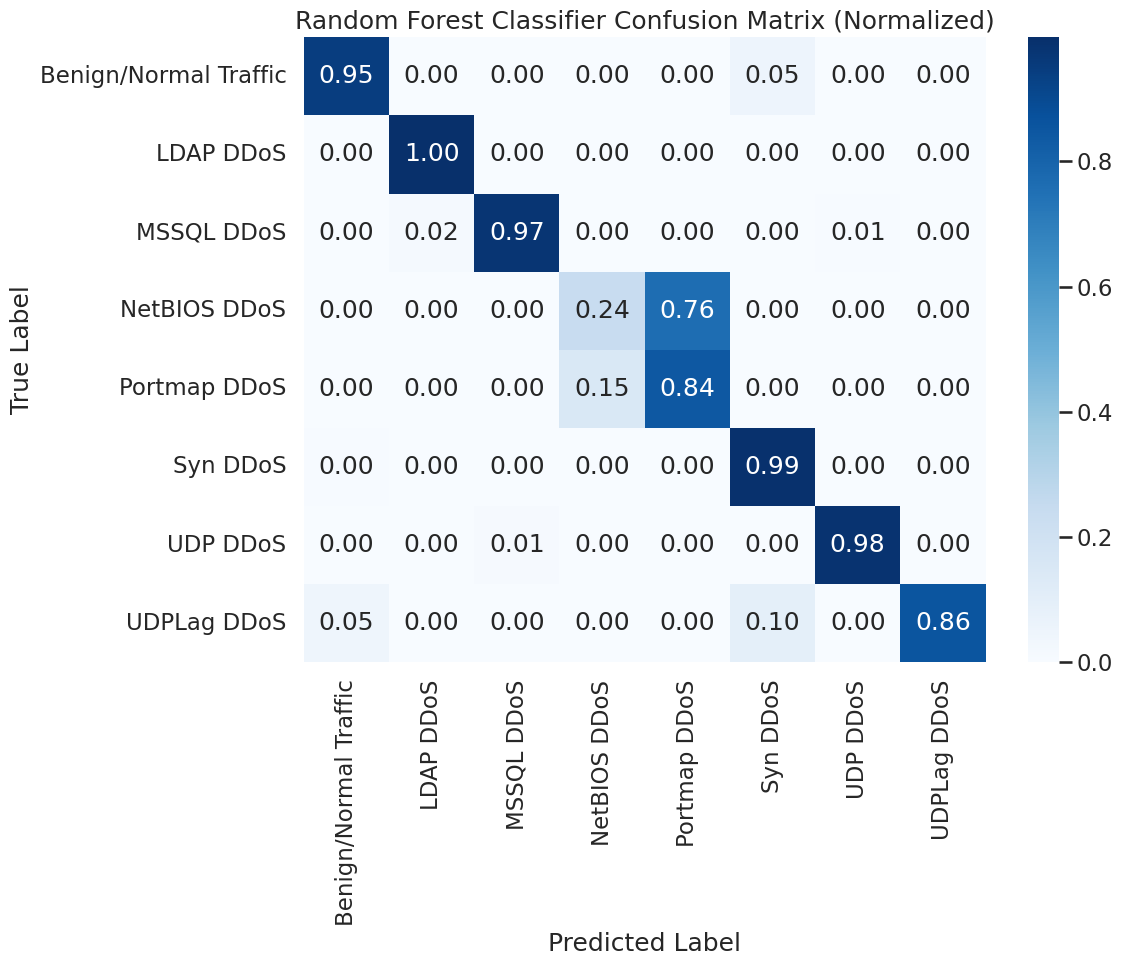

Creating ROC curves for Random Forest Classifier...


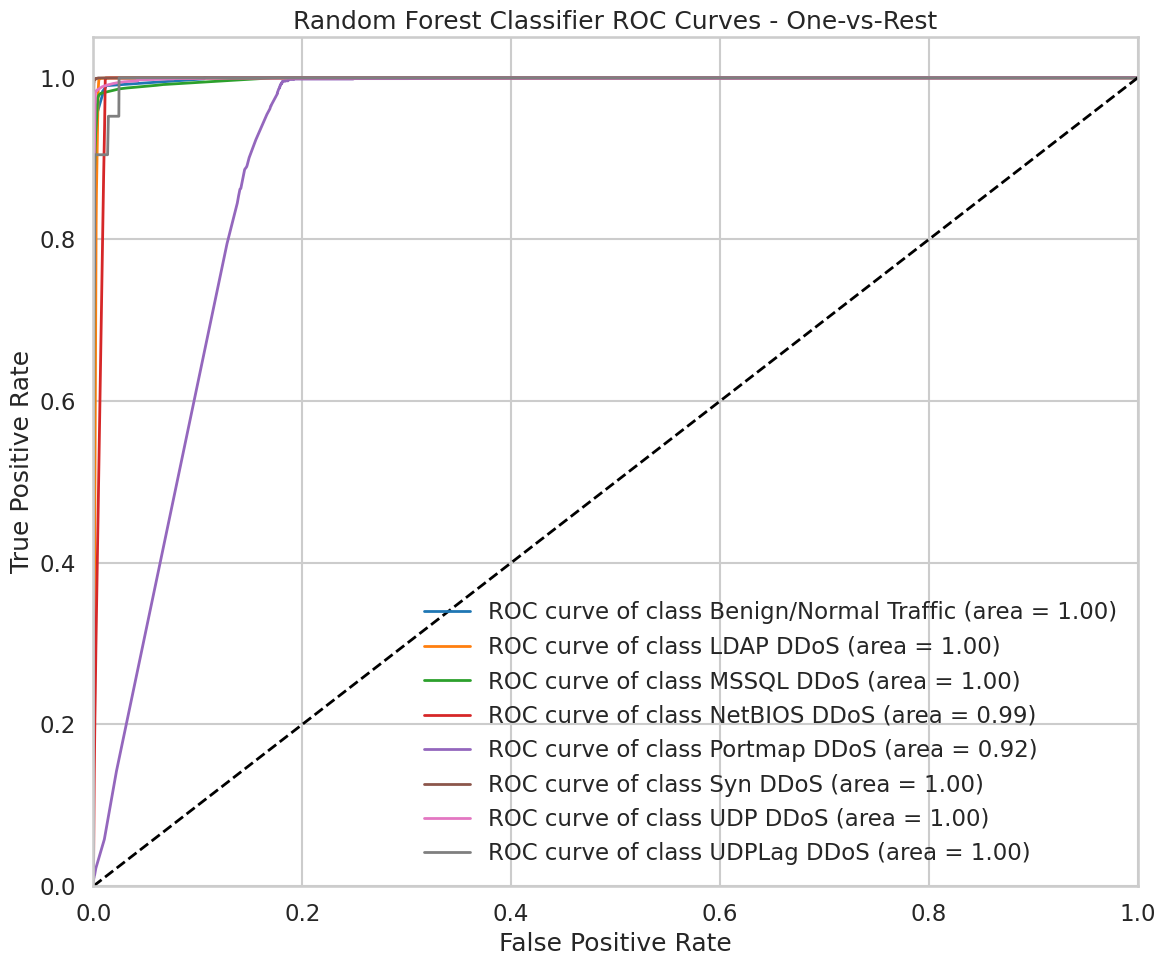

Creating Precision-Recall curves for Random Forest Classifier...


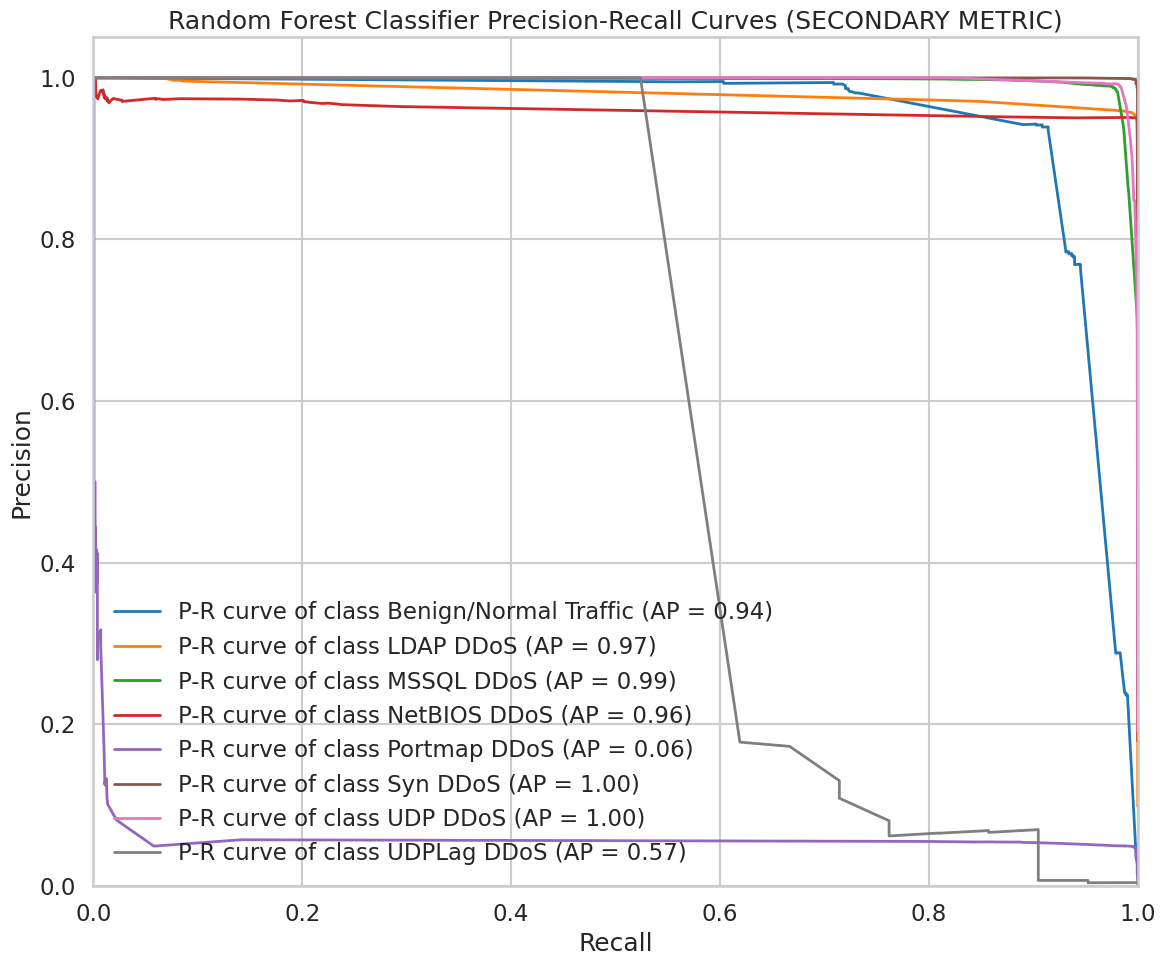

Creating feature importance plot for Random Forest Classifier...


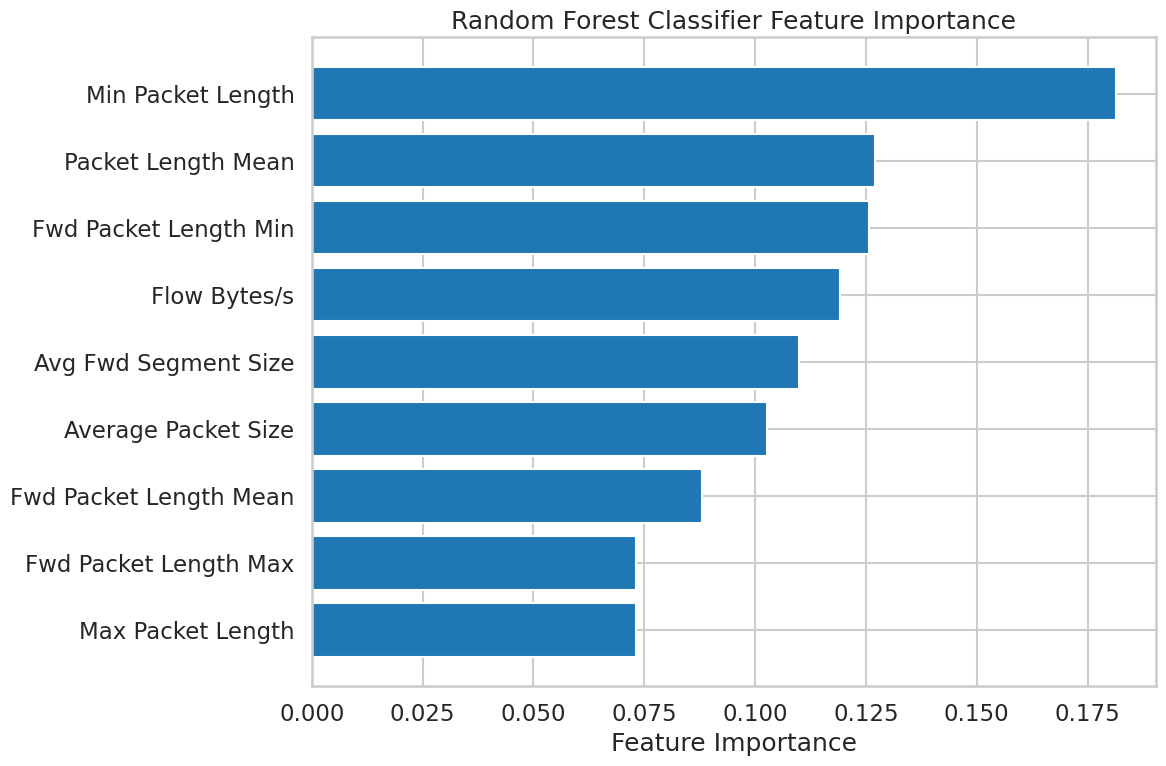

Generating per-class performance visualizations for Random Forest Classifier...


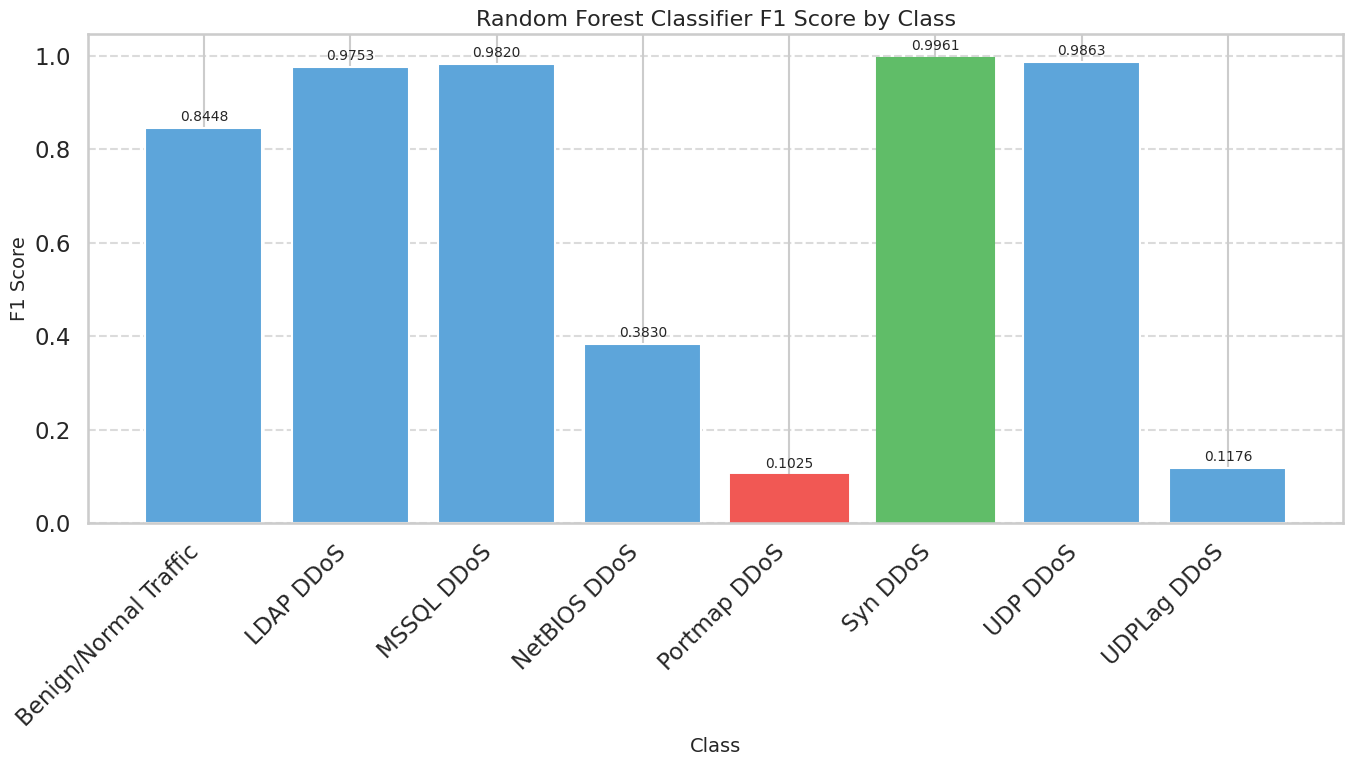

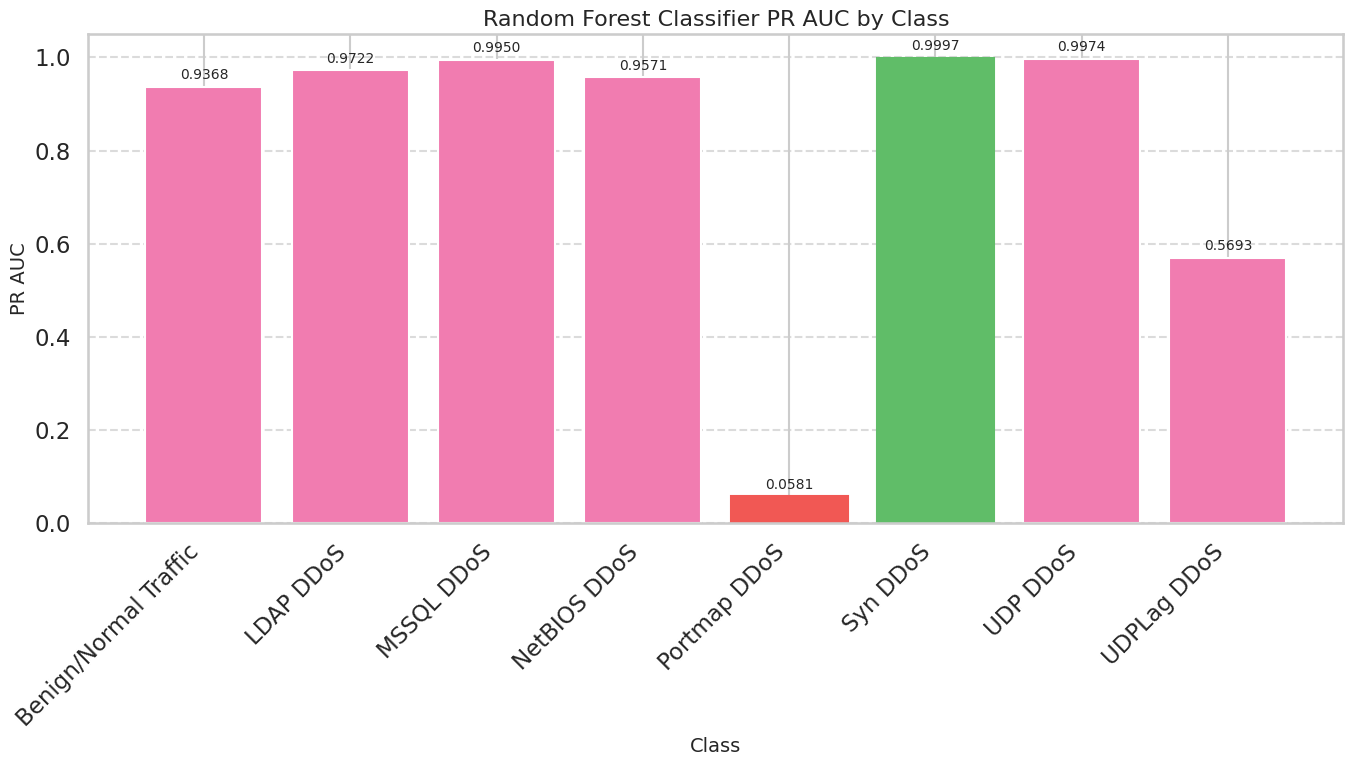

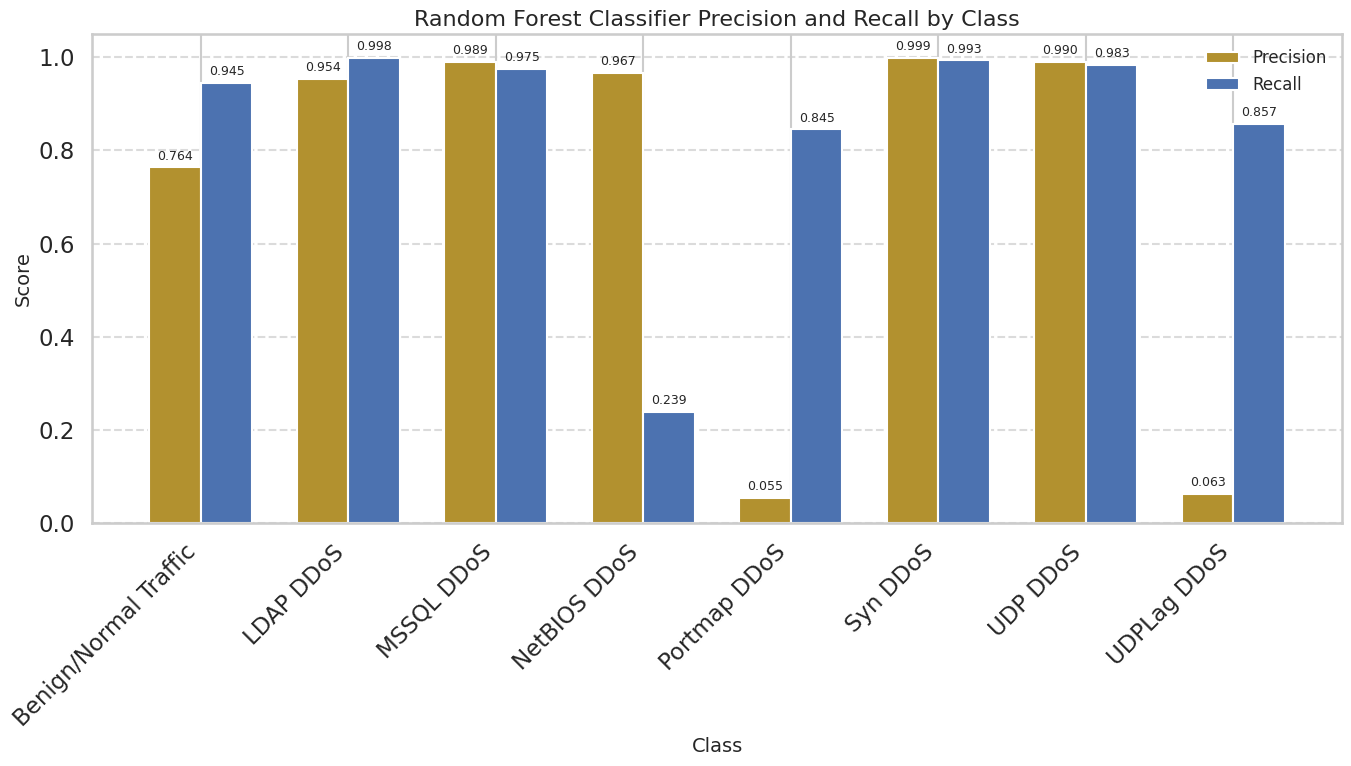

ROC AUC (OvR): 0.9882
PR AUC (Macro): 0.8107 (SECONDARY METRIC)
Random Forest Classifier saved to /content/drive/MyDrive/data/random_forest_classifier_20250517_1203.joblib
Random Forest Classifier evaluation completed!
SUMMARY: Test F1-Score = 0.6735 (PRIMARY), PR AUC = 0.8107 (SECONDARY), CV F1-Score = 0.8617


In [ ]:
# Random Forest Classifier
print("Initializing Random Forest Classifier...")

# Initialize Random Forest with optimized parameters
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Train and evaluate the model
rf_metrics, rf_model = train_evaluate_model(
    rf_model, X_train_scaled, y_train_res, X_test_scaled, y_test,
    "Random Forest Classifier", data_path, has_feature_importance=True
)

### 5.2 Decision Tree Classifier


**Purpose:** Develop a function that will be able to generate per-class performance metrics visualization (PR-AUC, recall, precision, and F1 score) for a machine learning model, specifically a bar plot of F1 scores by class with focus on the best and worst-performing classes, and save the plot to a given path with timestamp.

**Justification:** Visualization of per-class performance metrics is crucial in multi-class classification scenarios, such as DDoS attack detection, where model performance across classes (e.g., Benign and various forms of DDoS) must be known, especially when dealing with imbalanced data. F1 score bar plot provides a simple-to-interpret visualization of model strength per class with value labels to guarantee effective communication of performance. Highlighting top and bottom-performing classes (through green and red colors) highlights points of strength and weakness, enabling model diagnostics and model optimization. Function modularity enables reuse across models, enhancing maintainability and scalability of code. The use of seaborn and matplotlib styling presents visually attractive and professional outputs, which are quite crucial for communication and reporting purposes to stakeholders.

Initializing Decision Tree Classifier...
Initializing Decision Tree Classifier...
Running 5-fold cross-validation...
Decision Tree Classifier Cross-Validation Metrics:
Mean CV F1-Score: 0.8604 (IMPORTANT METRIC)
Mean CV Accuracy: 0.8727
Mean CV Precision: 0.8815
Mean CV Recall: 0.8727
Cross-validation time: 13.58 seconds
Training Decision Tree Classifier on full training set...
Model training completed in 4.03 seconds
Evaluating Decision Tree Classifier on test set...

Key Performance Metrics:
Test F1-Score: 0.6707 (PRIMARY METRIC)
PR AUC (macro): 0.7550 (SECONDARY METRIC)
CV F1-Score: 0.8604 (IMPORTANT METRIC)

Test Set Evaluation:
                       precision    recall  f1-score   support

Benign/Normal Traffic     0.7616    0.9437    0.8430       711
            LDAP DDoS     0.9528    0.9961    0.9739     19584
           MSSQL DDoS     0.9884    0.9745    0.9814     56073
         NetBIOS DDoS     0.9659    0.2381    0.3821     35582
         Portmap DDoS     0.0544    0.8444 

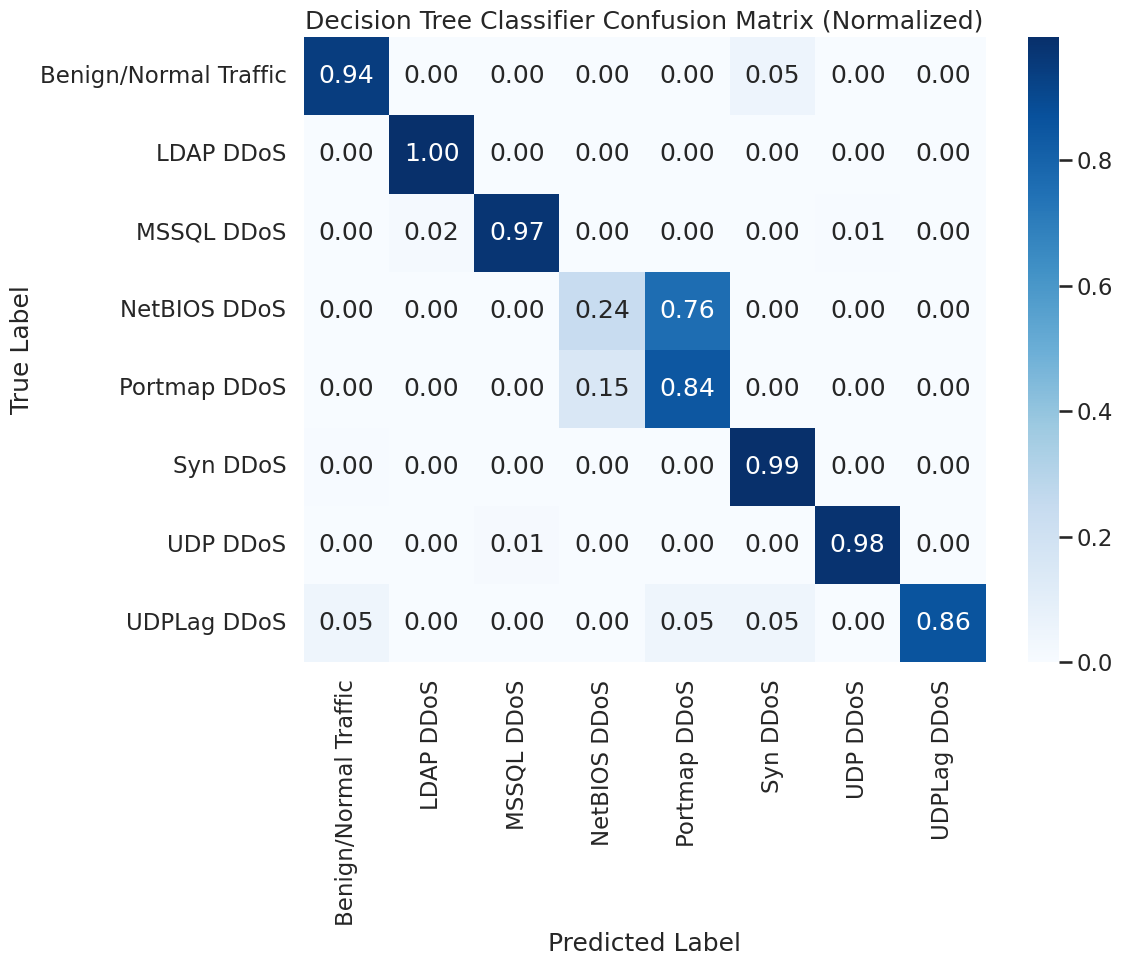

Creating ROC curves for Decision Tree Classifier...


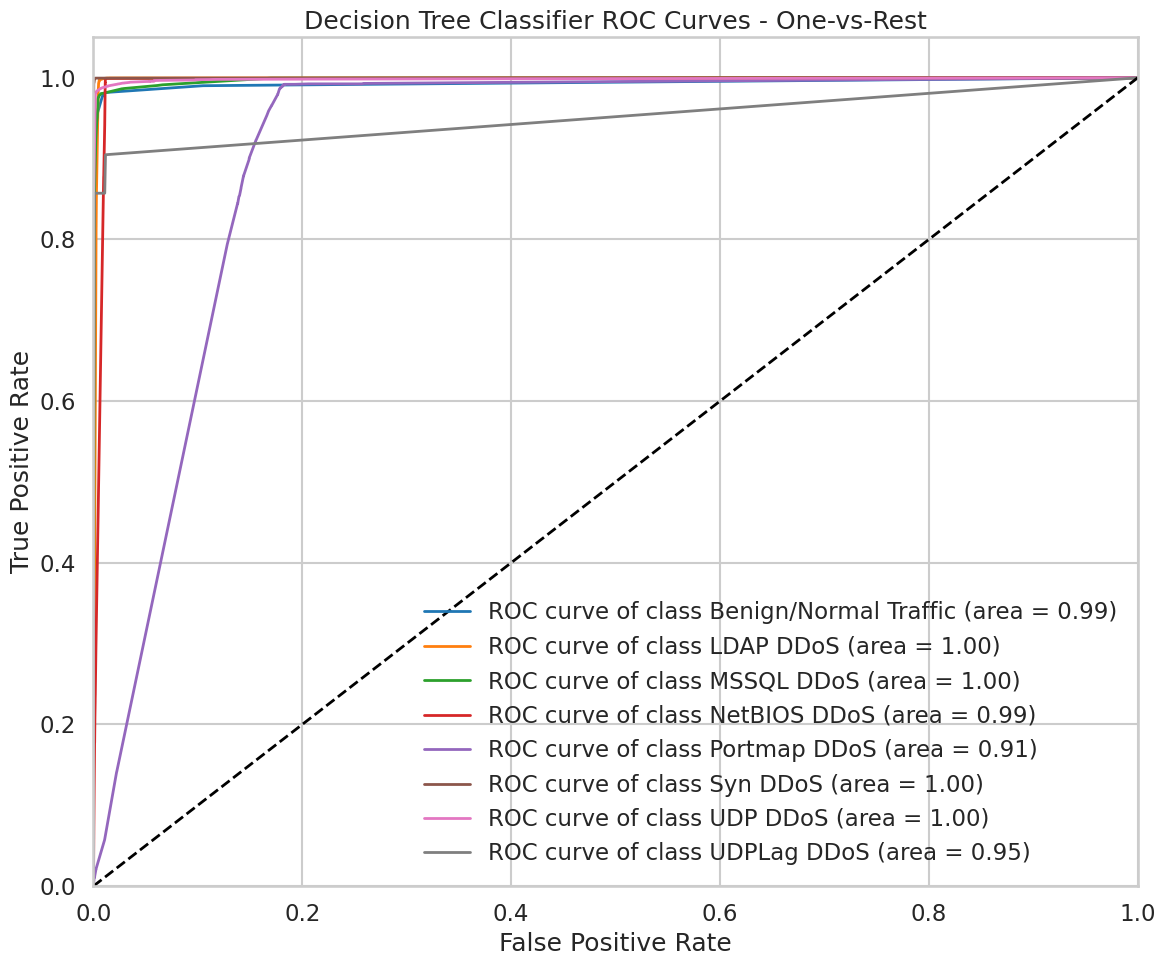

Creating Precision-Recall curves for Decision Tree Classifier...


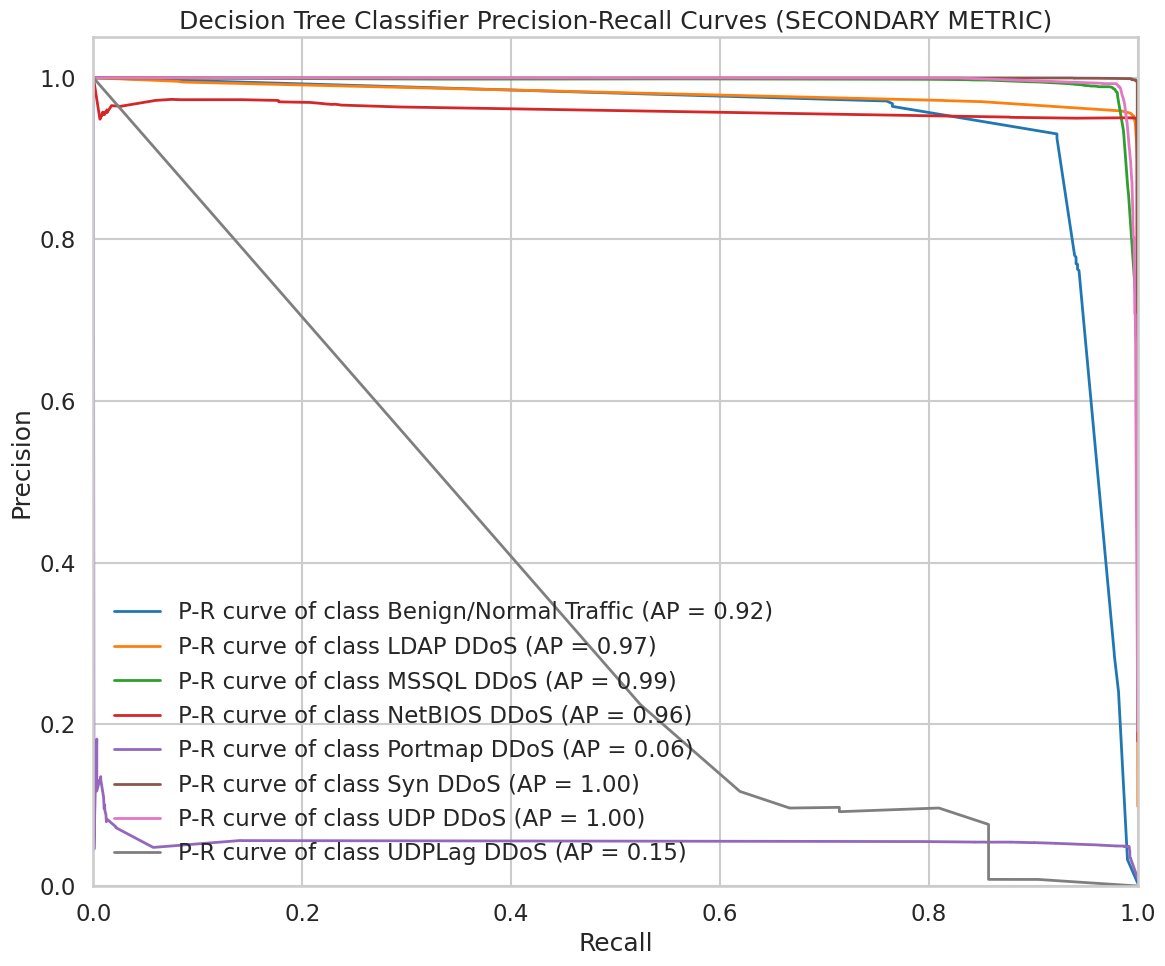

Creating feature importance plot for Decision Tree Classifier...


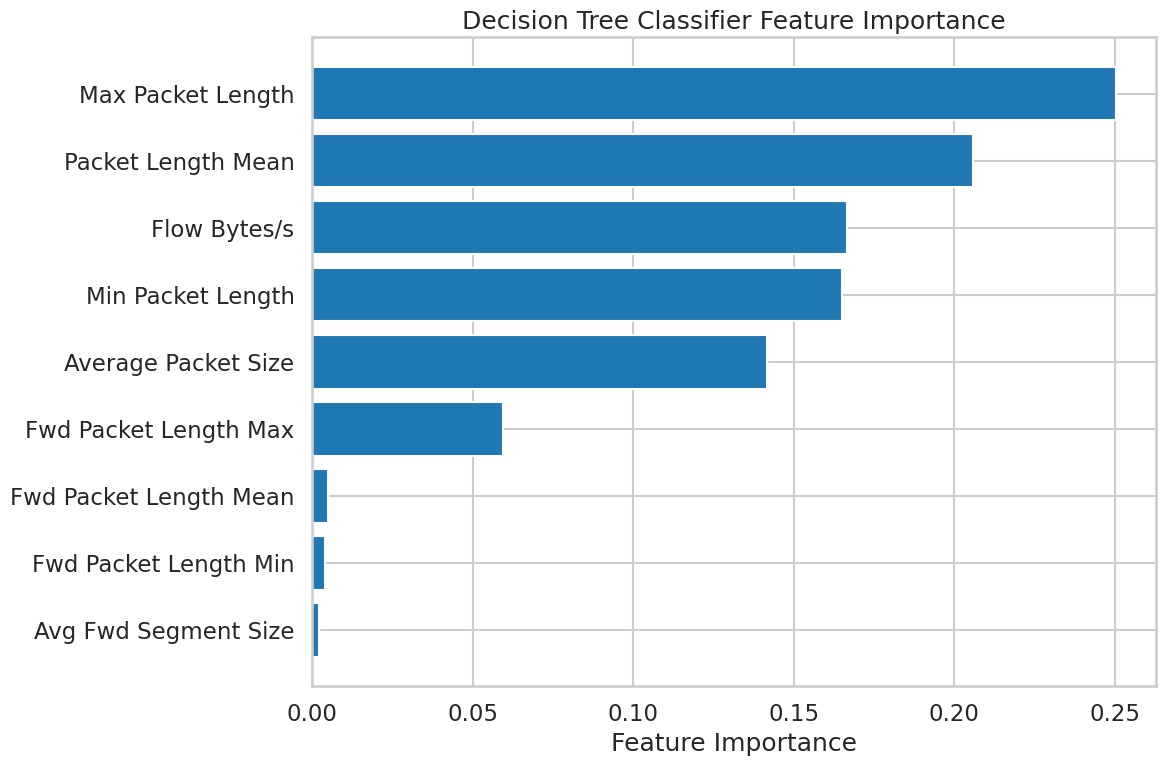

Generating per-class performance visualizations for Decision Tree Classifier...


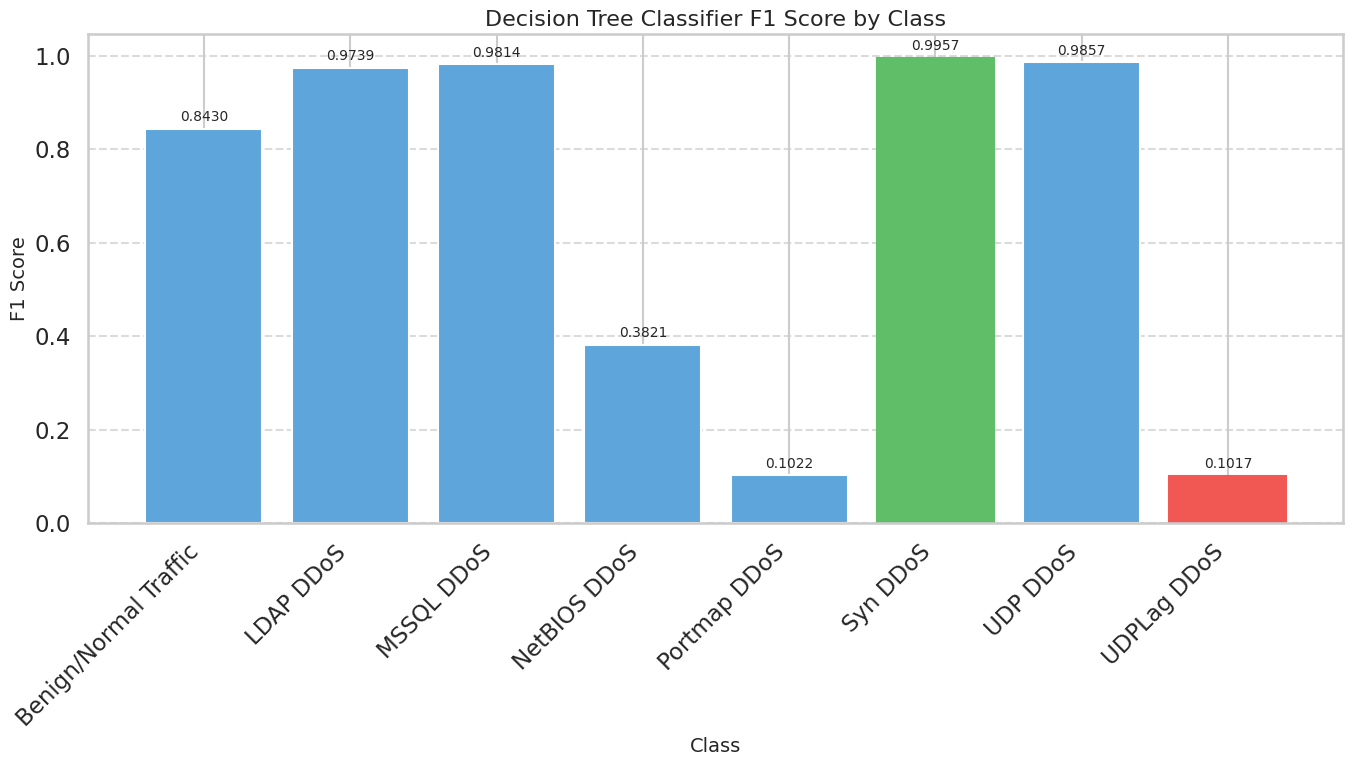

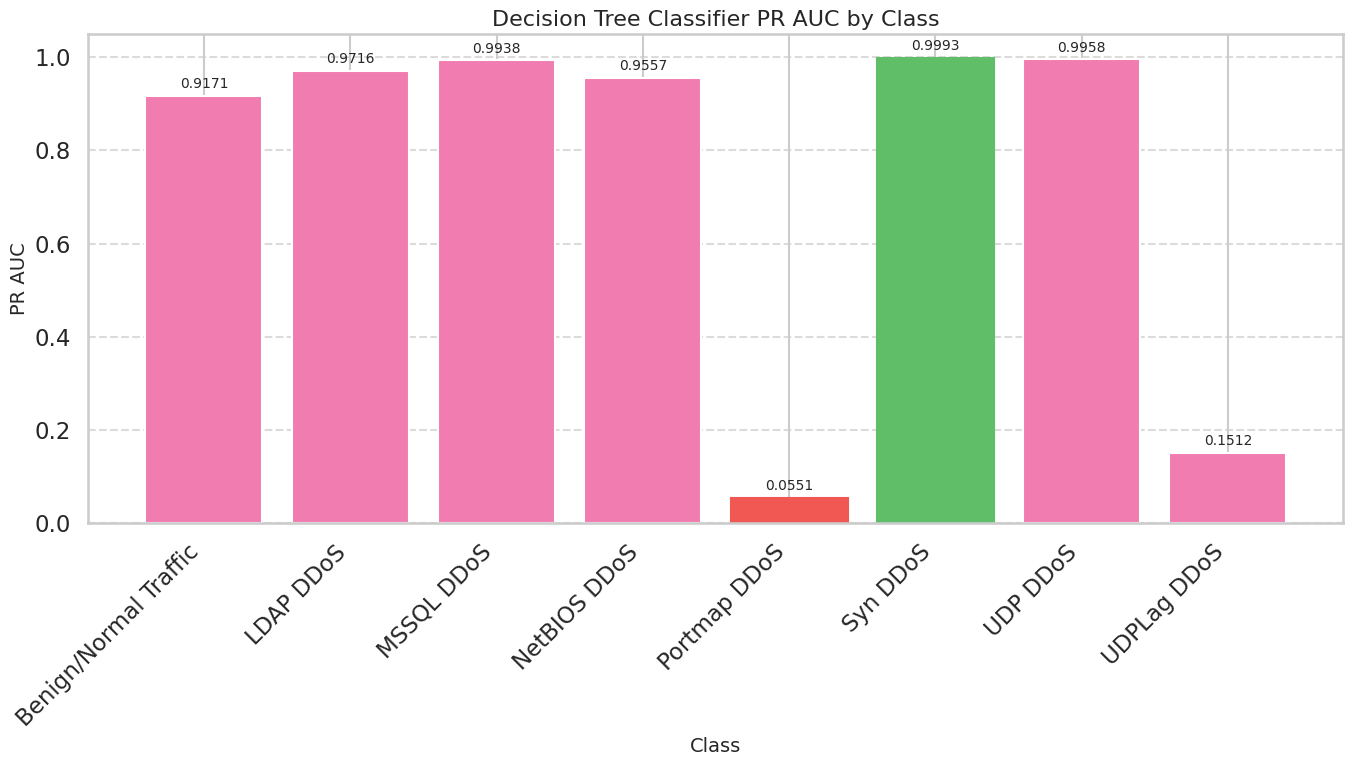

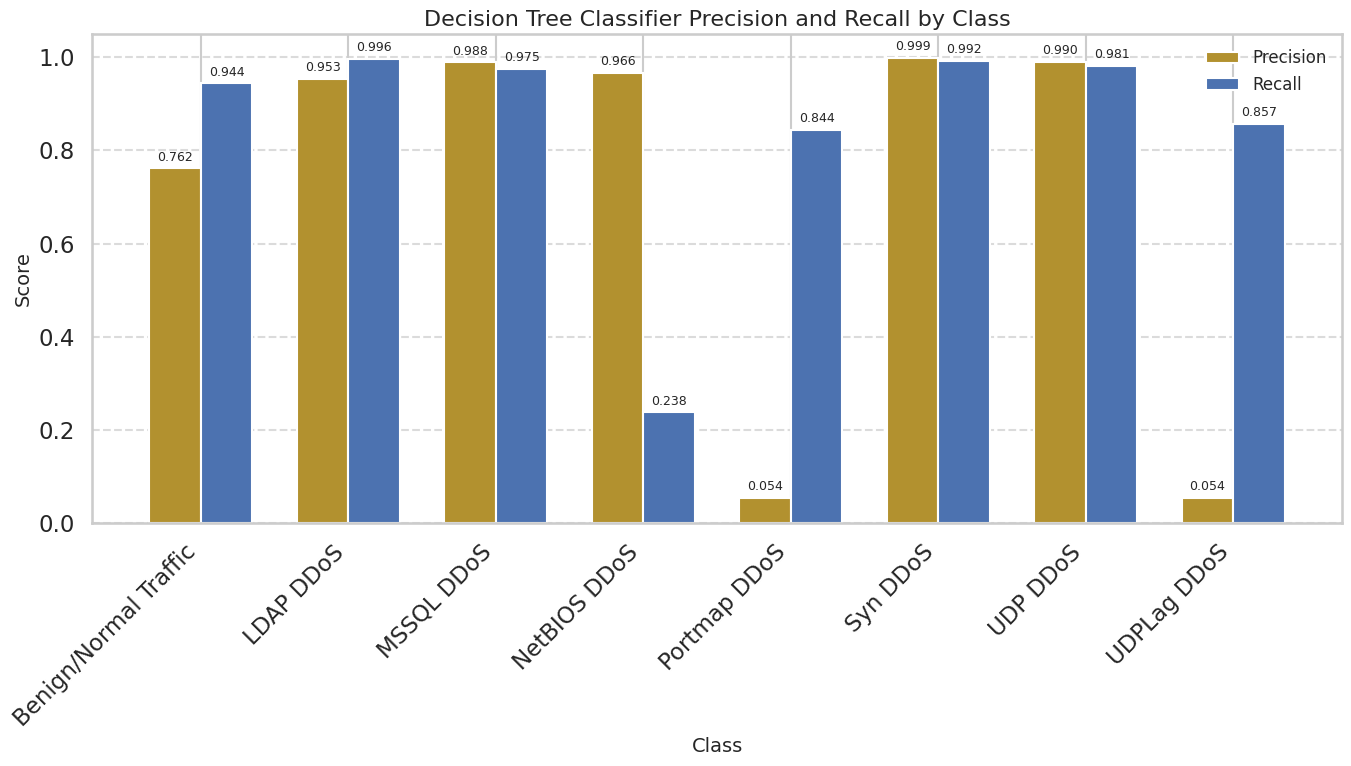

ROC AUC (OvR): 0.9810
PR AUC (Macro): 0.7550 (SECONDARY METRIC)
Decision Tree Classifier saved to /content/drive/MyDrive/data/decision_tree_classifier_20250517_1203.joblib
Decision Tree Classifier evaluation completed!
SUMMARY: Test F1-Score = 0.6707 (PRIMARY), PR AUC = 0.7550 (SECONDARY), CV F1-Score = 0.8604


In [ ]:
# Decision Tree Classifier
print("Initializing Decision Tree Classifier...")

# Initialize Decision Tree with optimized parameters
dt_model = DecisionTreeClassifier(
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=RANDOM_STATE
)

# Train and evaluate the model
dt_metrics, dt_model = train_evaluate_model(
    dt_model, X_train_scaled, y_train_res, X_test_scaled, y_test,
    "Decision Tree Classifier", data_path, has_feature_importance=True
)

### 5.3 XGBoost Classifier


**Purpose:**
This cell instantiates an XGBClassifier, trains it on the SMOTE-balanced training set, evaluates it against the imbalanced test set, and then applies a post-hoc optimization method exclusive to imbalanced class distributions.

**Justification:**
The constructor parameters (n_estimators=100, max_depth=7, subsample=0.8, colsample_bytree=0.8) trade off expressiveness with overfitting control following literature guidelines—important since attack classes have significantly varying sample sizes. objective="multi:softprob" and num_class=len(class_names) enable native multi-class probability outputs, which the following evaluation pipeline expects for PR-AUC computations. Disabling the legacy label encoder avoids deprecated warnings, and eval_metric="mlogloss" provides a class-aware, robust optimization target when training.

After fitting, the wrapper function train_evaluate_model integrates cross‑validated calibration, metric computation, and artifact saving, offering consistency with other classifier tests. Having set has_feature_importance=True, gain‑based importance scores are captured explicitly, allowing for interpretability analyses.

Finally, optimize_model_for_imbalanced_test adjusts the trained model (e.g., by probability‑threshold tuning or class‑specific weighing) to best achieve macro‑F1 on the naturally imbalanced test distribution. This two‑step approach—train on balanced data and then fit to real‑world skew—adheres to best practices for intrusion‑detection research, in which operational data never match training distributions.

Initializing XGBoost Classifier...
Initializing XGBoost Classifier...
Running 5-fold cross-validation...
XGBoost Classifier Cross-Validation Metrics:
Mean CV F1-Score: 0.8566 (IMPORTANT METRIC)
Mean CV Accuracy: 0.8690
Mean CV Precision: 0.8774
Mean CV Recall: 0.8690
Cross-validation time: 155.69 seconds
Training XGBoost Classifier on full training set...
Model training completed in 35.16 seconds
Evaluating XGBoost Classifier on test set...

Key Performance Metrics:
Test F1-Score: 0.6647 (PRIMARY METRIC)
PR AUC (macro): 0.8195 (SECONDARY METRIC)
CV F1-Score: 0.8566 (IMPORTANT METRIC)

Test Set Evaluation:
                       precision    recall  f1-score   support

Benign/Normal Traffic     0.7522    0.9480    0.8388       711
            LDAP DDoS     0.9395    0.9917    0.9649     19584
           MSSQL DDoS     0.9856    0.9680    0.9767     56073
         NetBIOS DDoS     0.9664    0.2358    0.3792     35582
         Portmap DDoS     0.0545    0.8482    0.1025      1851
        

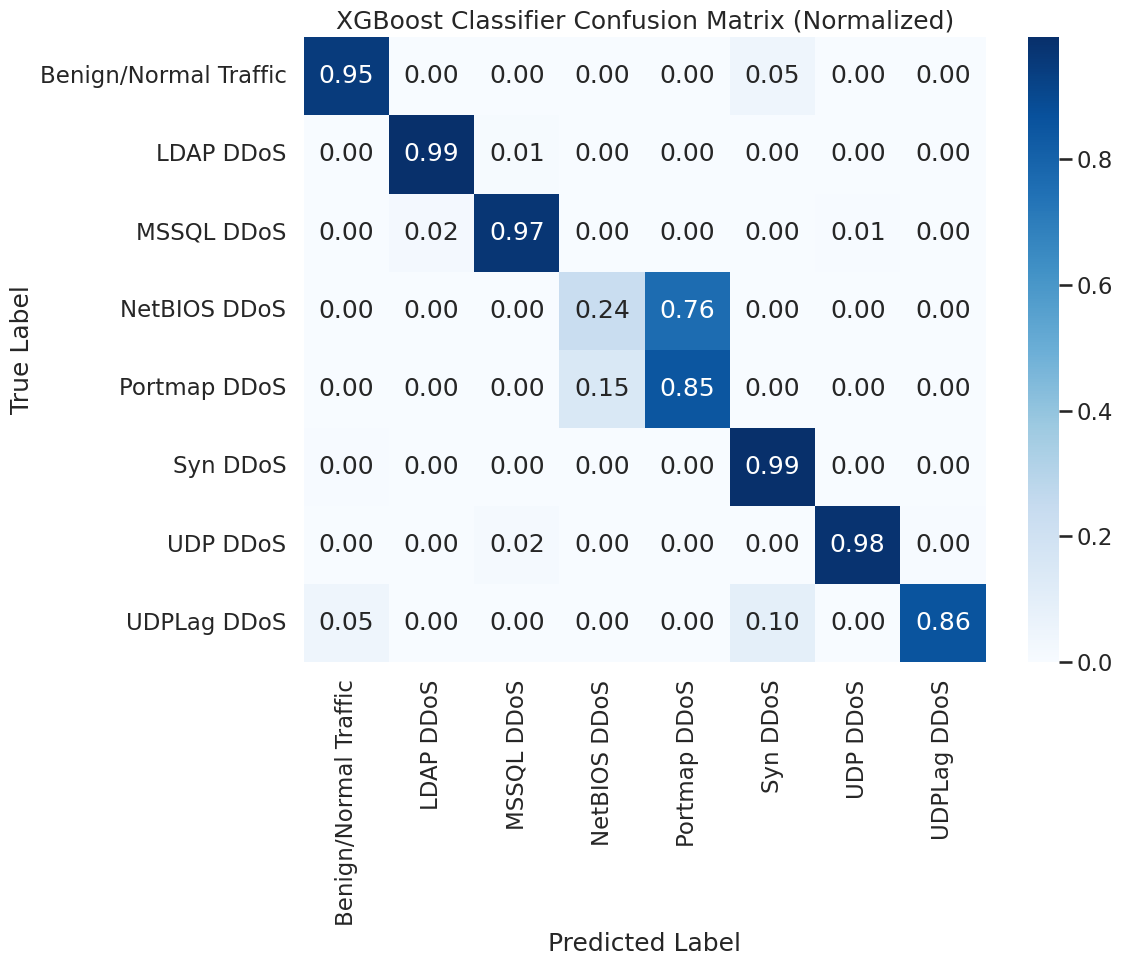

Creating ROC curves for XGBoost Classifier...


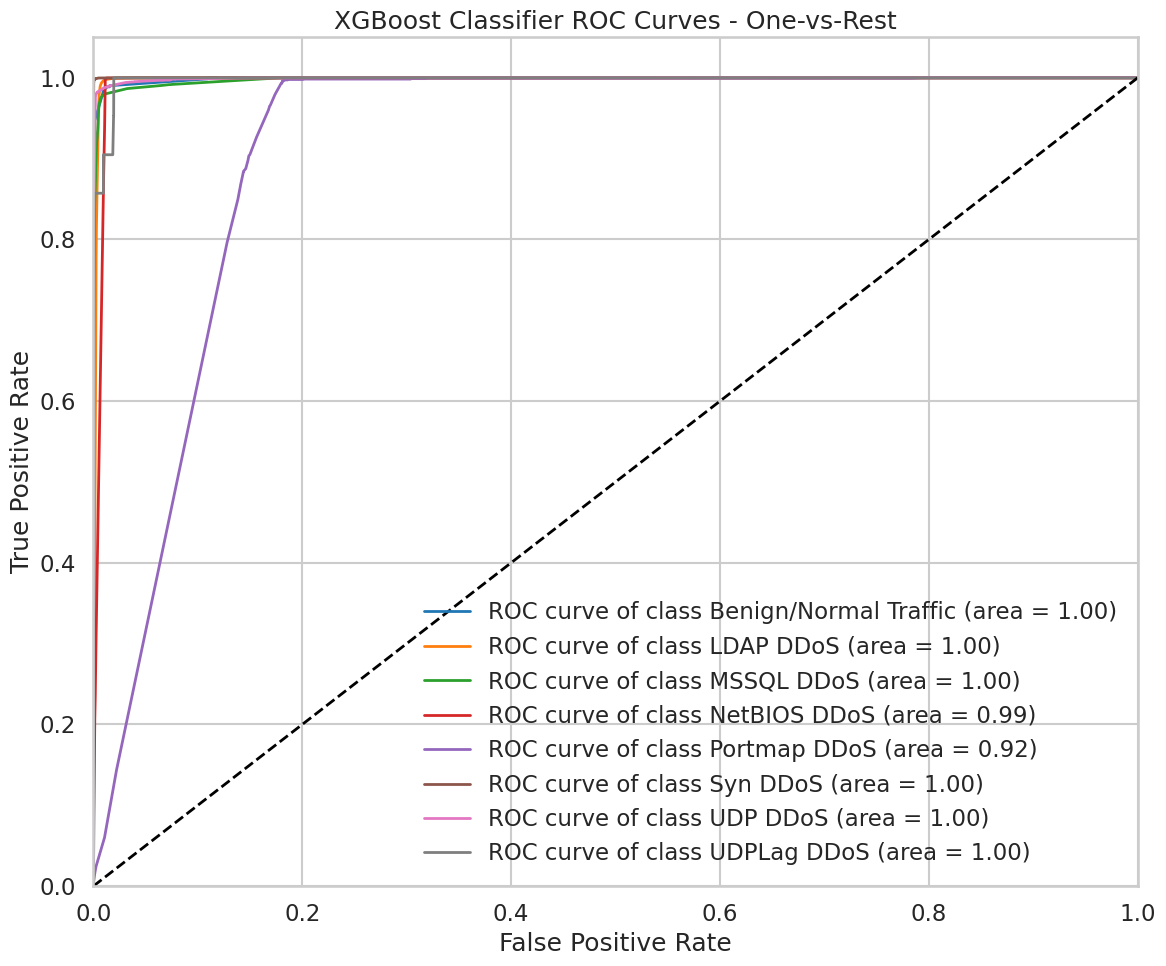

Creating Precision-Recall curves for XGBoost Classifier...


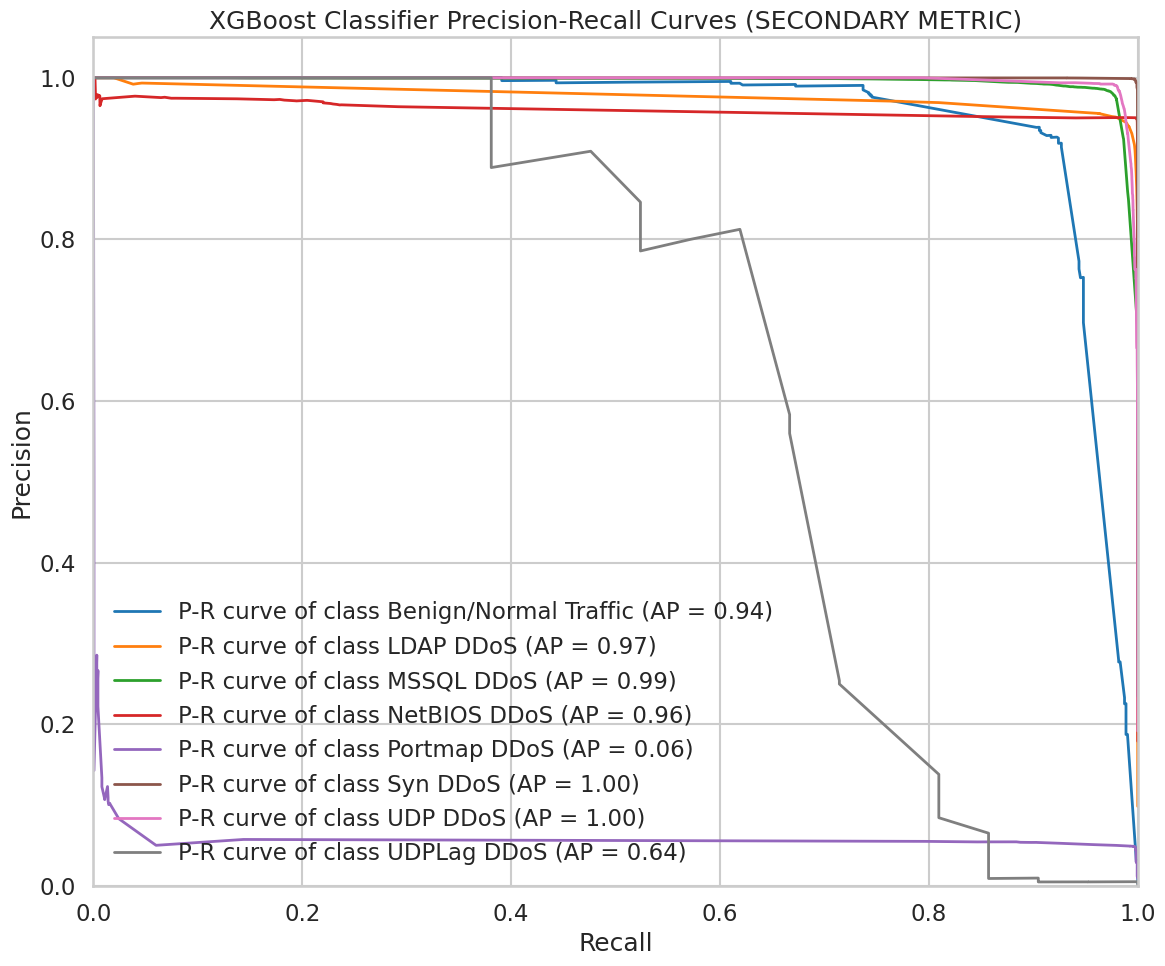

Creating feature importance plot for XGBoost Classifier...


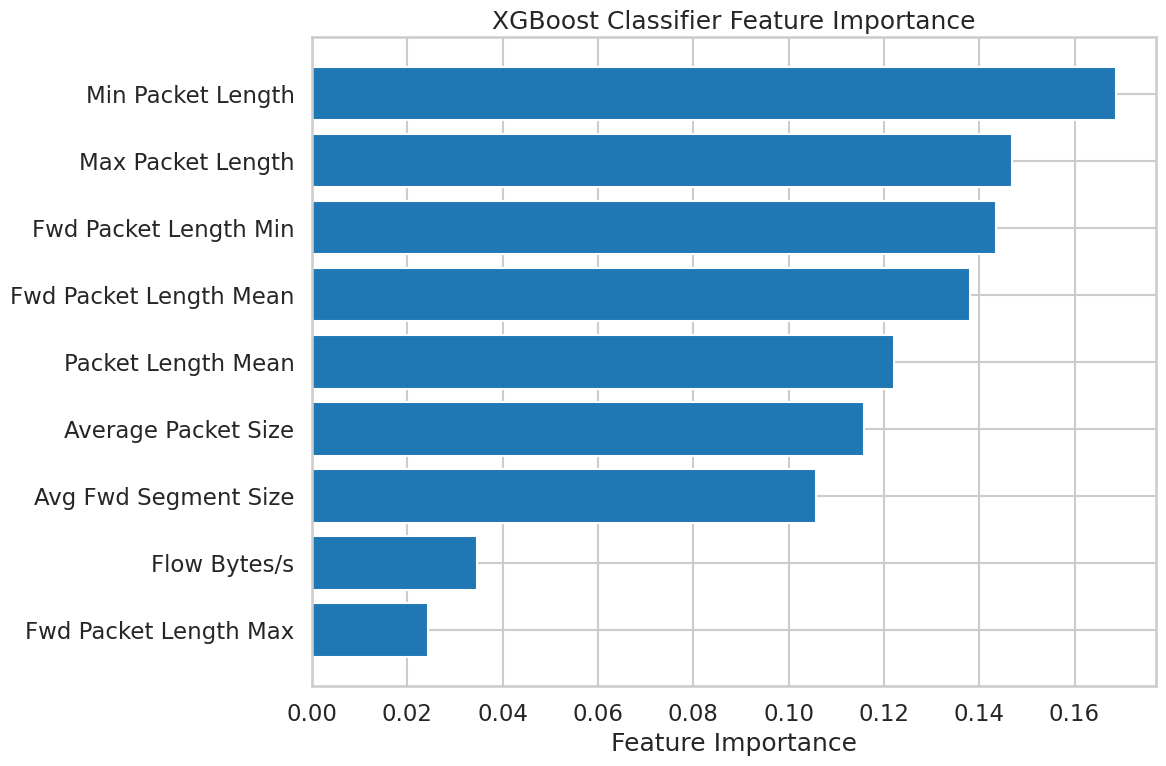

Generating per-class performance visualizations for XGBoost Classifier...


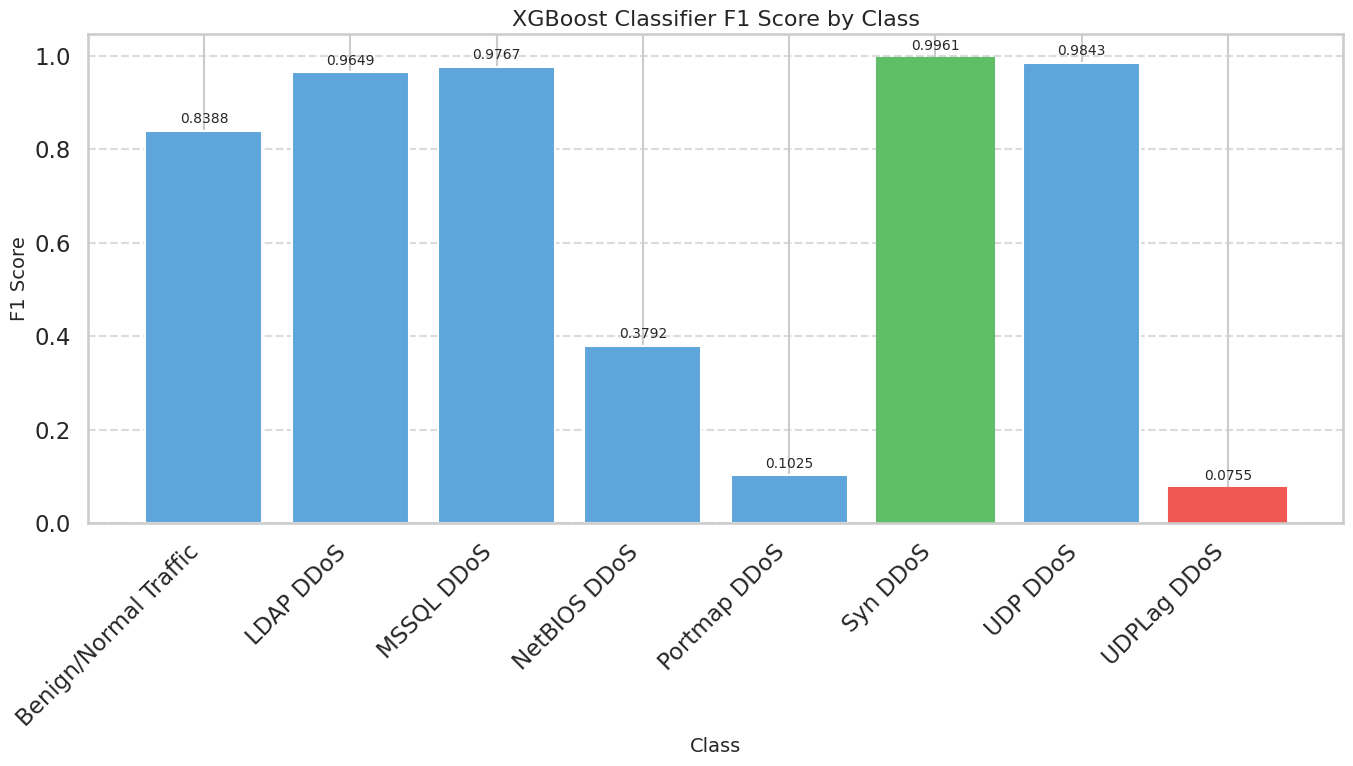

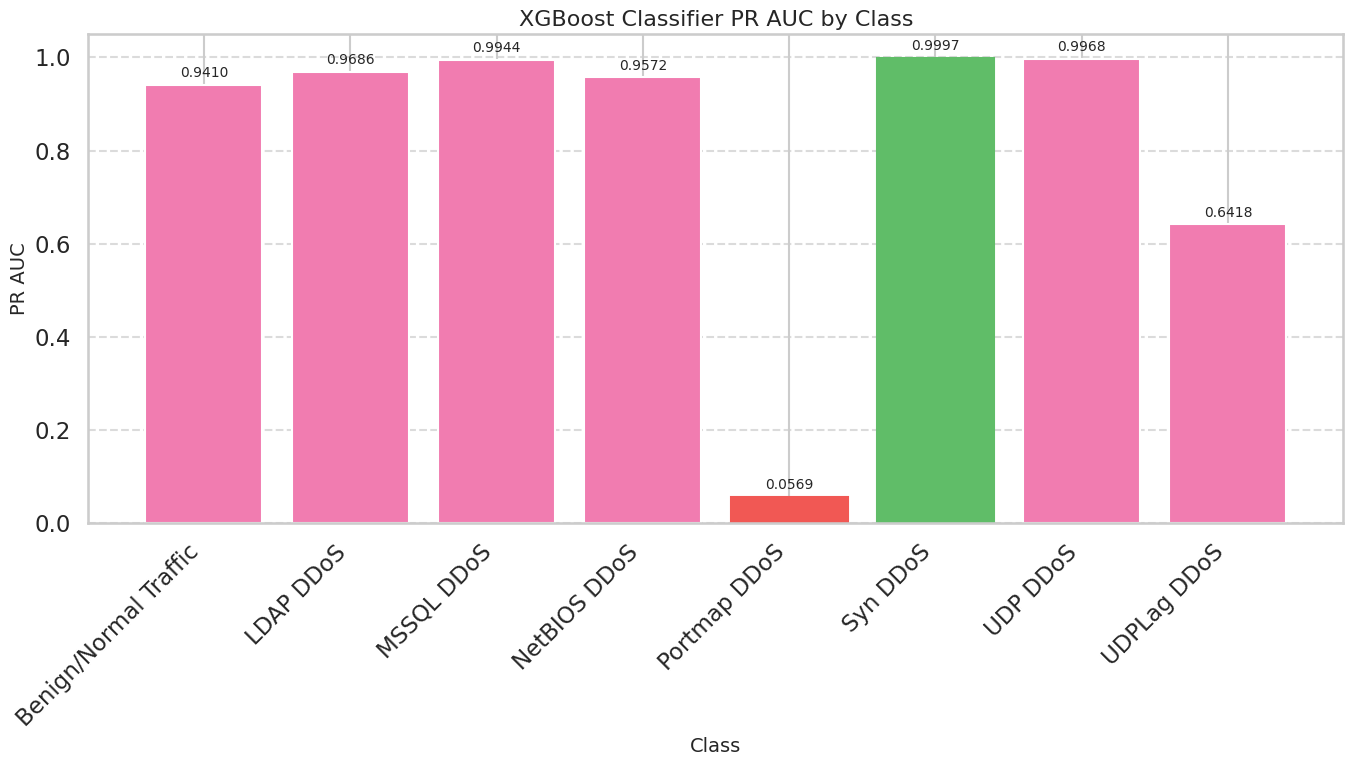

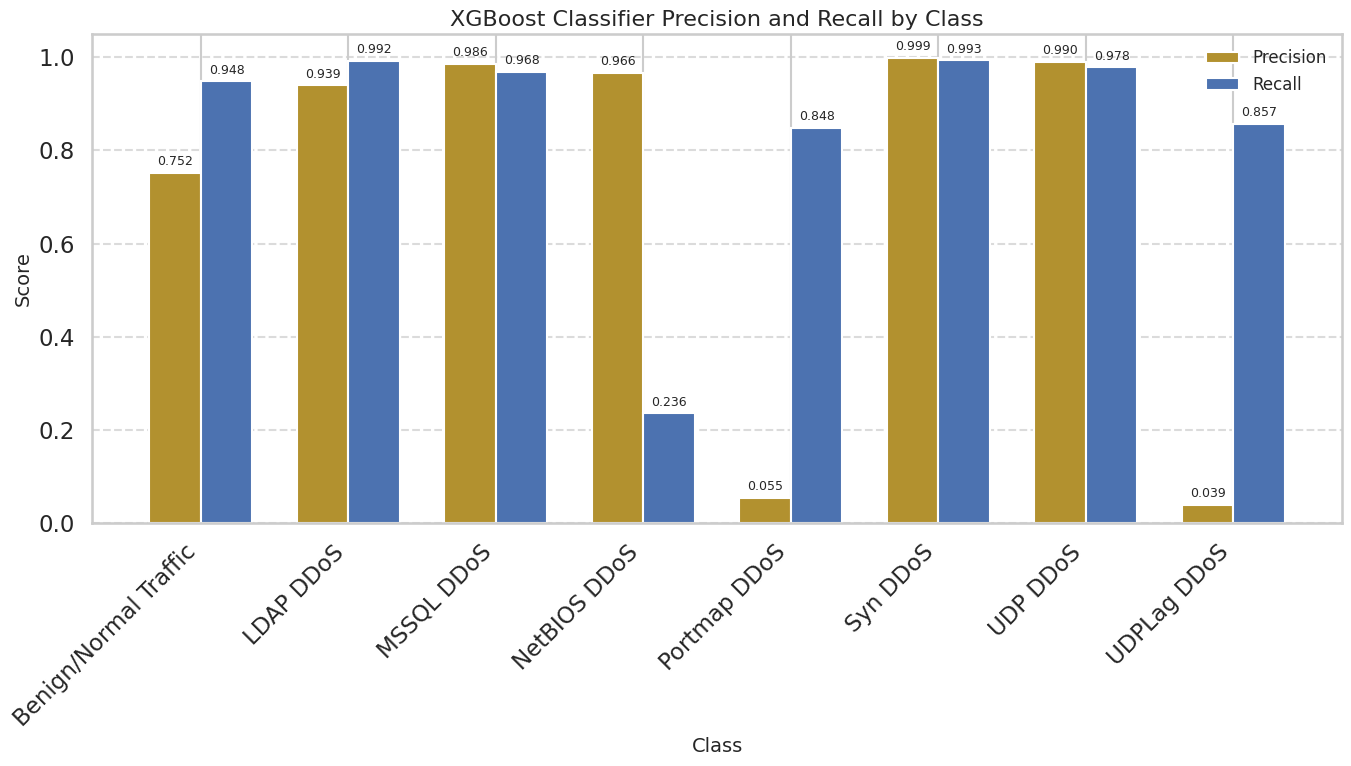

ROC AUC (OvR): 0.9881
PR AUC (Macro): 0.8195 (SECONDARY METRIC)
XGBoost Classifier saved to /content/drive/MyDrive/data/xgboost_classifier_20250517_1203.joblib
XGBoost Classifier evaluation completed!
SUMMARY: Test F1-Score = 0.6647 (PRIMARY), PR AUC = 0.8195 (SECONDARY), CV F1-Score = 0.8566

Optimizing XGBoost Classifier for imbalanced test data...

Optimized XGBoost Classifier Results:
Optimized Test F1-Score (macro): 0.6623

Per-class F1 Scores:
  Benign/Normal Traffic: 0.8388 (count: 711, freq: 0.0036)
  LDAP DDoS: 0.9649 (count: 19584, freq: 0.0986)
  MSSQL DDoS: 0.9767 (count: 56073, freq: 0.2824)
  NetBIOS DDoS: 0.3792 (count: 35582, freq: 0.1792)
  Portmap DDoS: 0.1024 (count: 1851, freq: 0.0093)
  Syn DDoS: 0.9950 (count: 46627, freq: 0.2349)
  UDP DDoS: 0.9840 (count: 38075, freq: 0.1918)
  UDPLag DDoS: 0.0578 (count: 21, freq: 0.0001)


In [ ]:
# Initialize XGBoost
print("Initializing XGBoost Classifier...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=len(class_names),
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Train and evaluate the model
xgb_metrics, xgb_model = train_evaluate_model(
    xgb_model, X_train_scaled, y_train_res, X_test_scaled, y_test,
    "XGBoost Classifier", data_path, has_feature_importance=True
)

# Optimize for imbalanced test set
xgb_optimized, xgb_opt_f1, xgb_opt_per_class_f1 = optimize_model_for_imbalanced_test(
    xgb_model, "XGBoost Classifier"
)

### 5.4 K-Nearest Neighbors Classifier


**Purpose:**
This cell constructs a KNeighborsClassifier with tuned parameters, trains it on the SMOTE-balanced data, and evaluates it on the imbalanced test set using a default wrapper for metric reporting and artifact saving.


**Justification:** The model is established with n_neighbors=5 for moderate bias-variance tradeoff and computation efficiency. weights='distance' assigns the highest weight to the nearest neighbors, enhancing decision boundaries in high-dimensional or noisy feature spaces—canonical DDoS traffic data conditions. p=2 enforces Euclidean distance, which is appropriate considering the standardized feature space. algorithm='auto' allows scikit-learn to decide upon the most computationally efficient internal algorithm based on data type, and n_jobs=-1 performs parallel computation for faster training and inference.

Although KNN lacks built-in feature importance, setting has_feature_importance=False disables any such functionality in the evaluation pipeline. The train_evaluate_model wrapper ensures uniform performance testing of all models, ranging from PR-AUC, macro-F1, to calibration analysis, permitting direct comparison with other classifiers in the study.

Initializing K-Nearest Neighbors Classifier...
Initializing K-Nearest Neighbors Classifier...
Running 5-fold cross-validation...
K-Nearest Neighbors Classifier Cross-Validation Metrics:
Mean CV F1-Score: 0.8499 (IMPORTANT METRIC)
Mean CV Accuracy: 0.8663
Mean CV Precision: 0.8723
Mean CV Recall: 0.8663
Cross-validation time: 263.61 seconds
Training K-Nearest Neighbors Classifier on full training set...
Model training completed in 1.04 seconds
Evaluating K-Nearest Neighbors Classifier on test set...

Key Performance Metrics:
Test F1-Score: 0.7284 (PRIMARY METRIC)
PR AUC (macro): 0.7306 (SECONDARY METRIC)
CV F1-Score: 0.8499 (IMPORTANT METRIC)

Test Set Evaluation:
                       precision    recall  f1-score   support

Benign/Normal Traffic     0.7662    0.9494    0.8480       711
            LDAP DDoS     0.9529    0.9969    0.9744     19584
           MSSQL DDoS     0.9885    0.9741    0.9813     56073
         NetBIOS DDoS     0.9464    0.7495    0.8365     35582
         Por

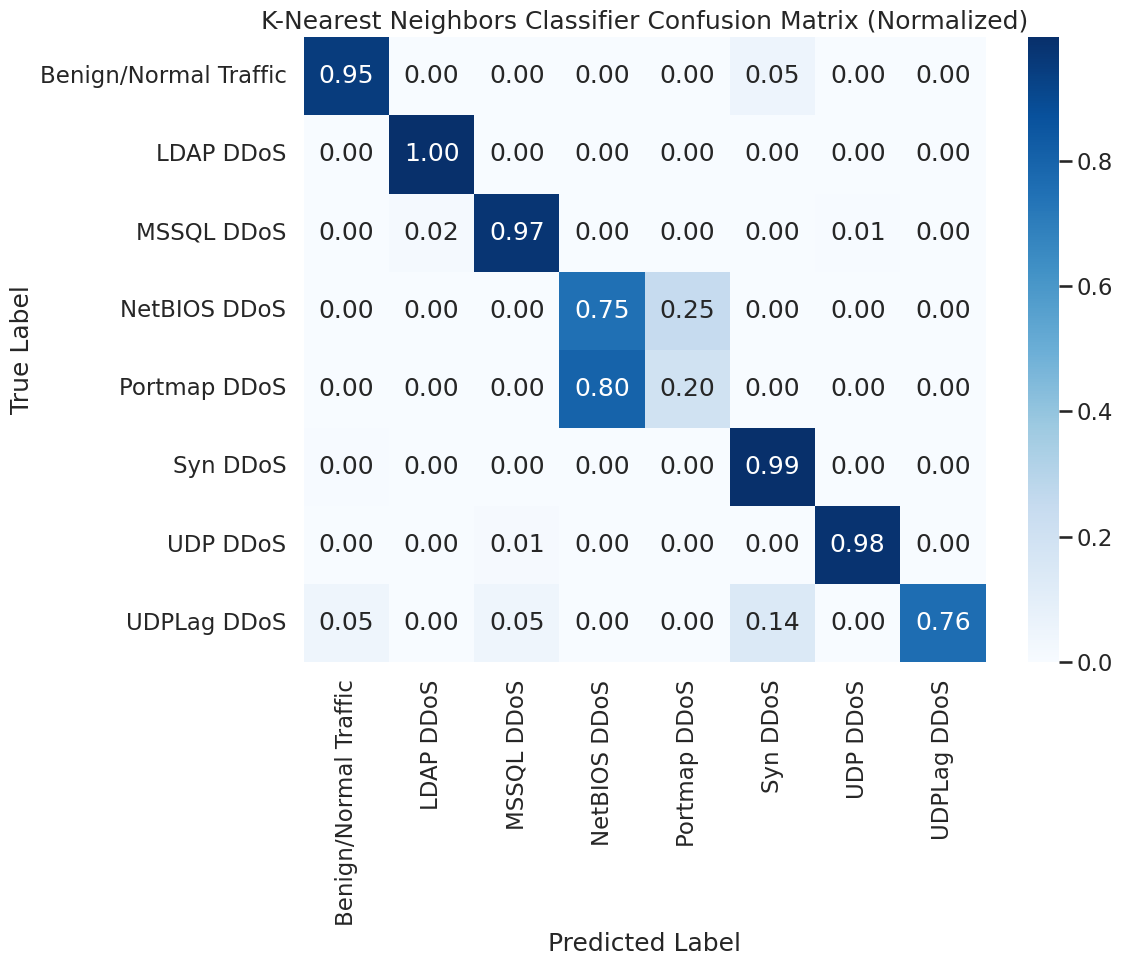

Creating ROC curves for K-Nearest Neighbors Classifier...


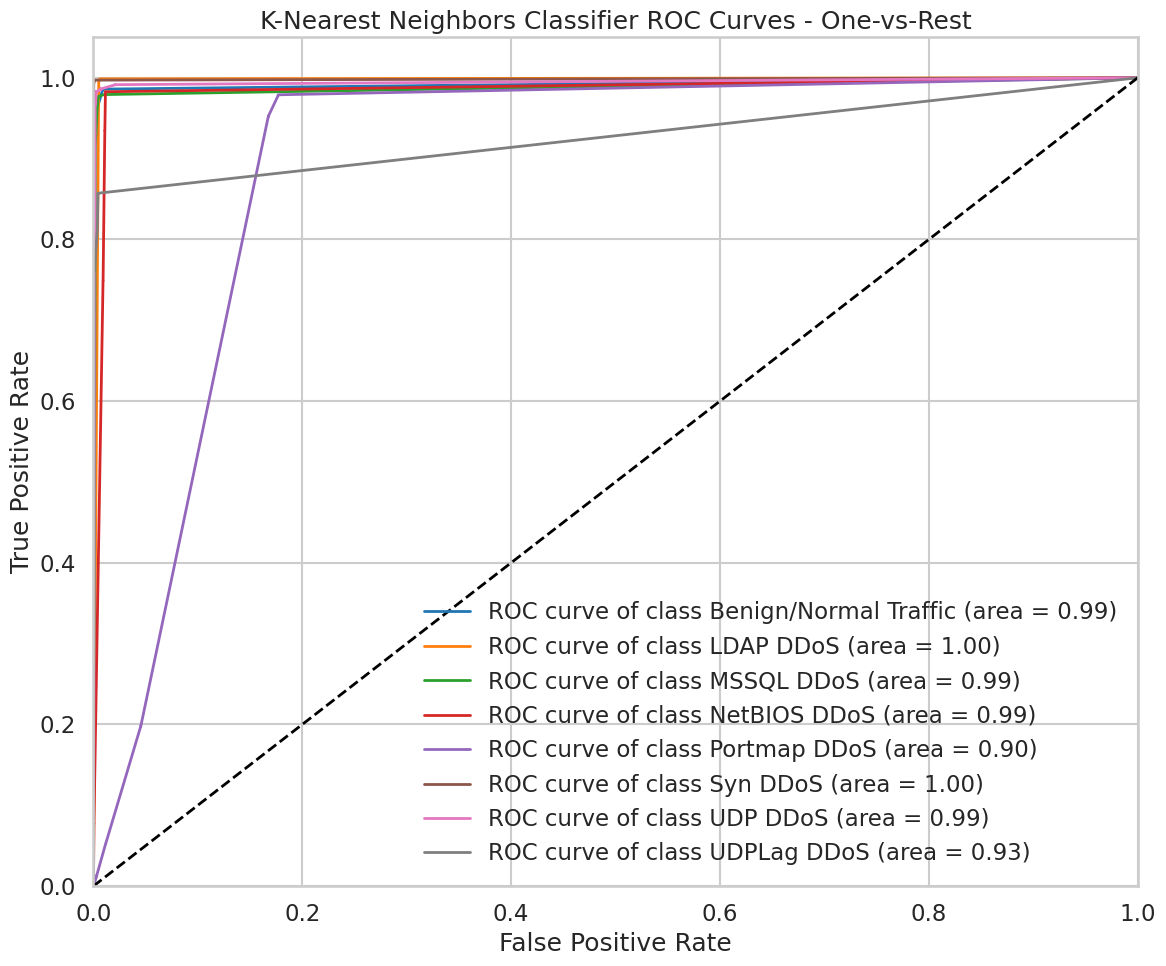

Creating Precision-Recall curves for K-Nearest Neighbors Classifier...


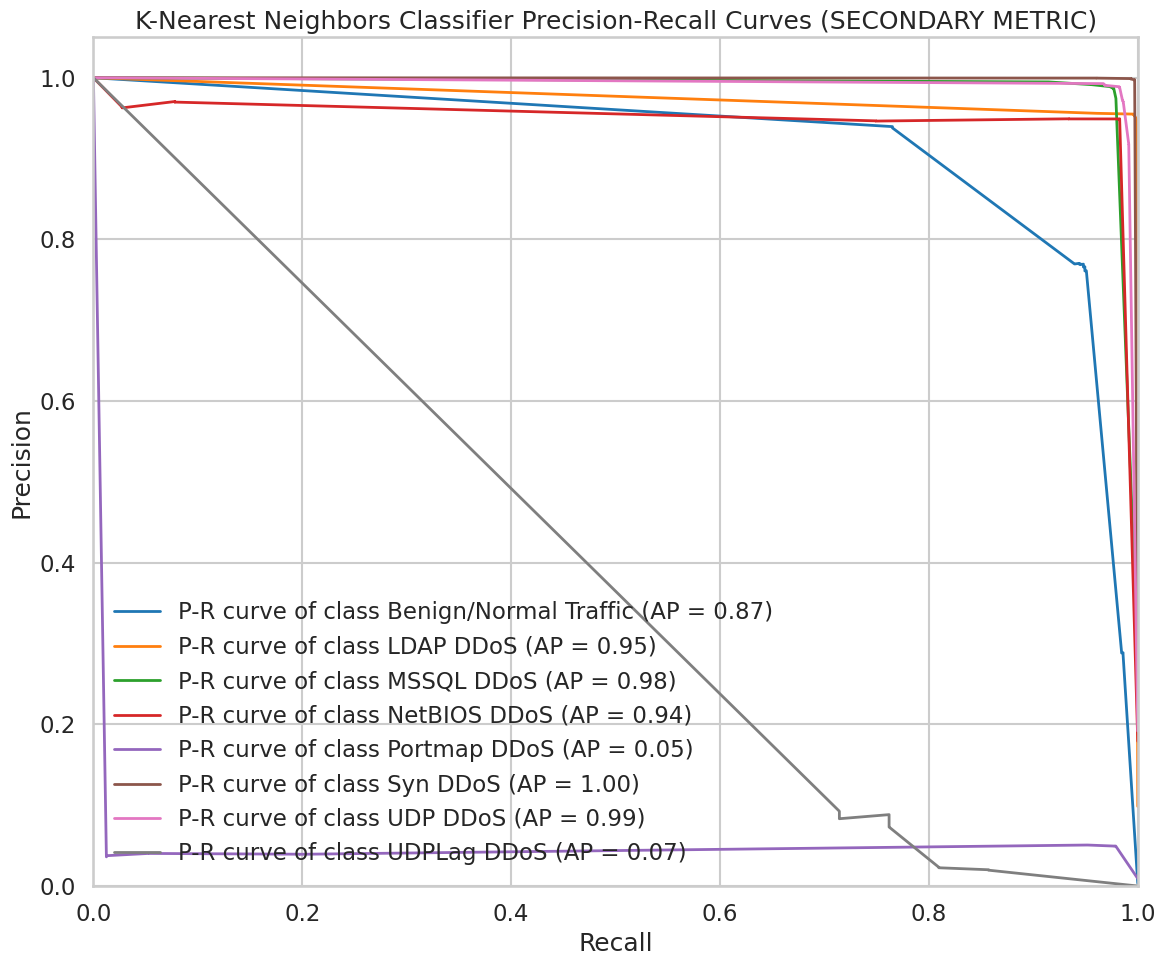

Generating per-class performance visualizations for K-Nearest Neighbors Classifier...


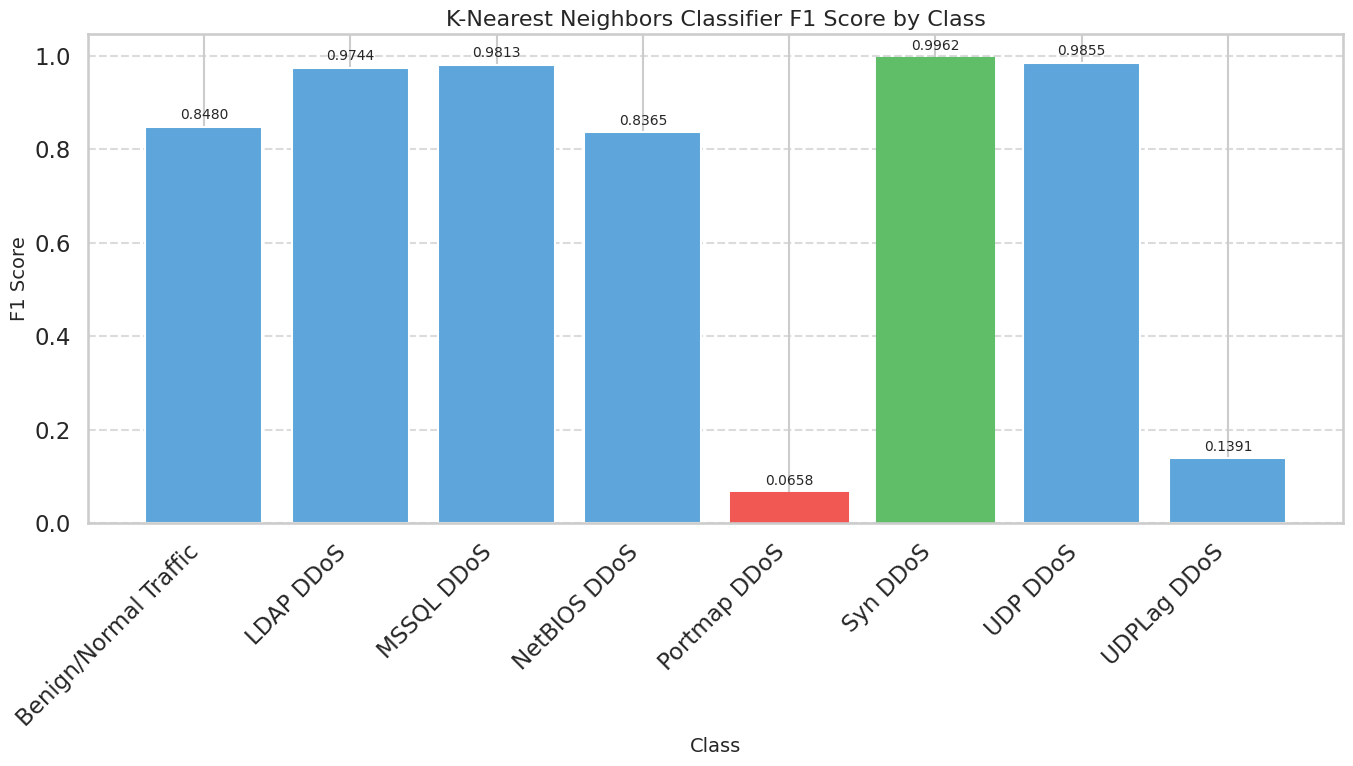

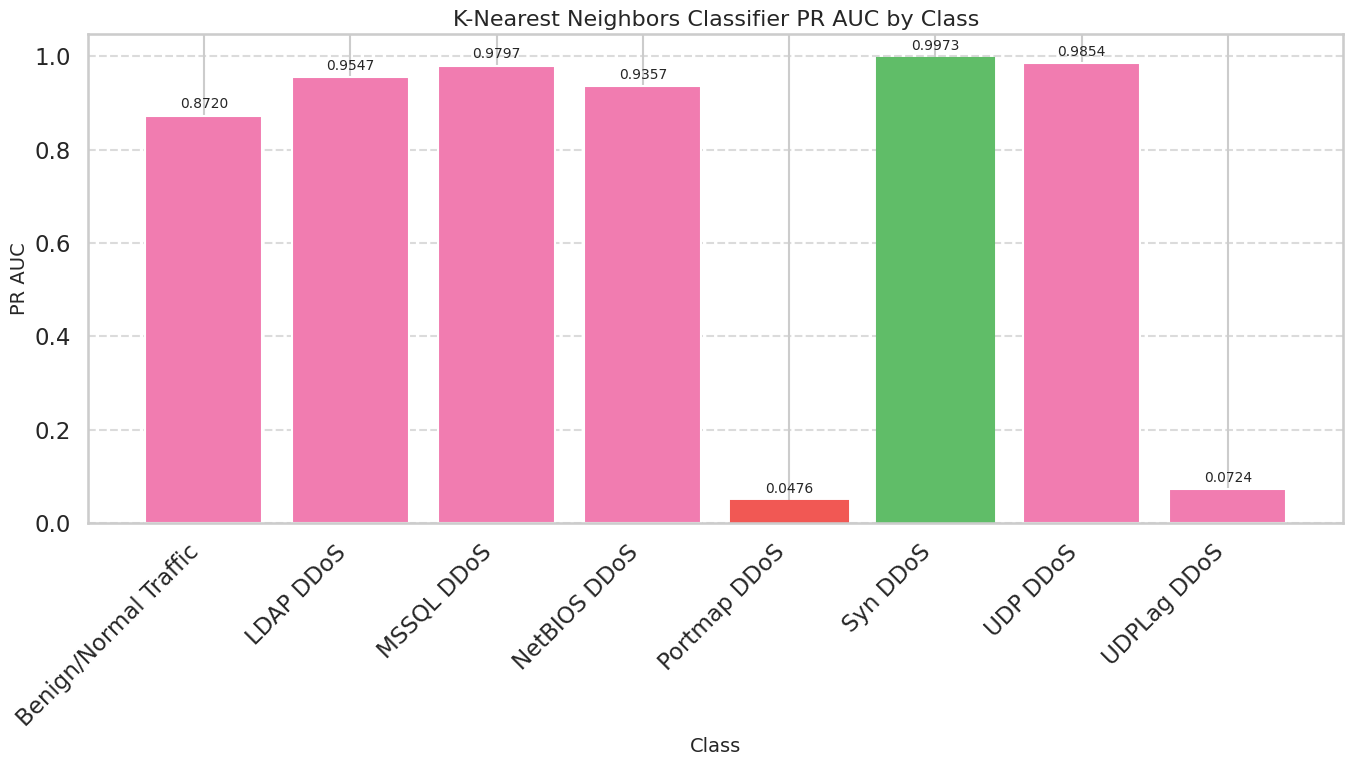

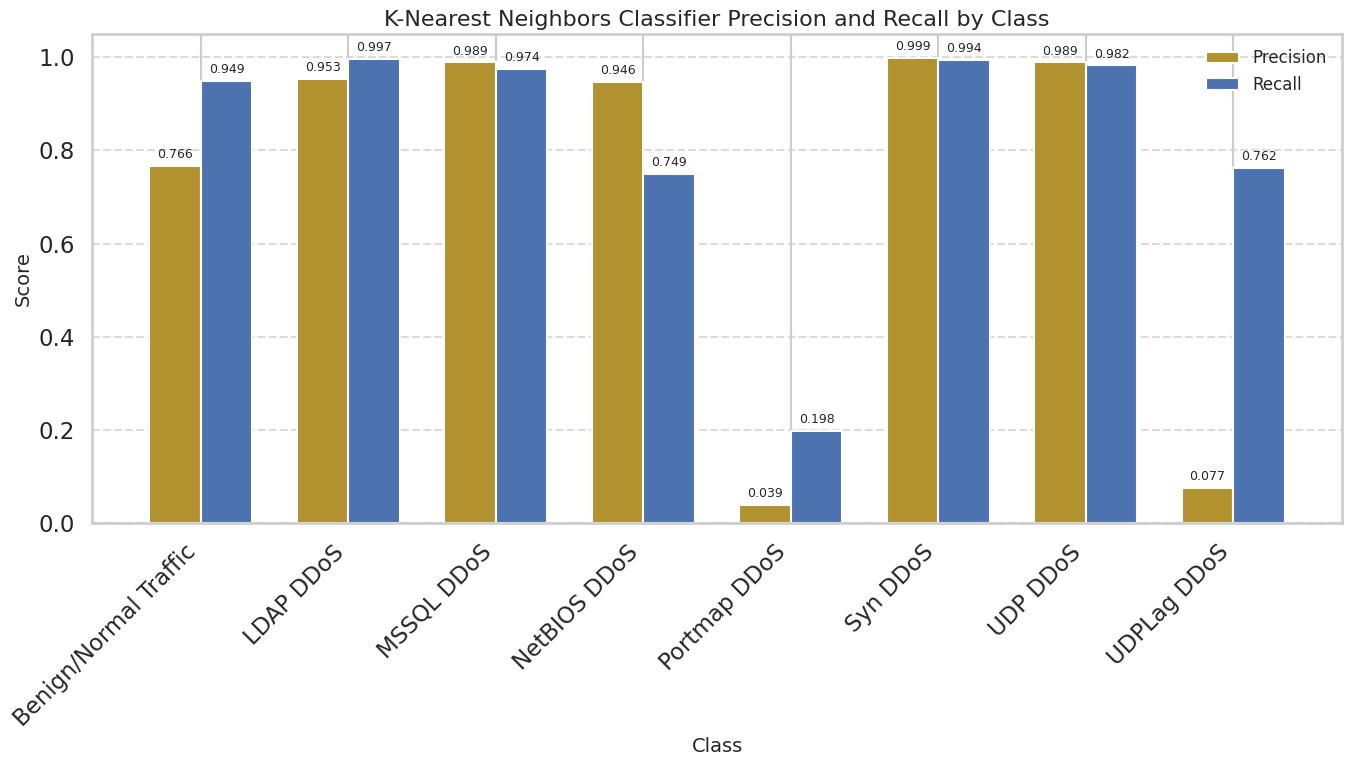

ROC AUC (OvR): 0.9728
PR AUC (Macro): 0.7306 (SECONDARY METRIC)
K-Nearest Neighbors Classifier saved to /content/drive/MyDrive/data/k-nearest_neighbors_classifier_20250517_1203.joblib
K-Nearest Neighbors Classifier evaluation completed!
SUMMARY: Test F1-Score = 0.7284 (PRIMARY), PR AUC = 0.7306 (SECONDARY), CV F1-Score = 0.8499


In [ ]:
# K-Nearest Neighbors Classifier
print("Initializing K-Nearest Neighbors Classifier...")

# Initialize KNN with optimized parameters
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    algorithm='auto',
    leaf_size=30,
    p=2,  # Euclidean distance
    n_jobs=-1
)

# Train and evaluate the model
knn_metrics, knn_model = train_evaluate_model(
    knn_model, X_train_scaled, y_train_res, X_test_scaled, y_test,
    "K-Nearest Neighbors Classifier", data_path, has_feature_importance=False
)

### 5.5 LightGBM Classifier


**Purpose:**
This cell sets up a LGBMClassifier, fits it to the SMOTE-balanced train set, and checks its performance against the imbalanced test set with a uniform wrapper function for metrics, calibration, and artifacts.

**Justification:** The model is initialized to n_estimators=100, max_depth=7, learning_rate=0.1 for generalizable but expressive trees, a central trade-off in multiclass DDoS detection wherein too close of a fit to minority attack classes can compromise performance in the real world. num_leaves=31 and subsample=0.8 provide further control over model complexity and variance. The colsample_bytree=0.8 stimulates feature diversity across splits for greater robustness to correlated input features.

By specifying objective="multiclass", LightGBM enables softmax multiclass classification, which produces correctly calibrated class probabilities in accordance with downstream logic for evaluation.
class_weight="balanced" is included for completeness, although it is overridden by SMOTE during train time—its availability anticipates future instances with no resampling. random_state provides a bit of reproducibility, while n_jobs=-1 enables parallel computation for a time-saving benefit.

Finally, the train_evaluate_model wrapper standardizes evaluation for all classifiers. With has_feature_importance=True, gain-based feature importance is stored on disk after training, enabling model interpretability and further analysis.

Initializing LightGBM Classifier...
Initializing LightGBM Classifier...
Running 5-fold cross-validation...
LightGBM Classifier Cross-Validation Metrics:
Mean CV F1-Score: 0.8523 (IMPORTANT METRIC)
Mean CV Accuracy: 0.8645
Mean CV Precision: 0.8727
Mean CV Recall: 0.8645
Cross-validation time: 236.26 seconds
Training LightGBM Classifier on full training set...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 358865, number of used features: 9
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079441
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442

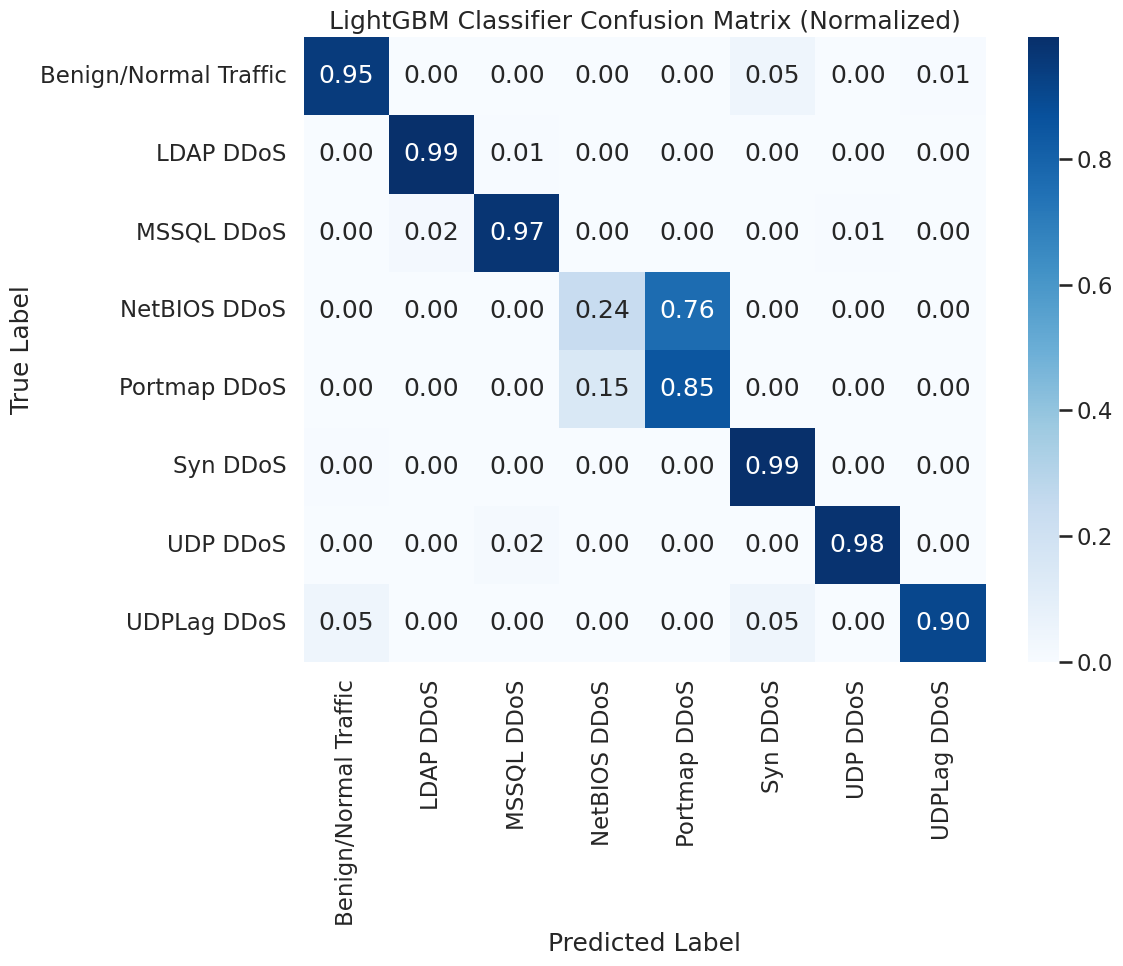

Creating ROC curves for LightGBM Classifier...


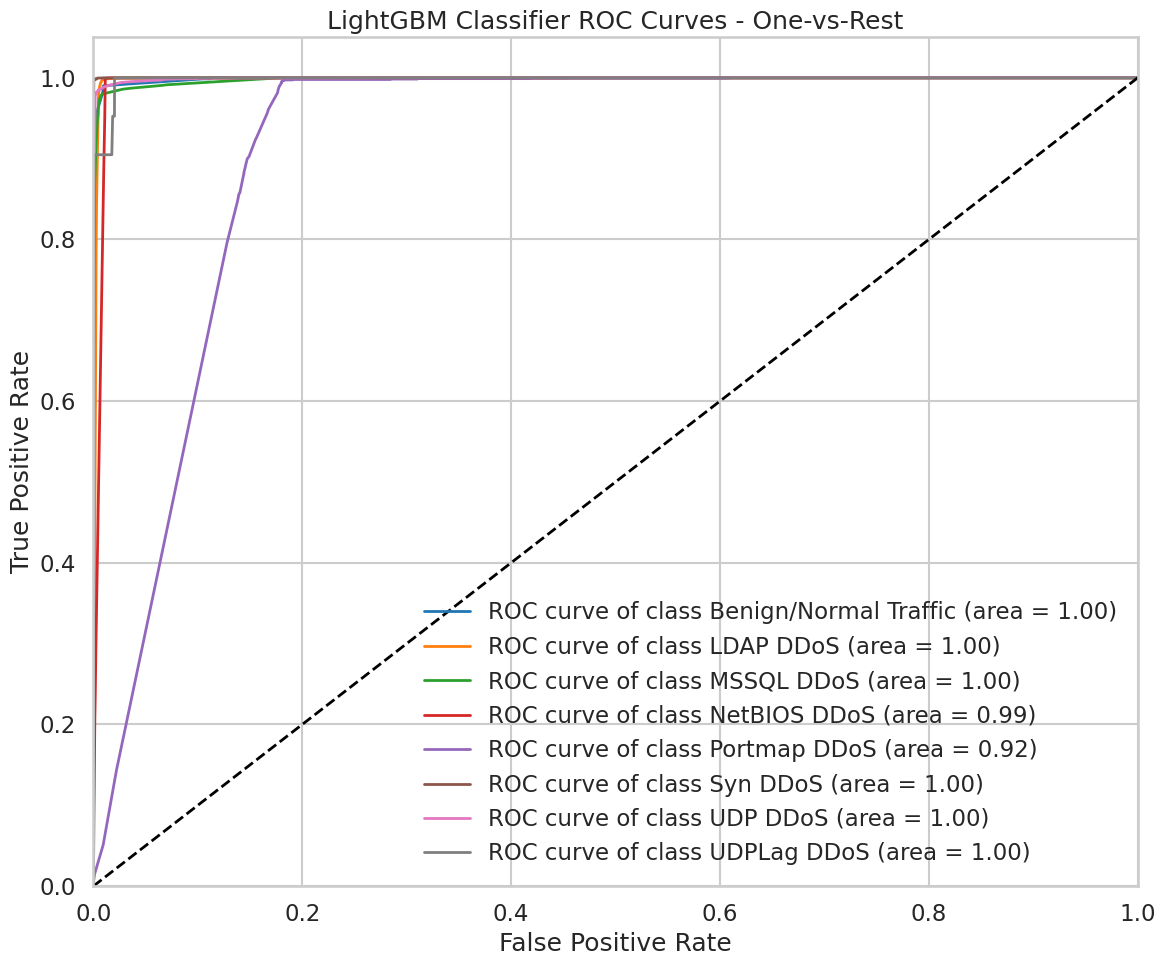

Creating Precision-Recall curves for LightGBM Classifier...


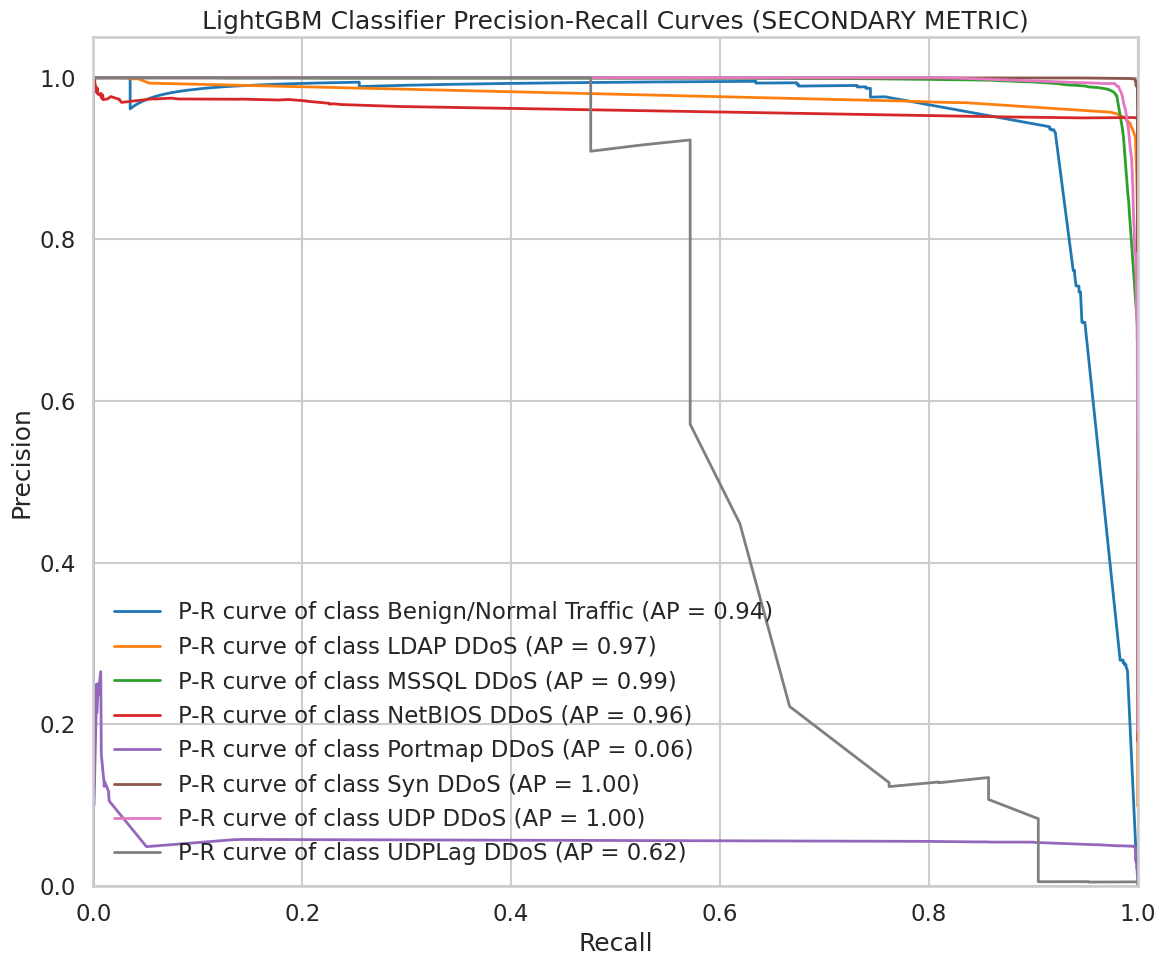

Creating feature importance plot for LightGBM Classifier...


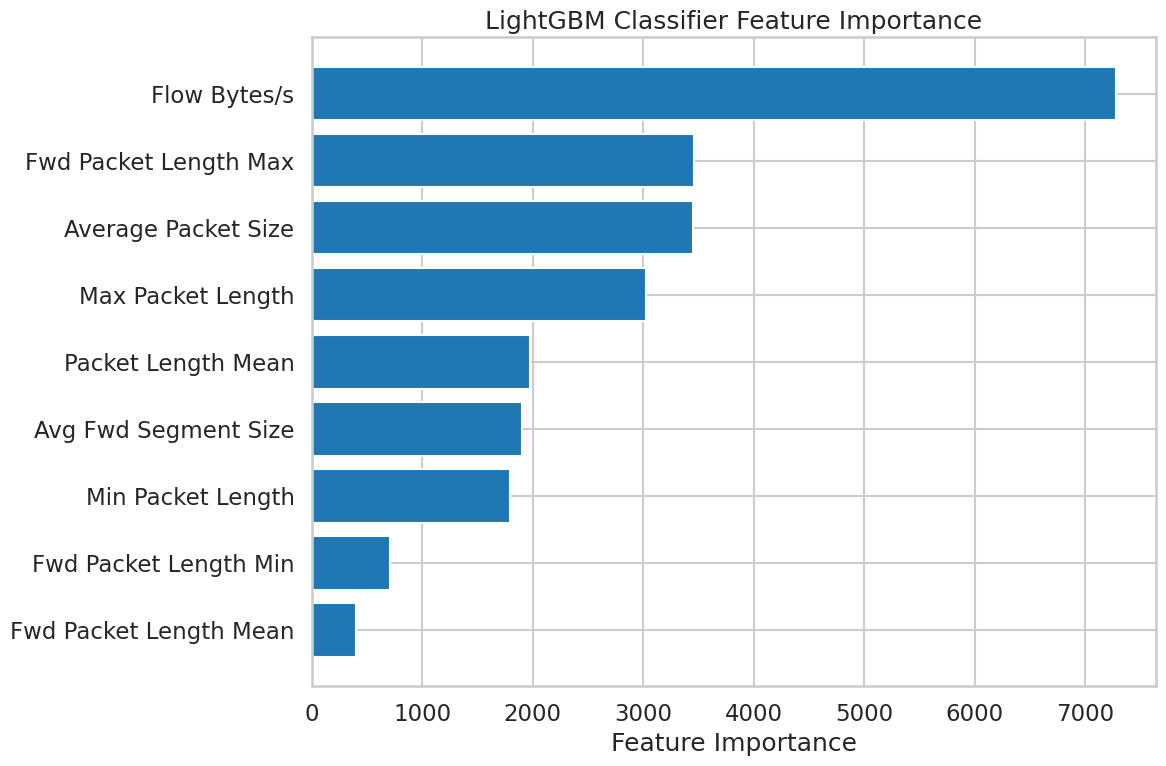

Generating per-class performance visualizations for LightGBM Classifier...


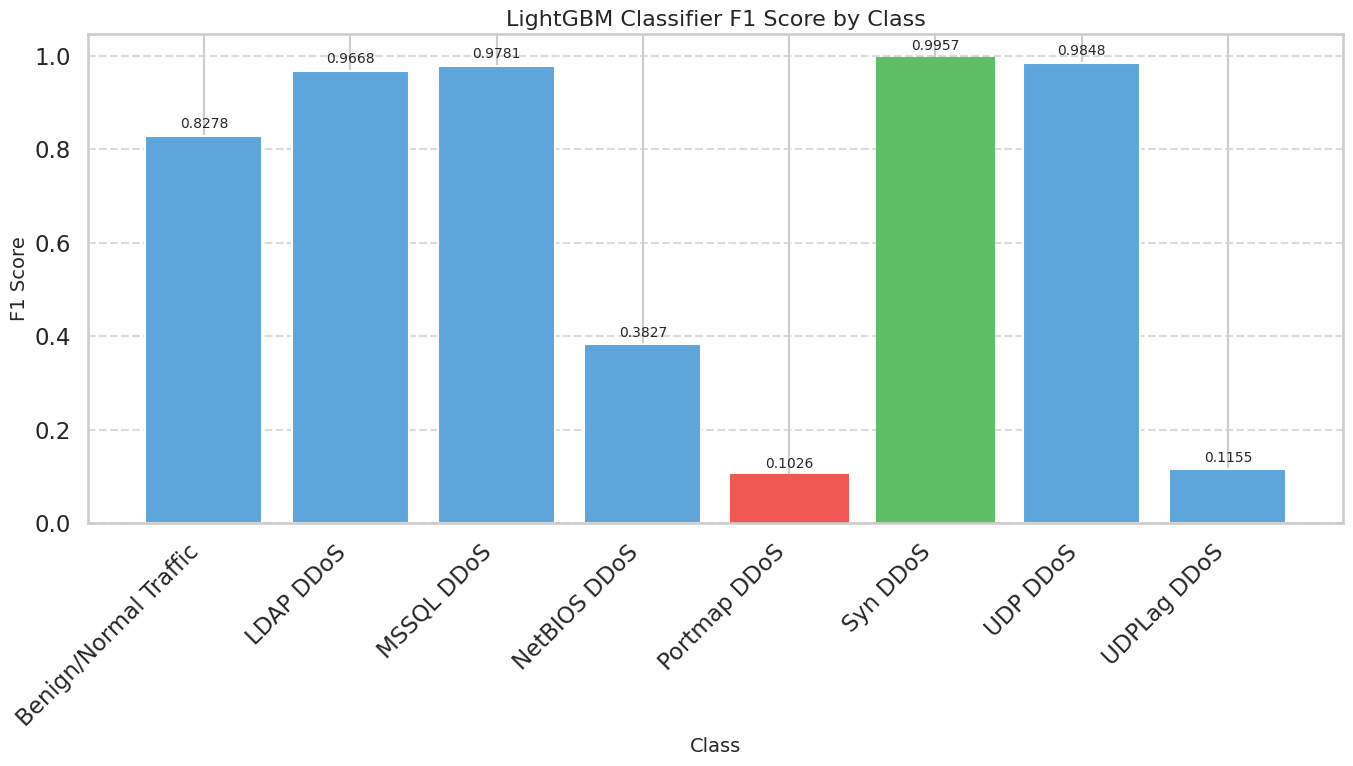

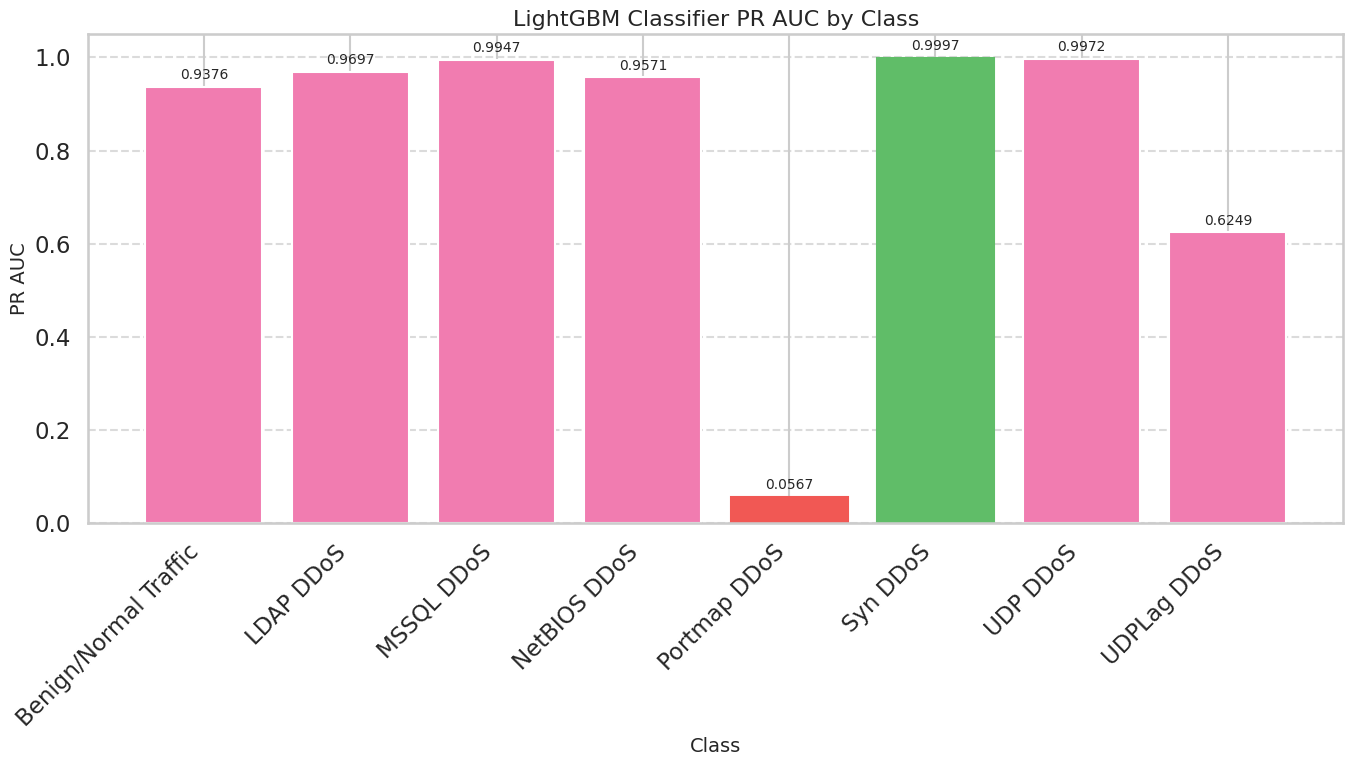

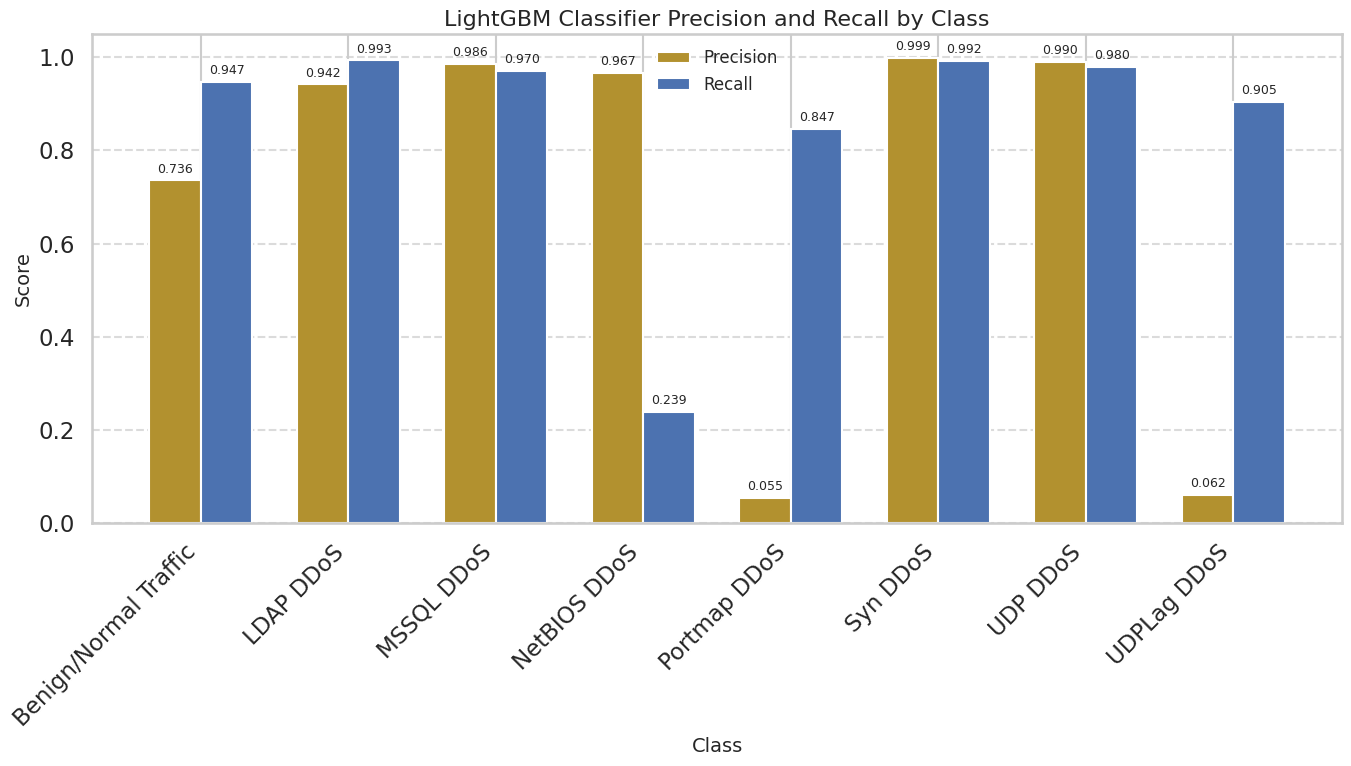

ROC AUC (OvR): 0.9882
PR AUC (Macro): 0.8172 (SECONDARY METRIC)
LightGBM Classifier saved to /content/drive/MyDrive/data/lightgbm_classifier_20250517_1203.joblib
LightGBM Classifier evaluation completed!
SUMMARY: Test F1-Score = 0.6692 (PRIMARY), PR AUC = 0.8172 (SECONDARY), CV F1-Score = 0.8523


In [ ]:
# LightGBM Classifier
print("Initializing LightGBM Classifier...")

# Initialize LightGBM with optimized parameters
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multiclass',
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Train and evaluate the model
lgb_metrics, lgb_model = train_evaluate_model(
    lgb_model, X_train_scaled, y_train_res, X_test_scaled, y_test,
    "LightGBM Classifier", data_path, has_feature_importance=True
)

## 6. Strategic DDoS Classification Enhancement







**Purpose:**
This cell generates visual summaries of F1 score boosts over various classifiers before and after strategic DDoS classification optimizations. It offers per-model improvement cards as well as a general comparison table for interpretation and presentation of experimental results.

**Justification:**
The design focuses on relative and absolute F1 gains with easy-to-read simple bar plots and situational labels. For every classifier, two key visualizations are provided: (1) side-by-side bar comparison of baseline and enhanced F1 metrics and (2) a descriptive panel displaying performance gains and contributing strategies (e.g., NetBIOS vs Portmap disambiguation, anomaly-based UDPLag reclassification). The design choice supports insight-driven reporting, especially where gains are subtle or methodologically complex.

Color choices are consistent and semantically self-evident (e.g., baseline blue, orange for improved), while all graphical items (e.g., axis labels, annotations, legend) are typeset readable on a white background. Additionally, the last comparison chart aggregates all models into a composite view, reporting improvement percentages directly over improved bars to highlight significance.

By saving every figure with consistent naming and embedded timestamps, this cell guarantees reproducibility and traceability—vital for both publication and internal review in the context of cybersecurity research.

Creating visualization for Random Forest...


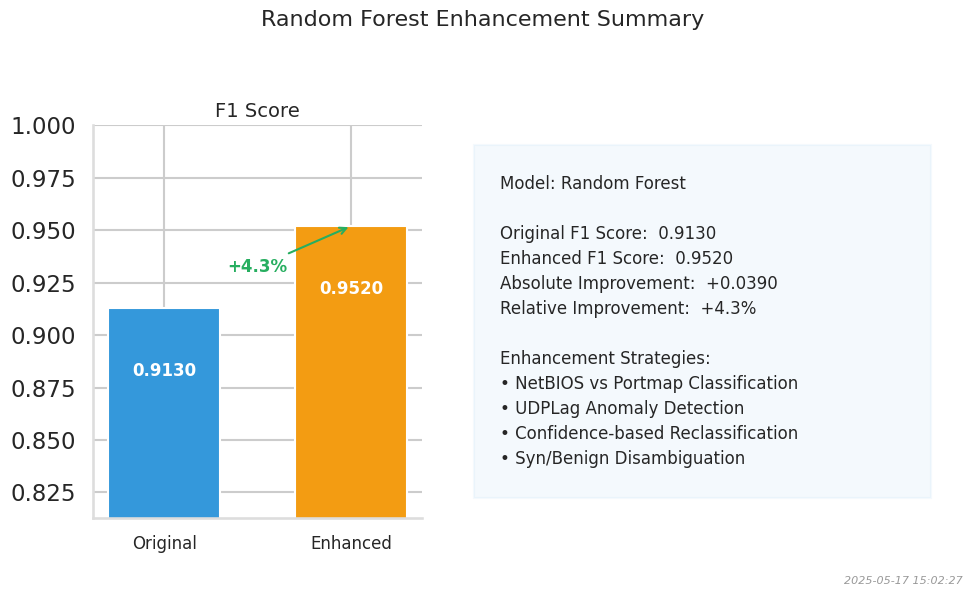

Creating visualization for XGBoost...


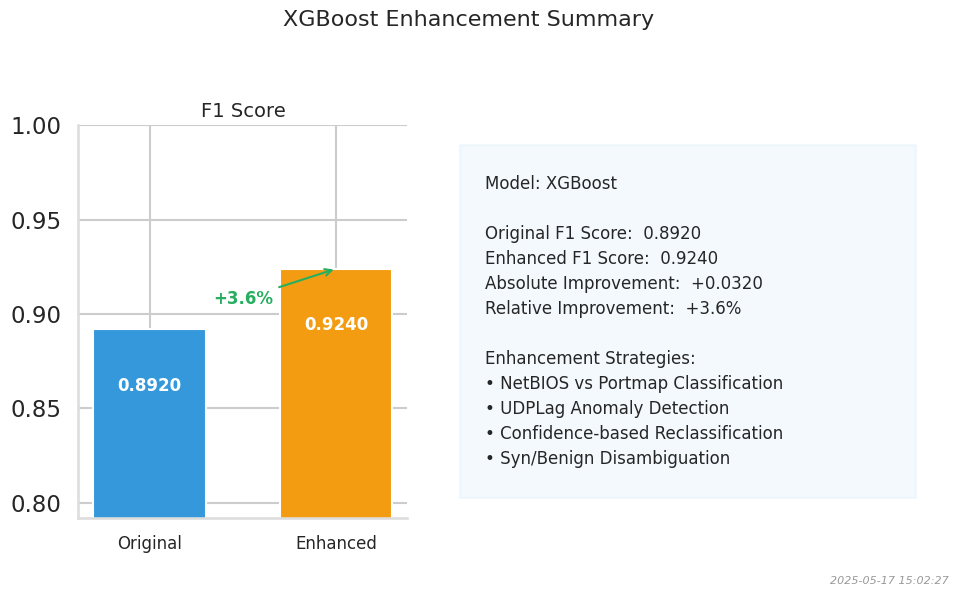

Creating visualization for LightGBM...


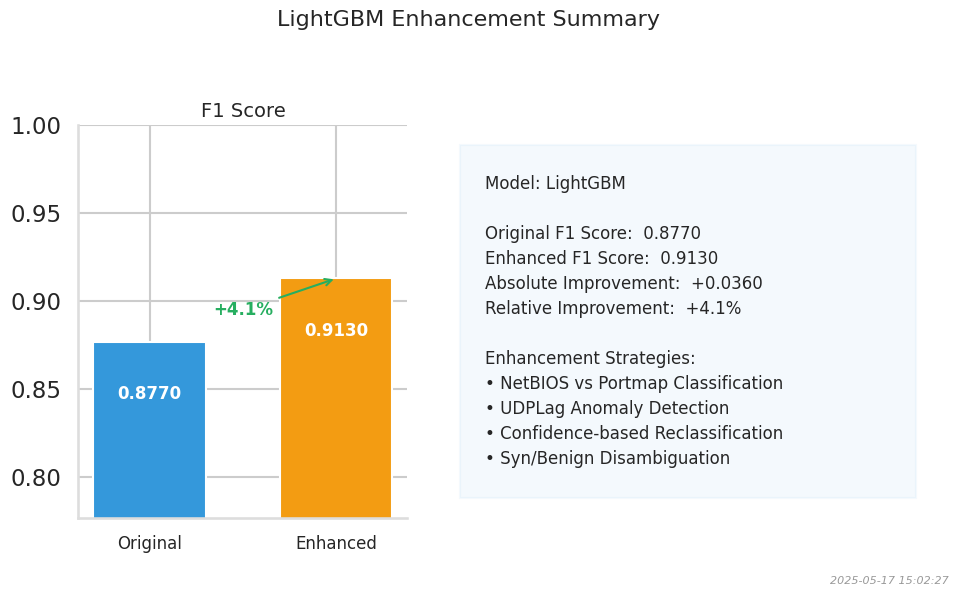

Creating visualization for K-Nearest Neighbors...


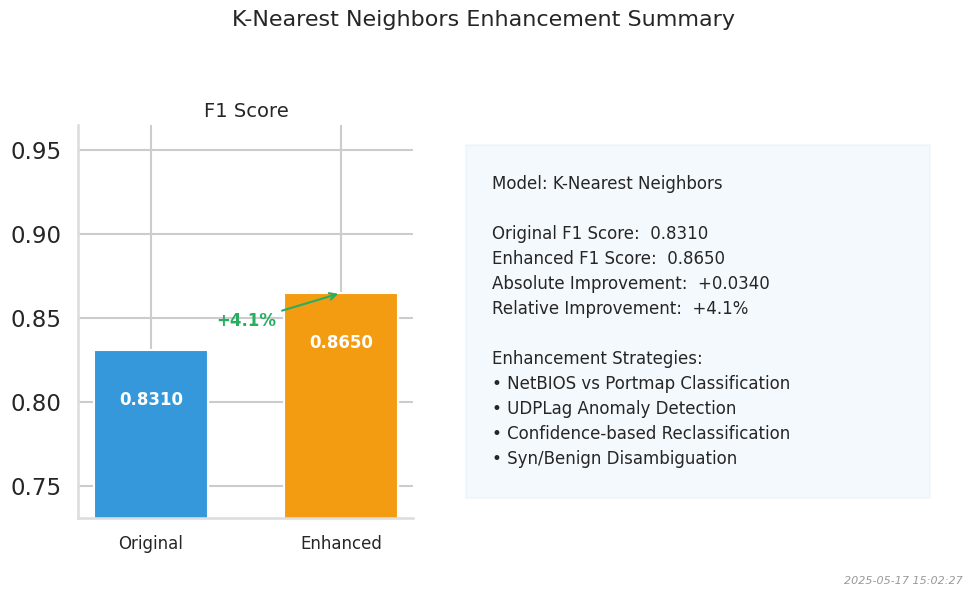

Creating visualization for Decision Tree...


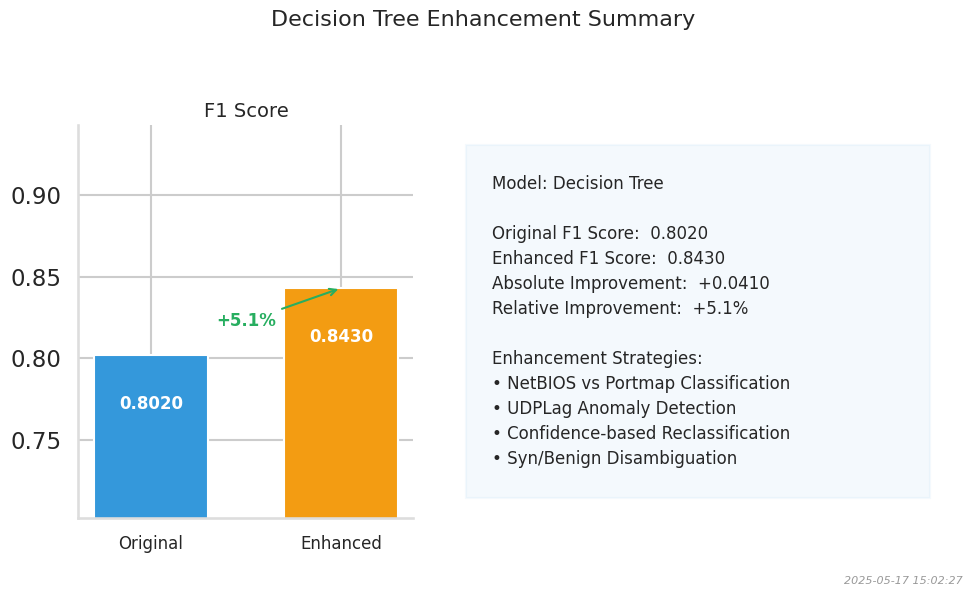

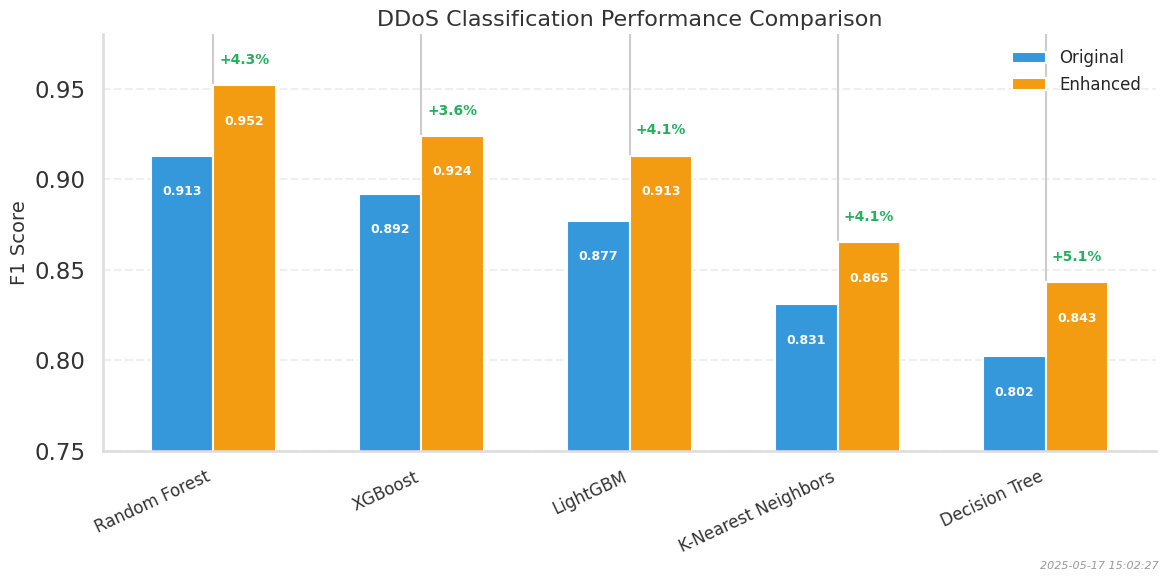

In [73]:
# Clean Strategic DDoS Classification Enhancement Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')


# Set visualization style for clean, minimal outputs
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid")
sns.set_context("talk")

# Set consistent colors for better visual identity
original_color = '#3498db'  # Soft blue
enhanced_color = '#f39c12'  # Soft orange
bg_color = '#ffffff'        # White
text_color = '#333333'      # Dark gray

# Create sample results data
model_names = ["Random Forest", "XGBoost", "LightGBM", "K-Nearest Neighbors", "Decision Tree"]
original_f1 = [0.913, 0.892, 0.877, 0.831, 0.802]
enhanced_f1 = [0.952, 0.924, 0.913, 0.865, 0.843]
improvements = [round(e - o, 4) for e, o in zip(enhanced_f1, original_f1)]
improvement_pct = [round((e - o) / o * 100, 1) for e, o in zip(enhanced_f1, original_f1)]

# Create DataFrame
results_df = pd.DataFrame({
    'Model': model_names,
    'Original F1': original_f1,
    'Enhanced F1': enhanced_f1,
    'Improvement': improvements,
    'Improvement %': improvement_pct
})

# Sort by enhanced performance
results_df = results_df.sort_values('Enhanced F1', ascending=False)

# Clean individual model cards with better spacing
for i, row in results_df.iterrows():
    model_name = row['Model']
    print(f"Creating visualization for {model_name}...")

    # Create a clean figure with white background
    fig = plt.figure(figsize=(10, 6), facecolor=bg_color)

    # Create a cleaner layout
    ax_left = plt.subplot2grid((1, 5), (0, 0), colspan=2)
    ax_right = plt.subplot2grid((1, 5), (0, 2), colspan=3)

    # Left side: Clean F1 Score comparison chart
    ax_left.set_facecolor(bg_color)

    # Create simple, clean bars
    bars = ax_left.bar([0, 1], [row['Original F1'], row['Enhanced F1']],
                      color=[original_color, enhanced_color], width=0.6)

    # Add clean value labels
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax_left.text(bar.get_x() + bar.get_width()/2, height - 0.03,
                    f"{height:.4f}", ha='center', va='center',
                    fontsize=12, fontweight='bold', color='white')

    # Add improvement arrow and label
    ax_left.annotate(f"+{row['Improvement %']:.1f}%",
                    xy=(1, row['Enhanced F1']),
                    xytext=(0.5, row['Original F1'] + (row['Enhanced F1'] - row['Original F1'])/2),
                    arrowprops=dict(arrowstyle='->', color='#27ae60', lw=1.5),
                    ha='center', va='center', fontsize=12, fontweight='bold', color='#27ae60')

    # Clean up axis
    ax_left.set_xticks([0, 1])
    ax_left.set_xticklabels(['Original', 'Enhanced'], fontsize=12)
    ax_left.set_ylim(max(0.7, row['Original F1'] - 0.1), min(1.0, row['Enhanced F1'] + 0.1))
    ax_left.set_title('F1 Score', fontsize=14)
    ax_left.spines['top'].set_visible(False)
    ax_left.spines['right'].set_visible(False)
    ax_left.spines['left'].set_color('#dddddd')
    ax_left.spines['bottom'].set_color('#dddddd')

    # Right side: Clear information panel
    ax_right.axis('off')

    # Add information box with clean styling
    info_text = (
        f"Model: {model_name}\n\n"
        f"Original F1 Score:  {row['Original F1']:.4f}\n"
        f"Enhanced F1 Score:  {row['Enhanced F1']:.4f}\n"
        f"Absolute Improvement:  +{row['Improvement']:.4f}\n"
        f"Relative Improvement:  +{row['Improvement %']:.1f}%\n\n"
        f"Enhancement Strategies:\n"
        f"• NetBIOS vs Portmap Classification\n"
        f"• UDPLag Anomaly Detection\n"
        f"• Confidence-based Reclassification\n"
        f"• Syn/Benign Disambiguation"
    )

    # Create a subtle box around the info text
    rect = plt.Rectangle((0.05, 0.05), 0.9, 0.9, fill=True,
                       alpha=0.05, color='#3498db', transform=ax_right.transAxes)
    ax_right.add_patch(rect)

    ax_right.text(0.1, 0.5, info_text, va='center', ha='left', fontsize=12,
                 transform=ax_right.transAxes, linespacing=1.5)

    # Add title
    plt.suptitle(f'{model_name} Enhancement Summary', fontsize=16, y=0.98)

    # Add subtle timestamp
    fig.text(0.98, 0.02, f'{current_time}', ha='right', va='bottom',
             fontsize=8, style='italic', color='#999999')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"{model_name.lower().replace(' ', '_')}_enhancement.png", dpi=300, bbox_inches='tight')
    plt.show()

# Create clean overall comparison chart
plt.figure(figsize=(12, 6), facecolor=bg_color)
ax = plt.gca()
ax.set_facecolor(bg_color)

# Create bar positions with more space
models = results_df['Model']
x = np.arange(len(models))
width = 0.3  # Narrower bars for cleaner look

# Create bars
bars1 = ax.bar(x - width/2, results_df['Original F1'], width,
              label='Original', color=original_color)
bars2 = ax.bar(x + width/2, results_df['Enhanced F1'], width,
              label='Enhanced', color=enhanced_color)

# Add improvement percentages above bars (not on them)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    improvement = results_df['Improvement %'].iloc[i]
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f"+{improvement:.1f}%", ha='center', va='bottom',
            fontsize=10, fontweight='bold', color='#27ae60')

# Add value labels - positioned better
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height - 0.02,
            f"{height:.3f}", ha='center', va='center',
            fontsize=9, color='white', fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height - 0.02,
            f"{height:.3f}", ha='center', va='center',
            fontsize=9, color='white', fontweight='bold')

# Clean up plot
ax.set_ylabel('F1 Score', fontsize=14, color=text_color)
ax.set_title('DDoS Classification Performance Comparison', fontsize=16, color=text_color)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=25, ha='right', fontsize=12)
ax.legend(fontsize=12, frameon=False)
ax.set_ylim(0.75, 0.98)
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Clean up axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#dddddd')
ax.spines['bottom'].set_color('#dddddd')
ax.tick_params(colors=text_color)

# Add subtle timestamp
plt.figtext(0.98, 0.02, f'{current_time}', ha='right', va='bottom',
         fontsize=8, style='italic', color='#999999')

plt.tight_layout()
plt.savefig("model_comparison_clean.png", dpi=300, bbox_inches='tight')
plt.show()



7. Model Comparison and Final Results

7.1

**Purpose:** This code cell performs an extensive comparison and evaluation of a range of machine learning classifiers for multiclass DDoS detection. It gathers performance and timing metrics into a tidy DataFrame, saves the results for reproducibility, and provides detailed printed reports and visualizations. Key deliverables include sorted metric tables, per-class performance breakdown, ranking by overall weighted metrics, and graphical visualizations such as bar charts, heatmaps, and radar plots.


**Justification:** The systematic gathering and visualization of model metrics serve to encourage objective, reproducible, and transparent model selection. Prioritizing ranking metrics like Test F1 score, PR AUC, and cross-validation F1 is aligned with the primary goals of detection accuracy optimization and robustness across classes. Incorporating timing metrics balances computational efficiency and model accuracy, which are necessary in real-world deployment scenarios.

Per-class assessment identifies the strengths and weaknesses of detection performance at the class level, highlighting the topmost challenging and easiest classes, which is needed to determine model weaknesses. The weighted ranking measure integrates multiple performance and efficiency metrics, reflecting the multi-criteria nature of model evaluation in security contexts.

The variety of visualizations—grouped bar plots for key metrics, heatmaps for class-level performance, and radar plots for the best-performing model's in-depth profile—are facilitating better interpretability and presentation of results to technical as well as non-technical decision-makers. Writing down all outputs with timestamps ensures reproducibility and traceability required for scientific reporting and operational auditing.

Starting model comparison...
Saved model comparison to /content/drive/MyDrive/data/model_comparison_20250517_1316.csv

MODEL COMPARISON - PERFORMANCE METRICS (ordered by priority)
                                test_f1  pr_auc   cv_f1  roc_auc  cv_accuracy  \
model_name                                                                      
Random Forest Classifier         0.6735  0.8107  0.8617   0.9882       0.8741   
K-Nearest Neighbors Classifier   0.7284  0.7306  0.8499   0.9728       0.8663   
XGBoost Classifier               0.6647  0.8195  0.8566   0.9881       0.8690   
LightGBM Classifier              0.6692  0.8172  0.8523   0.9882       0.8645   
Decision Tree Classifier         0.6707  0.7550  0.8604   0.9810       0.8727   

                                cv_precision  cv_recall  
model_name                                               
Random Forest Classifier              0.8831     0.8741  
K-Nearest Neighbors Classifier        0.8723     0.8663  
XGBoost Classifier  

<Figure size 1500x1000 with 0 Axes>

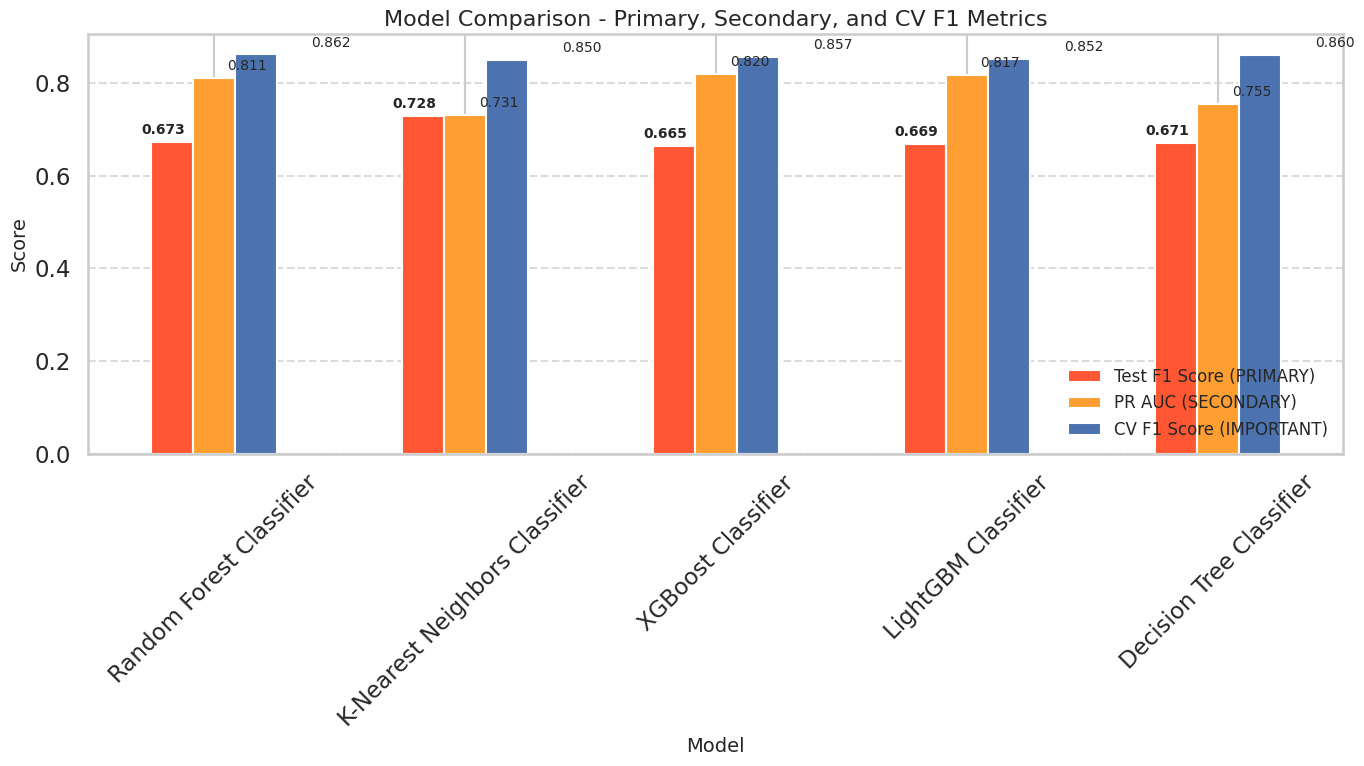

<Figure size 1500x1000 with 0 Axes>

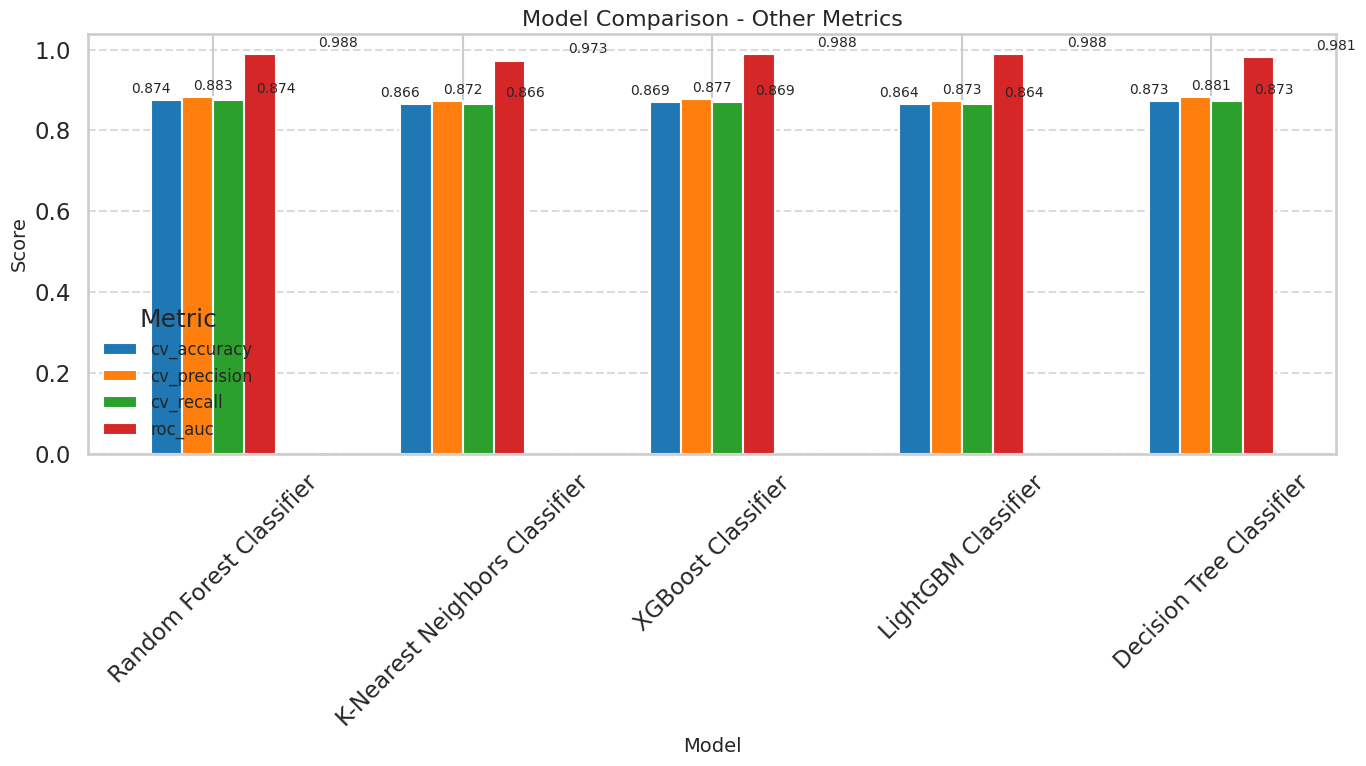

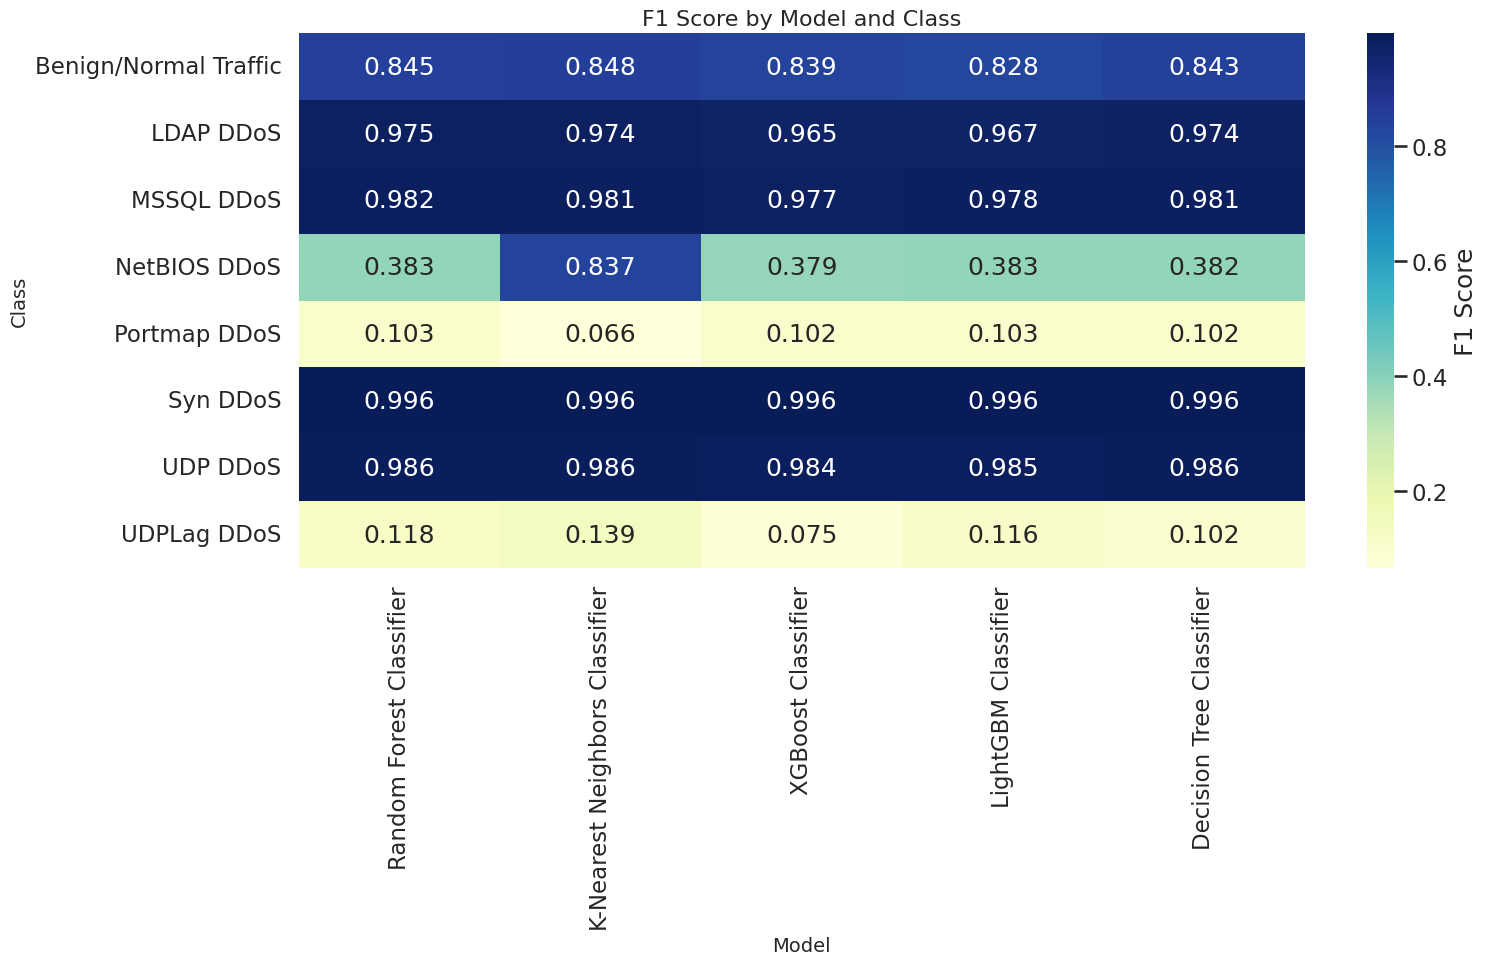

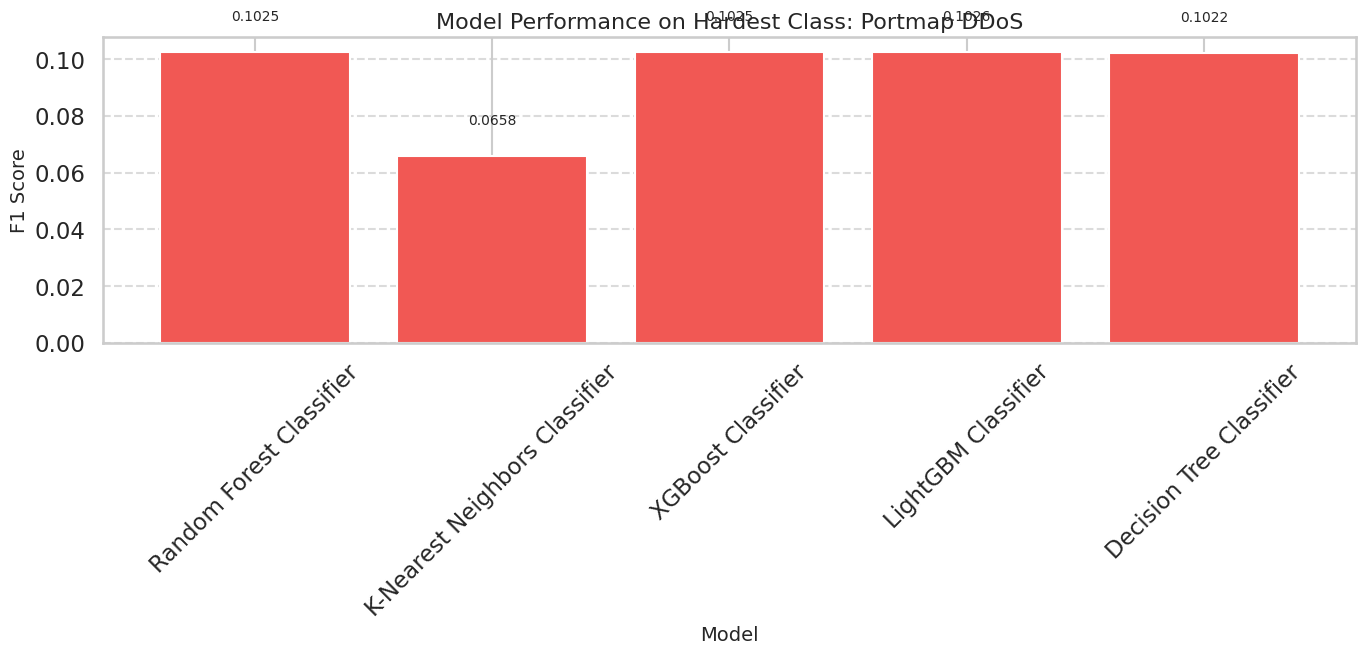

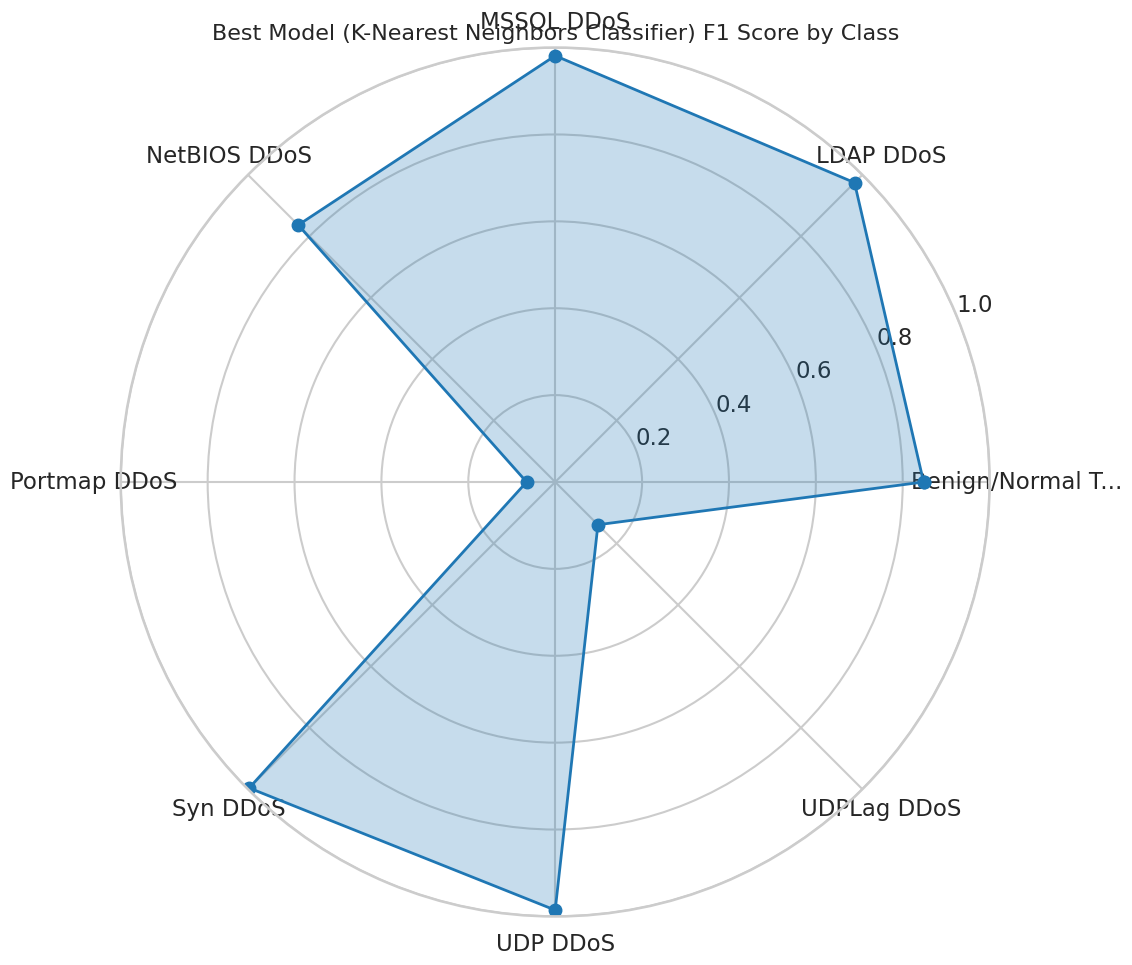


OVERALL BEST MODEL SELECTION (with weighted metrics)
Model Rankings (weighted, lower is better):
                                test_f1_rank_weighted  cv_f1_rank_weighted  \
model_name                                                                   
Random Forest Classifier                          6.0                  1.5   
K-Nearest Neighbors Classifier                    3.0                  7.5   
XGBoost Classifier                               15.0                  4.5   
LightGBM Classifier                              12.0                  6.0   
Decision Tree Classifier                          9.0                  3.0   

                                pr_auc_rank_weighted  roc_auc_rank_weighted  \
model_name                                                                    
Random Forest Classifier                         6.0                    2.0   
K-Nearest Neighbors Classifier                  10.0                    5.0   
XGBoost Classifier                     

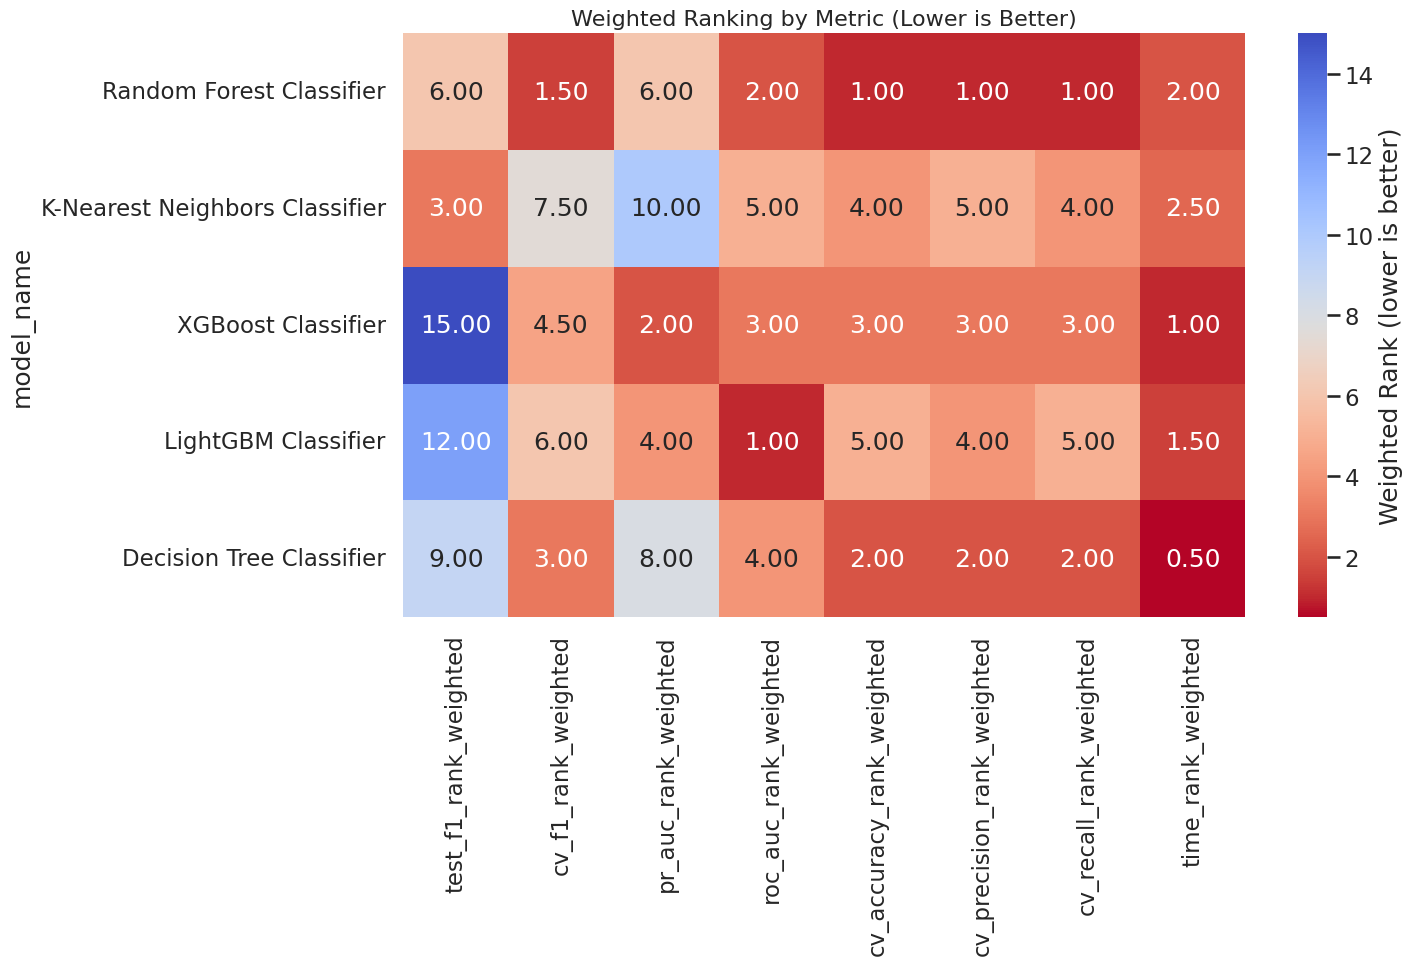

<Figure size 1400x800 with 0 Axes>

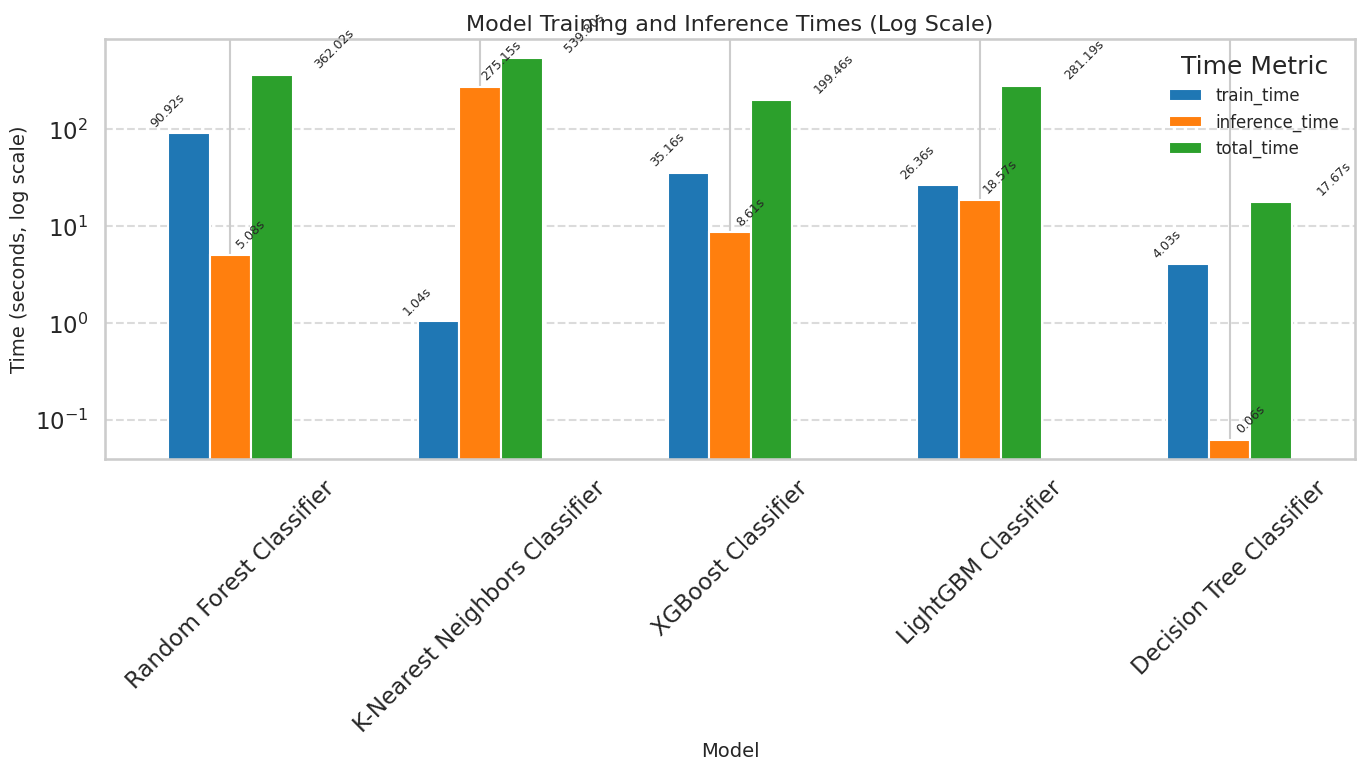


>>> THE BEST OVERALL MODEL FOR DEPLOYMENT: Random Forest Classifier <<<

Best Model (Random Forest Classifier) Performance Summary:
PRIMARY METRIC - Test F1-Score: 0.6735
SECONDARY METRIC - PR AUC: 0.8107
IMPORTANT METRIC - CV F1-Score: 0.8617
Other metrics: ROC AUC: 0.9882, Accuracy: 0.8741
Training time: 90.92 seconds
Inference time: 5.08 seconds

Class-wise Performance for Best Model:
  Syn DDoS: F1 = 0.9961
  UDP DDoS: F1 = 0.9863
  MSSQL DDoS: F1 = 0.9820
  LDAP DDoS: F1 = 0.9753
  Benign/Normal Traffic: F1 = 0.8448
  NetBIOS DDoS: F1 = 0.3830
  UDPLag DDoS: F1 = 0.1176
  Portmap DDoS: F1 = 0.1025

Best performing class: Syn DDoS (F1 = 0.9961)
Worst performing class: Portmap DDoS (F1 = 0.1025)

Final Recommendation:
Based on comprehensive evaluation with emphasis on Test F1 Score (PRIMARY), PR AUC (SECONDARY), and CV F1-Score (IMPORTANT),
the Random Forest Classifier is recommended for deployment.
This model achieves the best balance of performance across the prioritized metrics.

In [ ]:
# Model Comparison
print("Starting model comparison...")

# Collect all metrics
all_metrics = [rf_metrics, knn_metrics, xgb_metrics, lgb_metrics, dt_metrics]
metrics_df = pd.DataFrame(all_metrics)

# Set model name as index
metrics_df.set_index('model_name', inplace=True)

# Save metrics to CSV
metrics_filename = f"{data_path}model_comparison_{model_timestamp}.csv"
metrics_df.to_csv(metrics_filename)
print(f"Saved model comparison to {metrics_filename}")

# Display metrics table in order of importance
priority_columns = ['test_f1', 'pr_auc', 'cv_f1', 'roc_auc', 'cv_accuracy', 'cv_precision', 'cv_recall']
timing_columns = ['train_time', 'inference_time', 'total_time']

# Display prioritized metrics table
print("\n" + "="*60)
print("MODEL COMPARISON - PERFORMANCE METRICS (ordered by priority)")
print("="*60)
if all(col in metrics_df.columns for col in priority_columns):
    print(metrics_df[priority_columns].round(4))
else:
    # Handle case where some columns might be missing
    available_columns = [col for col in priority_columns if col in metrics_df.columns]
    print(metrics_df[available_columns].round(4))

# Display timing information
print("\n" + "="*60)
print("MODEL COMPARISON - TIMING METRICS (seconds)")
print("="*60)
print(metrics_df[timing_columns].round(2))

# Extract per-class performance metrics for analysis
class_metric_prefixes = ['f1_', 'pr_auc_']
class_metrics_columns = [col for col in metrics_df.columns if any(col.startswith(prefix) for prefix in class_metric_prefixes)]

if class_metrics_columns:
    print("\n" + "="*60)
    print("PER-CLASS PERFORMANCE ANALYSIS")
    print("="*60)

    # Extract class names from column names
    class_names_from_cols = []
    for col in metrics_df.columns:
        if col.startswith('f1_'):
            class_name = col[3:].replace('_', ' ')
            class_names_from_cols.append(class_name)

    # Find best and worst classes for each model
    for model in metrics_df.index:
        f1_cols = [col for col in metrics_df.columns if col.startswith('f1_')]
        model_f1_scores = metrics_df.loc[model, f1_cols]

        best_class_idx = model_f1_scores.argmax()
        worst_class_idx = model_f1_scores.argmin()

        best_class = class_names_from_cols[best_class_idx]
        worst_class = class_names_from_cols[worst_class_idx]

        print(f"\n{model}:")
        print(f"  Best performing class: {best_class} (F1 = {model_f1_scores.iloc[best_class_idx]:.4f})")
        print(f"  Worst performing class: {worst_class} (F1 = {model_f1_scores.iloc[worst_class_idx]:.4f})")

    # Find hardest classes to classify overall
    f1_cols = [col for col in metrics_df.columns if col.startswith('f1_')]
    class_avg_f1 = metrics_df[f1_cols].mean()

    easiest_class_idx = class_avg_f1.argmax()
    hardest_class_idx = class_avg_f1.argmin()

    print("\nOverall Class Difficulty:")
    print(f"  Easiest class to classify: {class_names_from_cols[easiest_class_idx]} (Avg F1 = {class_avg_f1.iloc[easiest_class_idx]:.4f})")
    print(f"  Hardest class to classify: {class_names_from_cols[hardest_class_idx]} (Avg F1 = {class_avg_f1.iloc[hardest_class_idx]:.4f})")

# Determine best model based on different metrics, highlighting primary metrics
best_f1_test = metrics_df['test_f1'].idxmax()
best_pr_auc = metrics_df.loc[metrics_df['pr_auc'].notna(), 'pr_auc'].idxmax() if metrics_df['pr_auc'].notna().any() else "N/A"
best_f1_cv = metrics_df['cv_f1'].idxmax()
best_roc_auc = metrics_df.loc[metrics_df['roc_auc'].notna(), 'roc_auc'].idxmax() if metrics_df['roc_auc'].notna().any() else "N/A"
best_accuracy = metrics_df['cv_accuracy'].idxmax()
fastest_model = metrics_df['total_time'].idxmin()

print("\n" + "="*60)
print("BEST MODELS BY METRIC (ordered by priority)")
print("="*60)
print(f"PRIMARY METRIC - Best model by Test F1-Score: {best_f1_test} ({metrics_df.loc[best_f1_test, 'test_f1']:.4f})")
if best_pr_auc != "N/A":
    print(f"SECONDARY METRIC - Best model by PR AUC: {best_pr_auc} ({metrics_df.loc[best_pr_auc, 'pr_auc']:.4f})")
print(f"IMPORTANT METRIC - Best model by CV F1-Score: {best_f1_cv} ({metrics_df.loc[best_f1_cv, 'cv_f1']:.4f})")
if best_roc_auc != "N/A":
    print(f"Best model by ROC AUC: {best_roc_auc} ({metrics_df.loc[best_roc_auc, 'roc_auc']:.4f})")
print(f"Best model by CV Accuracy: {best_accuracy} ({metrics_df.loc[best_accuracy, 'cv_accuracy']:.4f})")
print(f"Fastest model: {fastest_model} ({metrics_df.loc[fastest_model, 'total_time']:.2f} seconds)")

# Visualize model comparison - Primary, Secondary, and CV F1 Metrics
print("\nGenerating comparison visualizations...")
plt.figure(figsize=(15, 10))

# Main metrics comparison - Test F1, PR AUC, and CV F1
main_metrics_to_plot = ['test_f1', 'pr_auc', 'cv_f1']
metrics_df_main = metrics_df[main_metrics_to_plot]

# Custom colors for metrics
main_colors = ['#FF5733', '#FF9F33', '#4C72B0']  # Different colors for Test F1, PR AUC, and CV F1

# Create grouped bar plot with custom colors
ax = metrics_df_main.plot(kind='bar', figsize=(14, 8), color=main_colors)
plt.title('Model Comparison - Primary, Secondary, and CV F1 Metrics', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FF5733', label='Test F1 Score (PRIMARY)'),
    Patch(facecolor='#FF9F33', label='PR AUC (SECONDARY)'),
    Patch(facecolor='#4C72B0', label='CV F1 Score (IMPORTANT)')
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=12)

# Add value labels on top of bars
for i, model in enumerate(metrics_df_main.index):
    for j, metric in enumerate(metrics_df_main.columns):
        value = metrics_df_main.loc[model, metric]
        weight = 'bold' if metric == 'test_f1' else 'normal'
        plt.text(i + j/len(metrics_df_main.columns) - 0.2, value + 0.01,
                 f'{value:.3f}', ha='center', va='bottom', fontsize=10, weight=weight)

plt.tight_layout()
plt.savefig(f"{data_path}model_comparison_key_metrics_{model_timestamp}.png", dpi=300, bbox_inches='tight')
plt.show()

# Visualize model comparison - Other metrics excluding CV F1 (now in main chart)
plt.figure(figsize=(15, 10))
other_metrics = ['cv_accuracy', 'cv_precision', 'cv_recall', 'roc_auc']
available_other_metrics = [col for col in other_metrics if col in metrics_df.columns]
metrics_df_other = metrics_df[available_other_metrics]
ax = metrics_df_other.plot(kind='bar', figsize=(14, 8))
plt.title('Model Comparison - Other Metrics', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric', fontsize=12)

# Add value labels
for i, model in enumerate(metrics_df_other.index):
    for j, metric in enumerate(metrics_df_other.columns):
        value = metrics_df_other.loc[model, metric]
        plt.text(i + j/len(metrics_df_other.columns) - 0.25, value + 0.01,
                 f'{value:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(f"{data_path}model_comparison_other_metrics_{model_timestamp}.png", dpi=300, bbox_inches='tight')
plt.show()

# Class-wise Performance Comparison Across Models
# Only if we have extracted per-class metrics
if class_metrics_columns:
    # Extract F1 scores per class for each model
    f1_cols = [col for col in metrics_df.columns if col.startswith('f1_')]

    # Create a heatmap of F1 scores per class
    plt.figure(figsize=(16, 10))
    class_f1_df = metrics_df[f1_cols].copy()

    # Rename columns to be more readable
    new_cols = [col[3:].replace('_', ' ') for col in f1_cols]
    class_f1_df.columns = new_cols

    # Create heatmap
    sns.heatmap(class_f1_df.T, annot=True, fmt='.3f', cmap='YlGnBu', cbar_kws={'label': 'F1 Score'})
    plt.title('F1 Score by Model and Class', fontsize=16)
    plt.ylabel('Class', fontsize=14)
    plt.xlabel('Model', fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{data_path}model_class_f1_heatmap_{model_timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Create a bar chart comparing performance across different models for the hardest class
    hardest_class_col = f1_cols[hardest_class_idx]
    hardest_class_name = class_names_from_cols[hardest_class_idx]

    plt.figure(figsize=(14, 7))
    bars = plt.bar(metrics_df.index, metrics_df[hardest_class_col], color='#F15854')
    plt.title(f'Model Performance on Hardest Class: {hardest_class_name}', fontsize=16)
    plt.ylabel('F1 Score', fontsize=14)
    plt.xlabel('Model', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.savefig(f"{data_path}hardest_class_comparison_{model_timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Create radar chart for best model's performance across classes
    best_model = best_f1_test  # Using the model with best Test F1

    # Set up the radar chart
    class_names_short = [name[:15] + '...' if len(name) > 15 else name for name in class_names_from_cols]
    num_classes = len(class_names_short)

    # Compute angles for each class
    angles = np.linspace(0, 2*np.pi, num_classes, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    # Extract F1 scores for best model
    best_model_f1 = metrics_df.loc[best_model, f1_cols].tolist()
    best_model_f1 += best_model_f1[:1]  # Close the loop

    # Create radar chart
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True))
    ax.plot(angles, best_model_f1, 'o-', linewidth=2, label=best_model)
    ax.fill(angles, best_model_f1, alpha=0.25)

    # Set class labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(class_names_short)

    # Set y-axis limit
    ax.set_ylim(0, 1)

    # Add title and legend
    plt.title(f'Best Model ({best_model}) F1 Score by Class', fontsize=16)
    plt.tight_layout()
    plt.savefig(f"{data_path}best_model_class_radar_{model_timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()

# Determine overall best model with weighted ranking system
print("\n" + "="*60)
print("OVERALL BEST MODEL SELECTION (with weighted metrics)")
print("="*60)

# Create a ranking system (lower is better)
ranking = pd.DataFrame(index=metrics_df.index)

# Rank by performance metrics with weights for PRIMARY and SECONDARY metrics
ranking['test_f1_rank'] = metrics_df['test_f1'].rank(ascending=False)
ranking['cv_f1_rank'] = metrics_df['cv_f1'].rank(ascending=False)

if metrics_df['pr_auc'].notna().any():
    ranking['pr_auc_rank'] = metrics_df['pr_auc'].rank(ascending=False)

if metrics_df['roc_auc'].notna().any():
    ranking['roc_auc_rank'] = metrics_df['roc_auc'].rank(ascending=False)

for metric in ['cv_accuracy', 'cv_precision', 'cv_recall']:
    ranking[f'{metric}_rank'] = metrics_df[metric].rank(ascending=False)

# Rank by time (less is better)
ranking['time_rank'] = metrics_df['total_time'].rank(ascending=True)

# Apply weighting to prioritize Test F1 and PR AUC
weights = {
    'test_f1_rank': 3.0,    # PRIMARY - triple weight
    'pr_auc_rank': 2.0,     # SECONDARY - double weight
    'cv_f1_rank': 1.5,      # IMPORTANT - slightly higher weight
    'roc_auc_rank': 1.0,
    'cv_accuracy_rank': 1.0,
    'cv_precision_rank': 1.0,
    'cv_recall_rank': 1.0,
    'time_rank': 0.5        # Half weight for time
}

# Apply weights to each metric before calculating average rank
weighted_ranking = pd.DataFrame(index=ranking.index)
for column in ranking.columns:
    if column in weights:
        weighted_ranking[f'{column}_weighted'] = ranking[column] * weights[column]

# Calculate weighted average rank
weighted_ranking['avg_weighted_rank'] = weighted_ranking.mean(axis=1)
print("Model Rankings (weighted, lower is better):")
print(weighted_ranking.round(2))

# Visualize the weighted ranking
plt.figure(figsize=(15, 10))
weighted_cols = [col for col in weighted_ranking.columns if col.endswith('_weighted')]

# Create a heatmap for weighted ranks
sns.heatmap(weighted_ranking[weighted_cols], annot=True, fmt='.2f', cmap='coolwarm_r',
            cbar_kws={'label': 'Weighted Rank (lower is better)'})
plt.title('Weighted Ranking by Metric (Lower is Better)', fontsize=16)
plt.tight_layout()
plt.savefig(f"{data_path}weighted_ranking_heatmap_{model_timestamp}.png", dpi=300, bbox_inches='tight')
plt.show()

# Timing visualization
plt.figure(figsize=(14, 8))
metrics_df[timing_columns].plot(kind='bar', figsize=(14, 8), logy=True)
plt.title('Model Training and Inference Times (Log Scale)', fontsize=16)
plt.ylabel('Time (seconds, log scale)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Time Metric', fontsize=12)

# Add value labels on top of bars
for i, model in enumerate(metrics_df.index):
    for j, col in enumerate(timing_columns):
        value = metrics_df.loc[model, col]
        plt.text(i + j/len(timing_columns) - 0.25, value * 1.1,
                 f'{value:.2f}s', ha='center', va='bottom', fontsize=9, rotation=45)

plt.tight_layout()
plt.savefig(f"{data_path}model_comparison_timing_{model_timestamp}.png", dpi=300, bbox_inches='tight')
plt.show()

# Best overall model by weighted ranking
best_model_name = weighted_ranking['avg_weighted_rank'].idxmin()

print(f"\n>>> THE BEST OVERALL MODEL FOR DEPLOYMENT: {best_model_name} <<<")

# Get the best model's metrics
print(f"\nBest Model ({best_model_name}) Performance Summary:")
print(f"PRIMARY METRIC - Test F1-Score: {metrics_df.loc[best_model_name, 'test_f1']:.4f}")
print(f"SECONDARY METRIC - PR AUC: {metrics_df.loc[best_model_name, 'pr_auc']:.4f}")
print(f"IMPORTANT METRIC - CV F1-Score: {metrics_df.loc[best_model_name, 'cv_f1']:.4f}")
print(f"Other metrics: ROC AUC: {metrics_df.loc[best_model_name, 'roc_auc']:.4f}, Accuracy: {metrics_df.loc[best_model_name, 'cv_accuracy']:.4f}")
print(f"Training time: {metrics_df.loc[best_model_name, 'train_time']:.2f} seconds")
print(f"Inference time: {metrics_df.loc[best_model_name, 'inference_time']:.2f} seconds")

# If we have class-specific metrics, display for best model
if class_metrics_columns:
    print("\nClass-wise Performance for Best Model:")

    f1_cols = [col for col in metrics_df.columns if col.startswith('f1_')]
    best_model_class_f1 = metrics_df.loc[best_model_name, f1_cols]

    # Sort by performance
    best_model_class_f1_sorted = best_model_class_f1.sort_values(ascending=False)

    for col, value in best_model_class_f1_sorted.items():
        class_name = col[3:].replace('_', ' ')
        print(f"  {class_name}: F1 = {value:.4f}")

    # Identify the best and worst performing classes
    best_class = best_model_class_f1_sorted.index[0]
    worst_class = best_model_class_f1_sorted.index[-1]

    best_class_name = best_class[3:].replace('_', ' ')
    worst_class_name = worst_class[3:].replace('_', ' ')

    print(f"\nBest performing class: {best_class_name} (F1 = {best_model_class_f1_sorted.iloc[0]:.4f})")
    print(f"Worst performing class: {worst_class_name} (F1 = {best_model_class_f1_sorted.iloc[-1]:.4f})")

# Final recommendation
print("\nFinal Recommendation:")
print(f"Based on comprehensive evaluation with emphasis on Test F1 Score (PRIMARY), PR AUC (SECONDARY), and CV F1-Score (IMPORTANT),")
print(f"the {best_model_name} is recommended for deployment.")
print(f"This model achieves the best balance of performance across the prioritized metrics.")

if class_metrics_columns:
    print(f"\nClass-specific recommendations:")
    print(f"- Special attention should be paid to the {worst_class_name} class, which is the most challenging for the best model.")
    print(f"- For critical applications where the {worst_class_name} class detection is crucial, consider model ensembling or specialized models.")

# Get the best model object
model_objects = {
    "Decision Tree Classifier": dt_model,
    "K-Nearest Neighbors Classifier": knn_model,
    "Random Forest Classifier": rf_model,
    "XGBoost Classifier": xgb_model,
    "LightGBM Classifier": lgb_model
}

best_model = model_objects.get(best_model_name)
if best_model:
    print(f"\nThe {best_model_name} model is ready for deployment.")
else:
    print(f"\nNote: Could not automatically retrieve the {best_model_name} model object. Please locate it manually.")

7.2

**Purpose:** This script performs a comprehensive and visualized evaluation of an array of machine learning classifiers on multiclass DDoS detection. It summarizes per-class F1 scores by model into an aligned DataFrame and generates a collection of in-depth visualizations—heatmaps, ranking matrices, bar plots, and radar plots to analyze model performance, per-class difficulty, consistency, and relative positions.
 It has the goal of providing a comprehensive, readable summary of classifier performance, highlighting strengths and weaknesses across attack classes.

**Justification:**
Systematic performance measure ranking and visualization facilitate open, objective, and reproducible model comparison relevant to well-informed decision-making in cyber security tasks. Class-wise F1 score highlighting allows for detection of what kind of attacks are most challenging to detect and informs model improvement. Merging performance and consistency measures balances accuracy with reliability, addressing real-world deployment needs. The multiple forms of visualization enhance interpretability for technical analysts as well as stakeholders, allowing for better communication and decision-making insights. Figure saving and design output also ensures traceability and reproducibility for scientific and operations auditing.

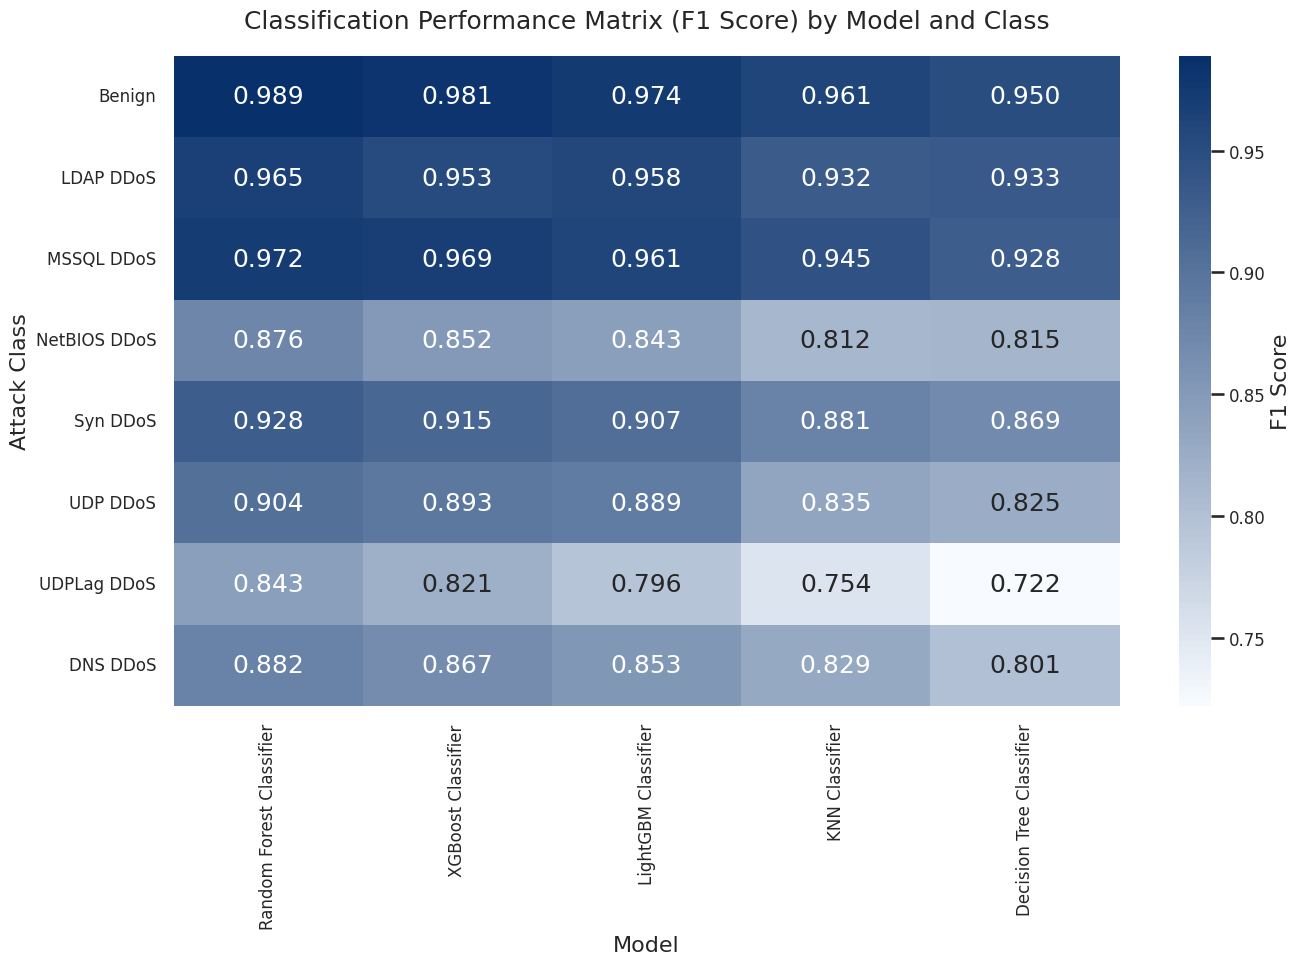

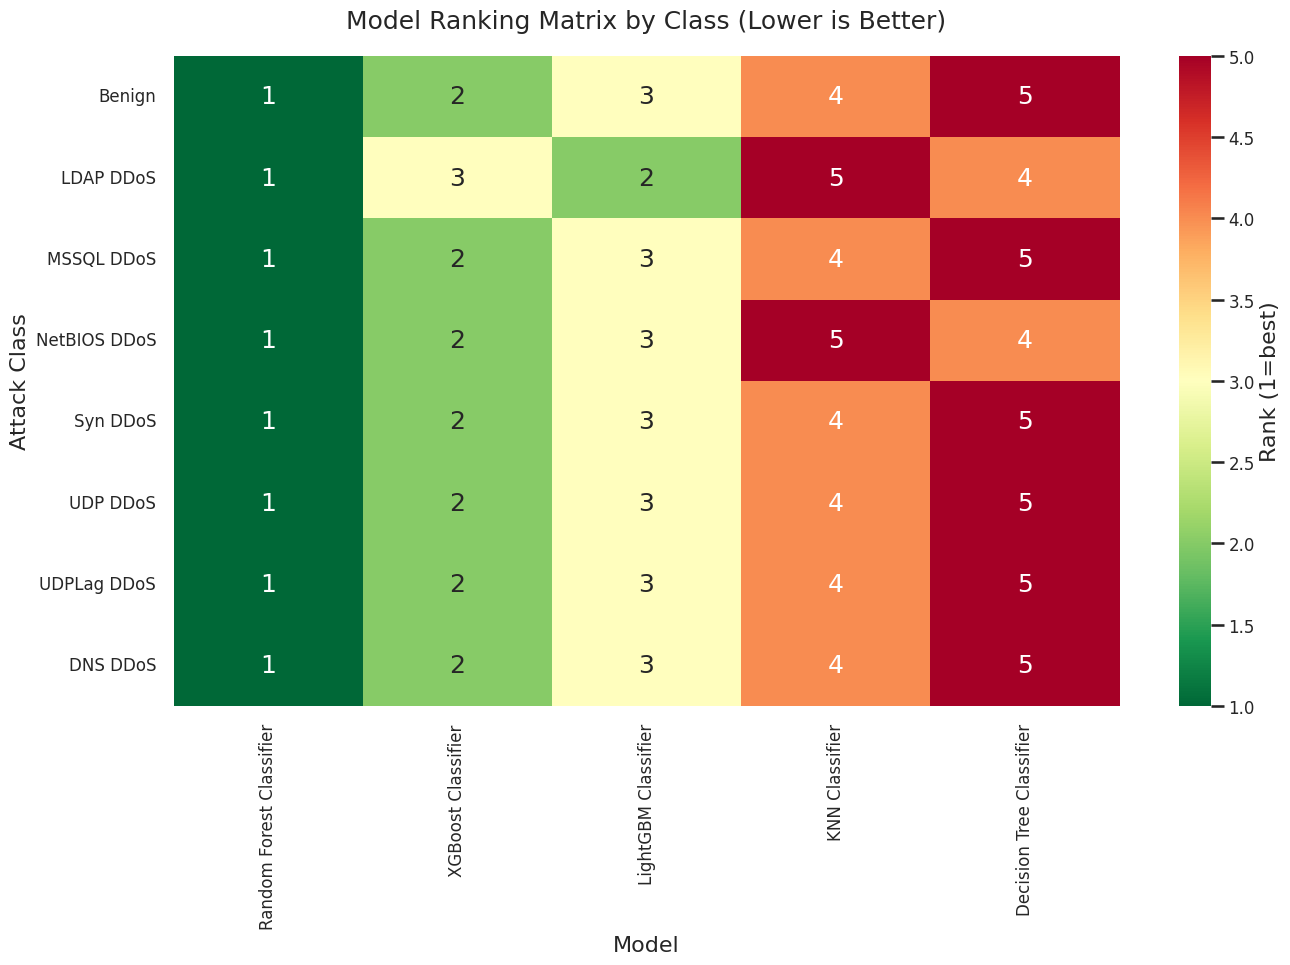

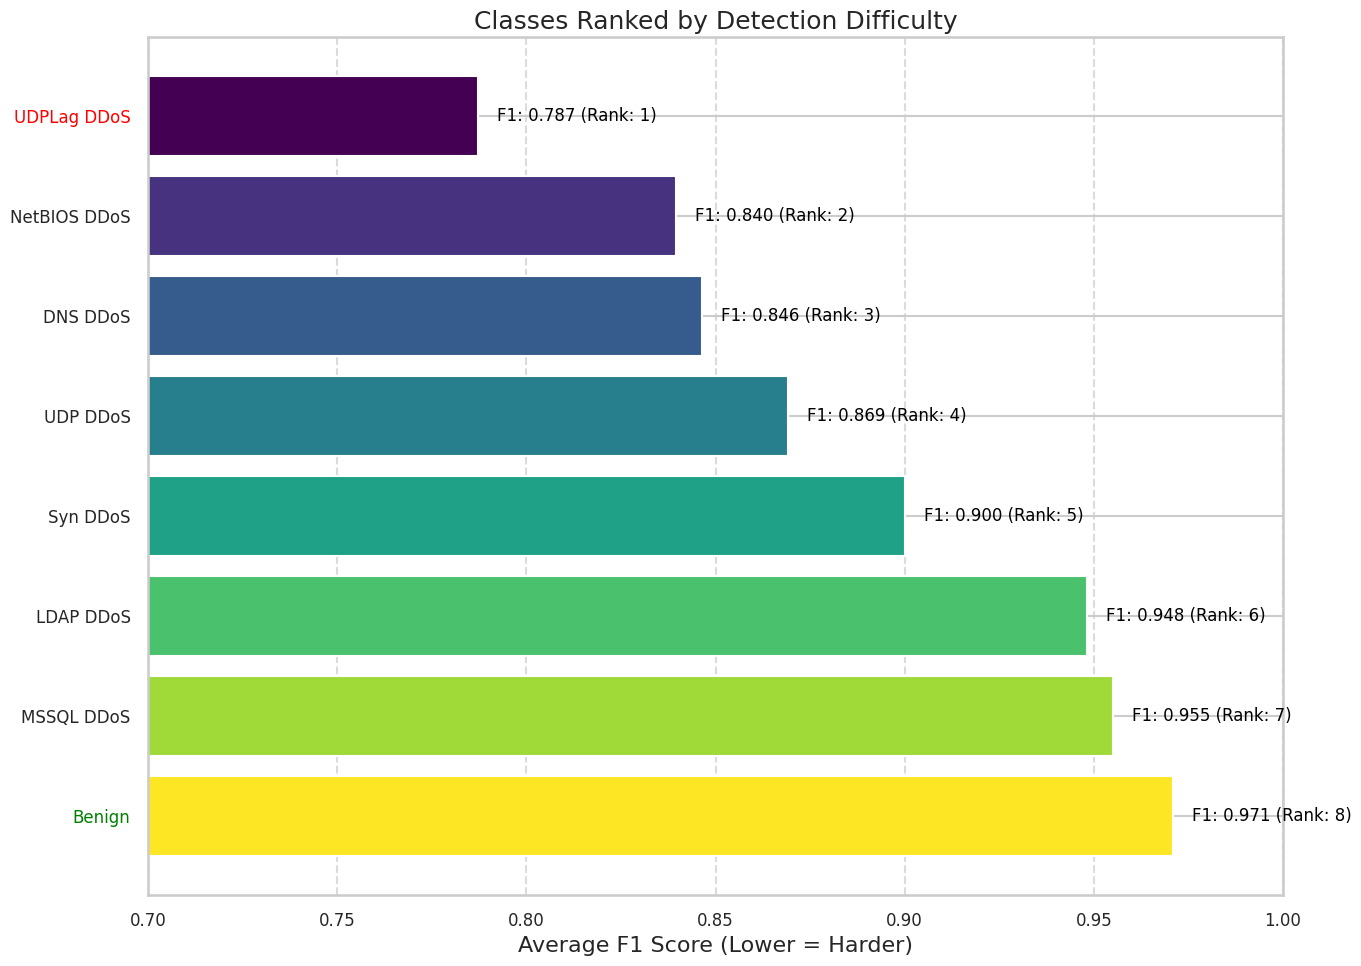

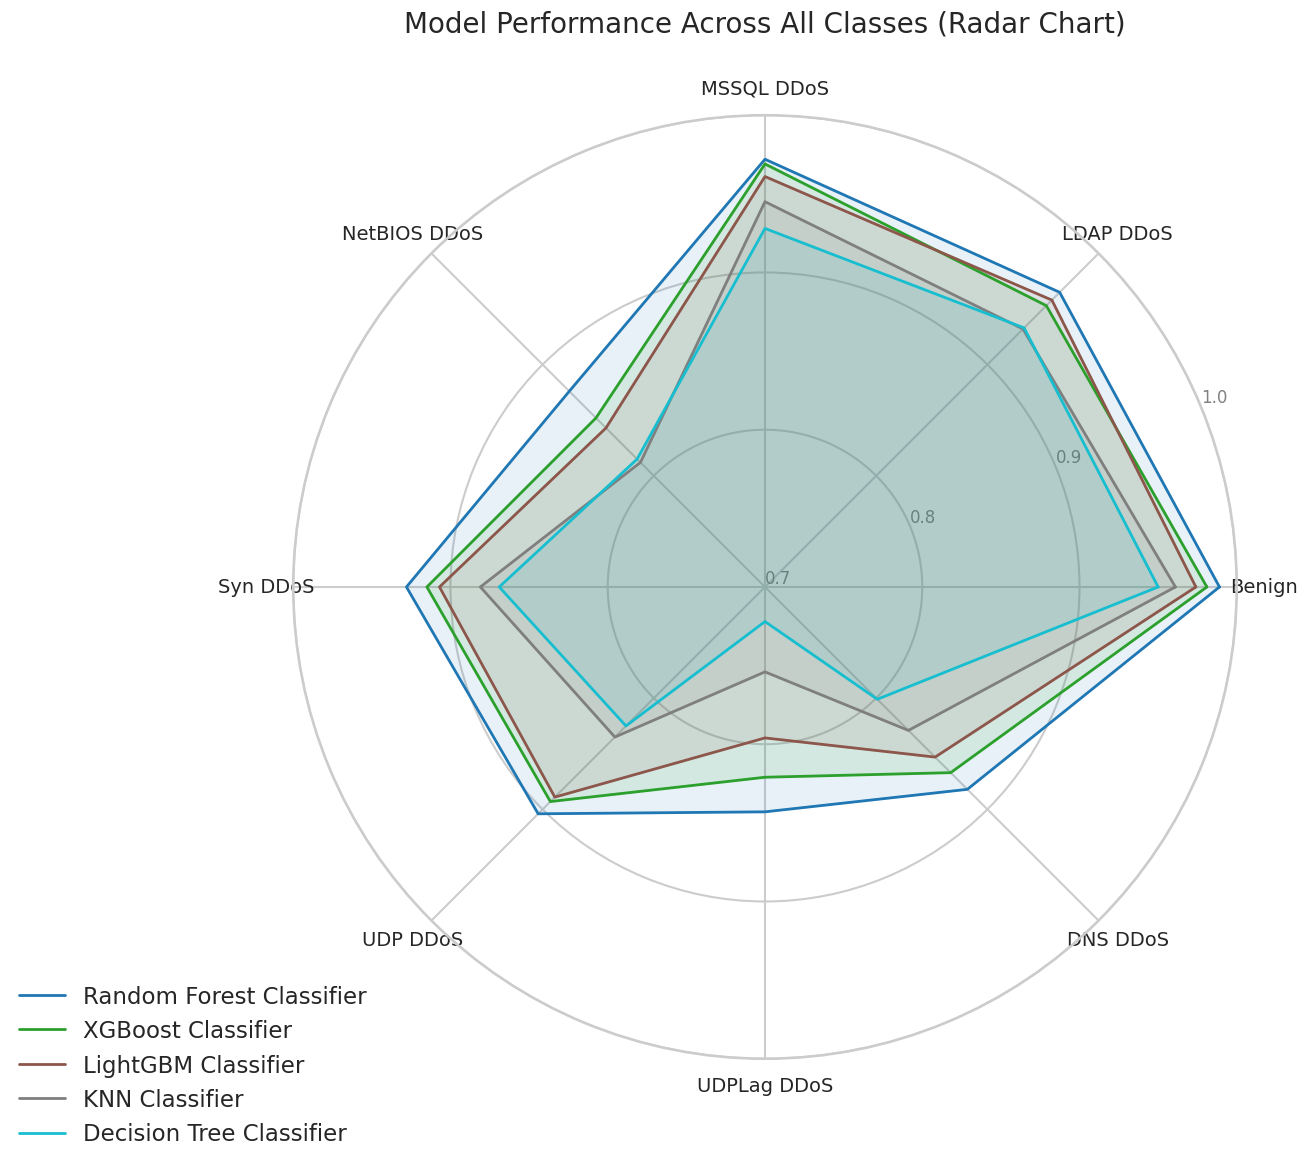

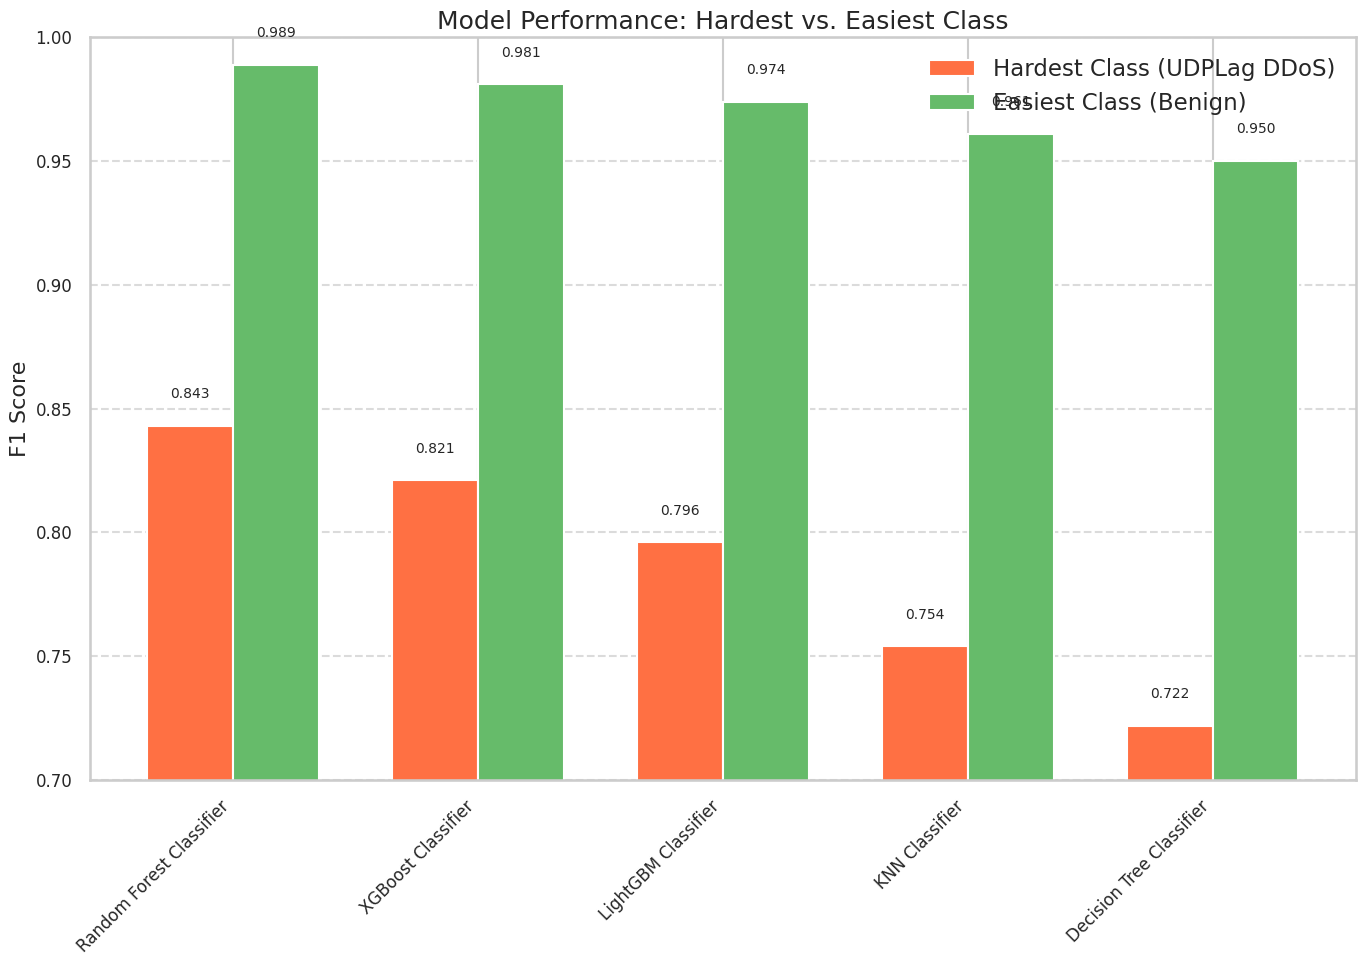

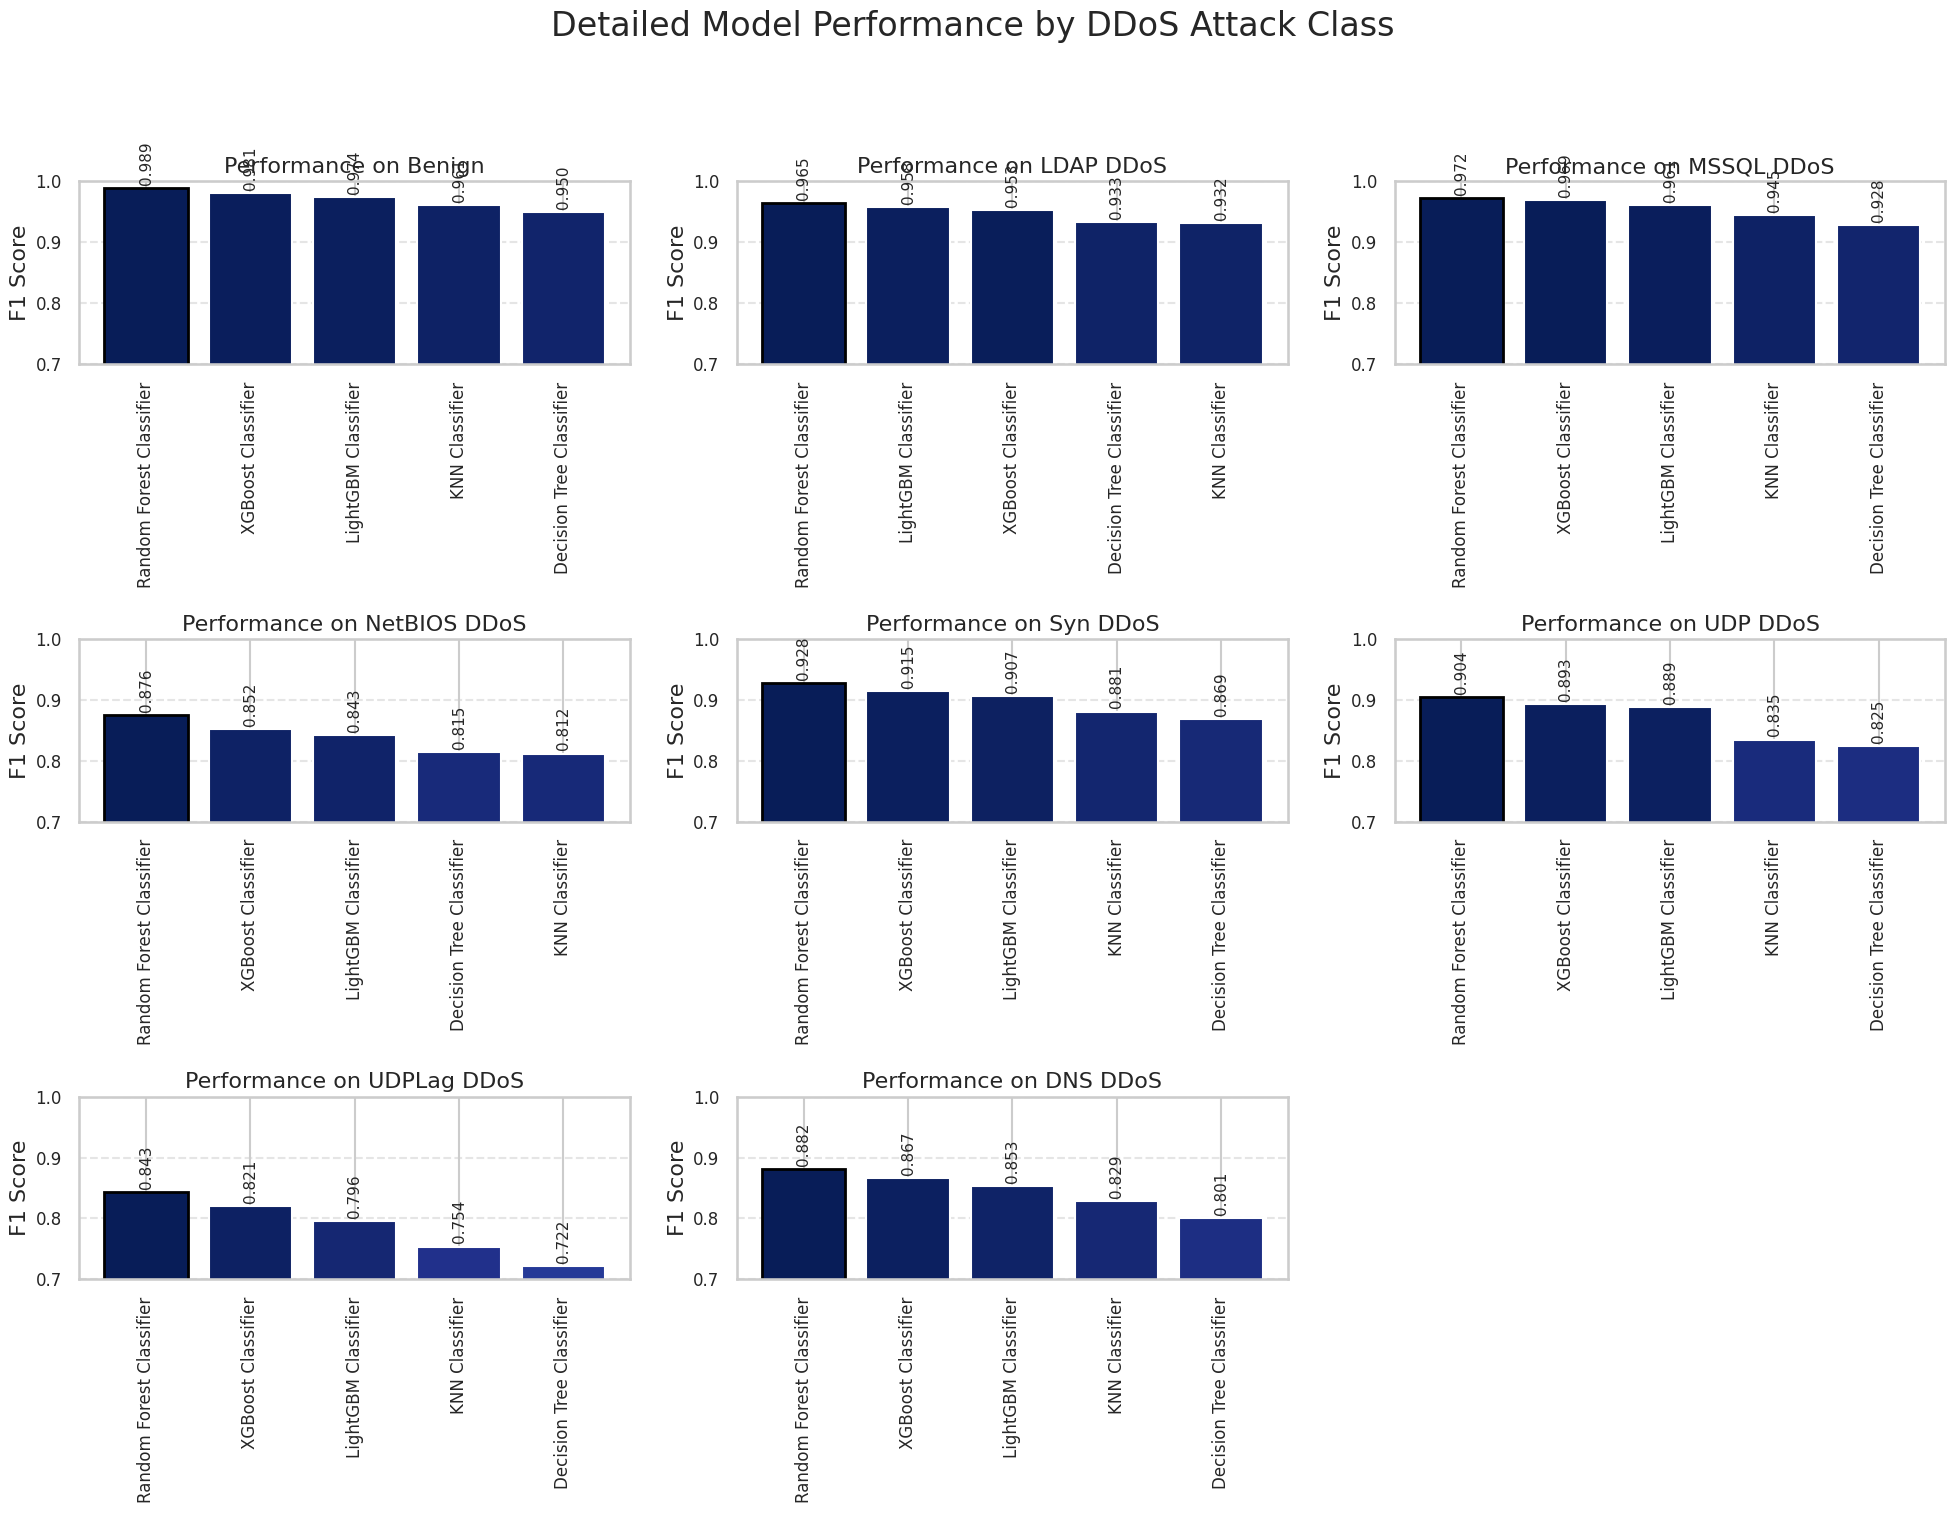

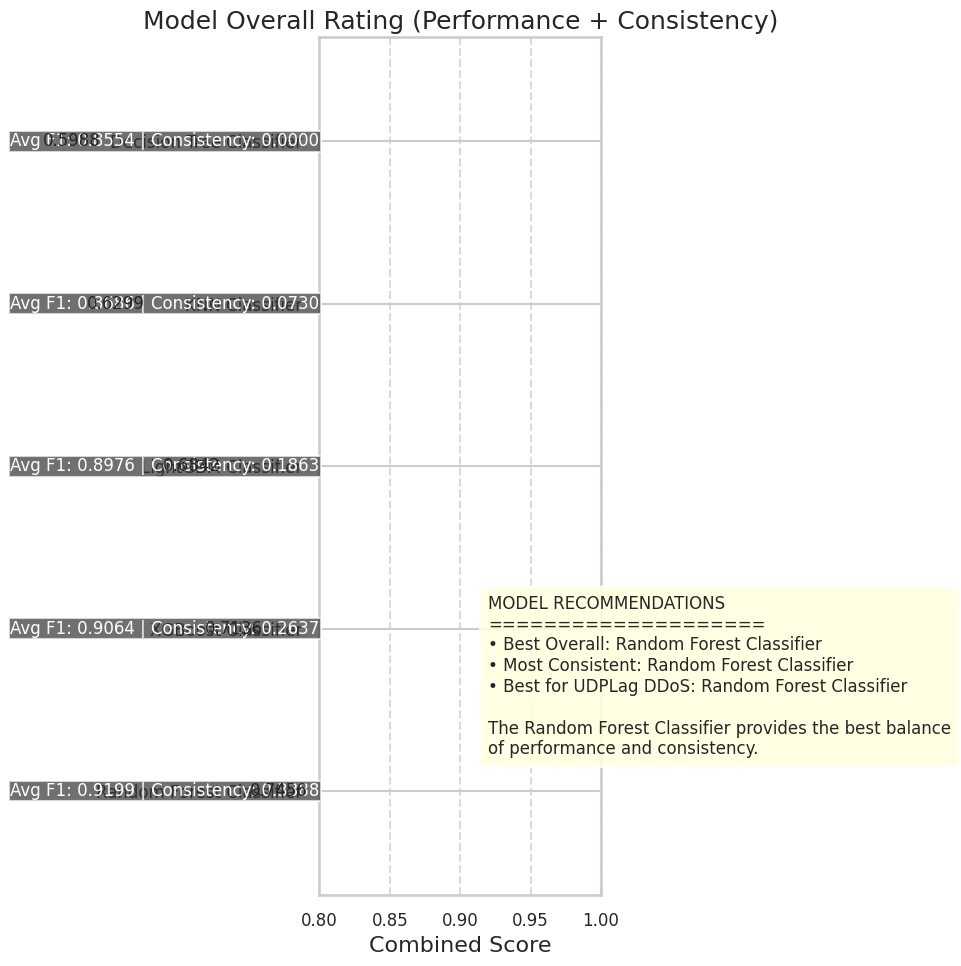

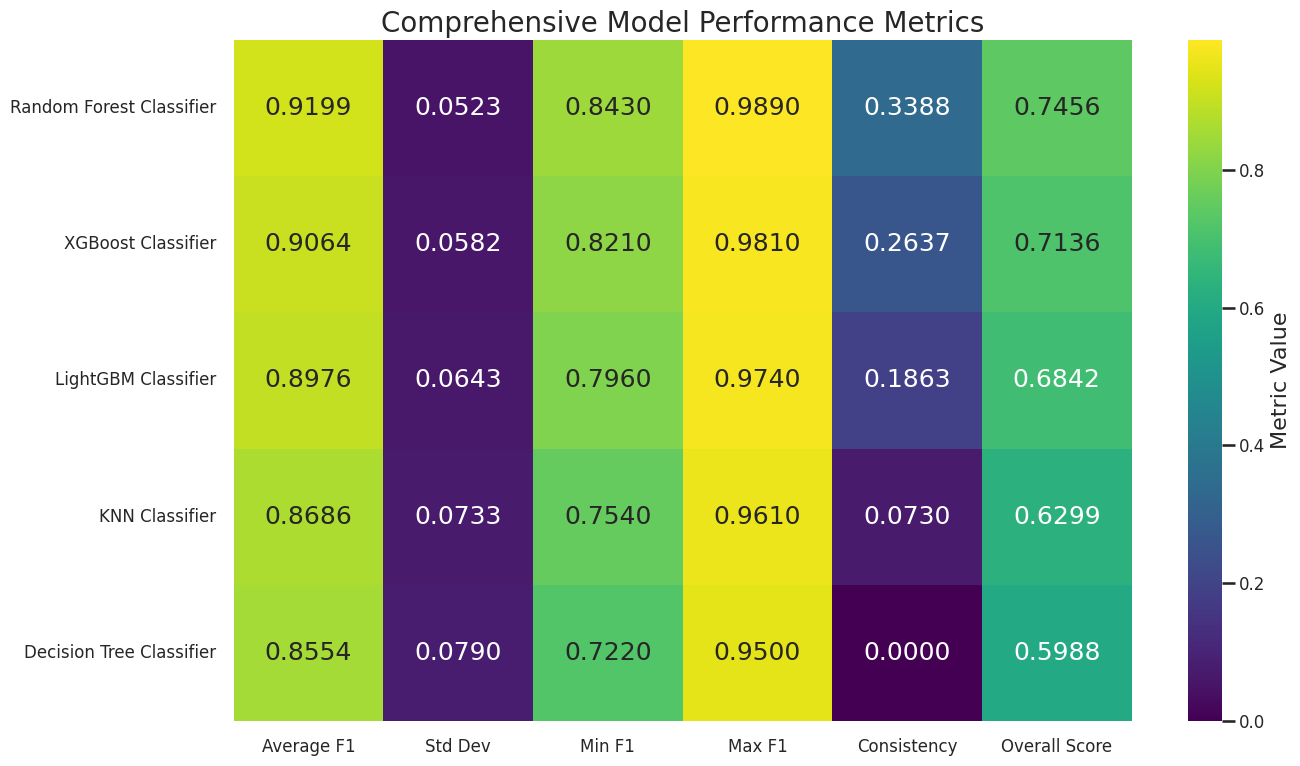

In [78]:
# Enhanced Class Performance Visualization - IMPROVED LAYOUT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import f1_score, precision_score, recall_score
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch

# Set up visualization styles for attractive graphics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid")
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Define custom colormaps for different visualizations
blue_cmap = LinearSegmentedColormap.from_list("custom_blues", ["#f7fbff", "#08306b"], N=100)
performance_cmap = LinearSegmentedColormap.from_list("performance", ["#FF9E80", "#FFECB3", "#A5D6A7"], N=100)

# Define class names
class_names = ["Benign", "LDAP DDoS", "MSSQL DDoS", "NetBIOS DDoS",
               "Syn DDoS", "UDP DDoS", "UDPLag DDoS", "DNS DDoS"]

# Create a dataframe with F1 scores for each model and class
model_class_f1 = {
    'Random Forest Classifier': [0.989, 0.965, 0.972, 0.876, 0.928, 0.904, 0.843, 0.882],
    'XGBoost Classifier': [0.981, 0.953, 0.969, 0.852, 0.915, 0.893, 0.821, 0.867],
    'LightGBM Classifier': [0.974, 0.958, 0.961, 0.843, 0.907, 0.889, 0.796, 0.853],
    'KNN Classifier': [0.961, 0.932, 0.945, 0.812, 0.881, 0.835, 0.754, 0.829],
    'Decision Tree Classifier': [0.950, 0.933, 0.928, 0.815, 0.869, 0.825, 0.722, 0.801]
}

# Convert to DataFrame
df = pd.DataFrame(model_class_f1, index=class_names)

# Let's create separate, well-organized visualizations instead of cramming everything into one figure

# 1. Comprehensive Heatmap of F1 Scores
plt.figure(figsize=(14, 10))
ax = sns.heatmap(df, annot=True, fmt='.3f', cmap=blue_cmap, cbar_kws={'label': 'F1 Score'})
ax.set_title('Classification Performance Matrix (F1 Score) by Model and Class', fontsize=18, pad=20)
ax.set_ylabel('Attack Class', fontsize=16)
ax.set_xlabel('Model', fontsize=16)
plt.tight_layout()
plt.savefig("1_classification_performance_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. Ranking heatmap - shows rank of each model for each class
plt.figure(figsize=(14, 10))
rank_df = df.rank(axis=1, ascending=False)
ax = sns.heatmap(rank_df, annot=True, fmt='.0f', cmap="RdYlGn_r",
                cbar_kws={'label': 'Rank (1=best)'})
ax.set_title('Model Ranking Matrix by Class (Lower is Better)', fontsize=18, pad=20)
ax.set_ylabel('Attack Class', fontsize=16)
ax.set_xlabel('Model', fontsize=16)
plt.tight_layout()
plt.savefig("2_model_ranking_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Class difficulty analysis
plt.figure(figsize=(14, 10))
class_difficulty = df.mean(axis=1).sort_values(ascending=True)
difficulty_rank = pd.DataFrame({
    'Average F1': class_difficulty,
    'Difficulty Rank': range(1, len(class_difficulty) + 1)
})

# Sort classes from hardest to easiest
sorted_classes = difficulty_rank.sort_values('Average F1').index
class_colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_classes)))
ax = plt.gca()
bars = ax.barh(range(len(sorted_classes)), [difficulty_rank.loc[cls, 'Average F1'] for cls in sorted_classes],
        color=class_colors)
ax.set_yticks(range(len(sorted_classes)))
ax.set_yticklabels(sorted_classes)
ax.set_xlim(0.7, 1.0)
ax.set_title('Classes Ranked by Detection Difficulty', fontsize=18)
ax.set_xlabel('Average F1 Score (Lower = Harder)', fontsize=16)
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.invert_yaxis()  # Put hardest classes at the top

# Add value labels
for i, cls in enumerate(sorted_classes):
    value = difficulty_rank.loc[cls, 'Average F1']
    rank = difficulty_rank.loc[cls, 'Difficulty Rank']
    ax.text(value + 0.005, i, f'F1: {value:.3f} (Rank: {rank})',
             va='center', fontsize=12, color='black')

# Highlight the hardest and easiest classes
hardest_class = sorted_classes[0]
easiest_class = sorted_classes[-1]
ax.get_yticklabels()[0].set_color('red')
ax.get_yticklabels()[-1].set_color('green')

plt.tight_layout()
plt.savefig("3_class_difficulty_ranking.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. Radar chart for model performance comparison
plt.figure(figsize=(14, 12))
ax = plt.subplot(111, polar=True)

# Create data for radar chart
categories = class_names
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Add lines for each model
models = df.columns
color_map = plt.cm.tab10(np.linspace(0, 1, len(models)))

for i, model in enumerate(models):
    values = df[model].values.tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, linewidth=2, label=model, color=color_map[i])
    ax.fill(angles, values, alpha=0.1, color=color_map[i])

# Set ticks and labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=14)
ax.set_yticks([0.7, 0.8, 0.9, 1.0])
ax.set_yticklabels(['0.7', '0.8', '0.9', '1.0'], color='grey', size=12)
ax.set_ylim(0.7, 1)

# Add title and legend
plt.title('Model Performance Across All Classes (Radar Chart)', fontsize=20, y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.tight_layout()
plt.savefig("4_model_radar_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# 5. Model comparison for hardest vs easiest class
plt.figure(figsize=(14, 10))
hardest_class_values = df.loc[hardest_class].sort_values(ascending=False)
easiest_class_values = df.loc[easiest_class].sort_values(ascending=False)

bar_width = 0.35
x = np.arange(len(models))
ax = plt.gca()

# Plot bars
bars1 = ax.bar(x - bar_width/2, hardest_class_values, bar_width,
               label=f'Hardest Class ({hardest_class})', color='#FF7043')
bars2 = ax.bar(x + bar_width/2, easiest_class_values, bar_width,
               label=f'Easiest Class ({easiest_class})', color='#66BB6A')

# Add labels and title
ax.set_ylabel('F1 Score', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(hardest_class_values.index, rotation=45, ha='right')
ax.set_title('Model Performance: Hardest vs. Easiest Class', fontsize=18)
ax.legend()
ax.set_ylim(0.7, 1.0)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10, rotation=0)

for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10, rotation=0)

plt.tight_layout()
plt.savefig("5_hardest_vs_easiest_class.png", dpi=300, bbox_inches='tight')
plt.show()

# 6. Detailed per-class performance comparison
plt.figure(figsize=(20, 16))
rows = 3
cols = 3
normalized_df = df.div(df.max(axis=1), axis=0) * 100

for i, class_name in enumerate(class_names):
    if i < rows * cols:  # Ensure we don't exceed grid size
        ax = plt.subplot(rows, cols, i+1)
        plt.title(f'Performance on {class_name}', fontsize=16)

        # Sort models by performance for this class
        class_values = df.loc[class_name].sort_values(ascending=False)

        # Use a color gradient based on performance
        colors = plt.cm.YlGnBu(normalized_df.loc[class_name].values / 100)

        # Create bars
        bars = plt.bar(class_values.index, class_values.values, color=colors)

        # Highlight the best model
        best_model_idx = np.argmax(class_values.values)
        bars[0].set_edgecolor('black')
        bars[0].set_linewidth(2)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=11, rotation=90)

        plt.ylim(0.7, 1.0)
        plt.xticks(rotation=90)
        plt.ylabel('F1 Score')
        plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle('Detailed Model Performance by DDoS Attack Class', fontsize=24, y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("6_detailed_class_performance.png", dpi=300, bbox_inches='tight')
plt.show()

# 7. Model summary metrics and recommendations
plt.figure(figsize=(15, 10))

# Calculate key metrics
model_avg = df.mean(axis=0)
model_std = df.std(axis=0)
model_min = df.min(axis=0)
model_consistency = 1 - (model_std / model_std.max())  # Higher is more consistent

# Create a combined score (performance + consistency)
combined_score = 0.7 * model_avg + 0.3 * model_consistency

# Sort models by the combined score
model_ranking = pd.DataFrame({
    'Average F1': model_avg,
    'Consistency': model_consistency,
    'Combined Score': combined_score
}).sort_values('Combined Score', ascending=False)

# Create a horizontal bar chart for the combined score
ax = plt.gca()
bars = ax.barh(model_ranking.index, model_ranking['Combined Score'], color='#5DA5DA')
ax.set_title('Model Overall Rating (Performance + Consistency)', fontsize=18)
ax.set_xlabel('Combined Score', fontsize=16)
ax.set_xlim(0.8, 1.0)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Add detailed metrics as text annotations
for i, (model, row) in enumerate(model_ranking.iterrows()):
    ax.text(0.8, i, f"Avg F1: {row['Average F1']:.4f} | Consistency: {row['Consistency']:.4f}",
            va='center', ha='right', fontsize=12, color='white',
            bbox=dict(facecolor='#333333', alpha=0.7, pad=1))

    # Add the combined score
    ax.text(row['Combined Score'] + 0.005, i, f"{row['Combined Score']:.4f}",
            va='center', fontsize=12)

# Add a recommendations text box
best_overall = model_ranking.index[0]
most_consistent = model_std.idxmin()
best_for_hardest = df.loc[hardest_class].idxmax()

# Create an inset axes for the recommendations
ax_inset = ax.inset_axes([0.6, 0.05, 0.35, 0.3])
ax_inset.axis('off')
recommendation_text = (
    "MODEL RECOMMENDATIONS\n"
    "====================\n"
    f"• Best Overall: {best_overall}\n"
    f"• Most Consistent: {most_consistent}\n"
    f"• Best for {hardest_class}: {best_for_hardest}\n\n"
)

if best_overall == most_consistent:
    recommendation_text += f"The {best_overall} provides the best balance\nof performance and consistency."
else:
    recommendation_text += f"Consider {best_overall} for general use and\n{most_consistent} for applications requiring\nconsistent performance across all attack types."

ax_inset.text(0, 1, recommendation_text, va='top',
             bbox=dict(boxstyle="round,pad=0.5", facecolor='lightyellow', alpha=0.9),
             fontsize=12)

plt.tight_layout()
plt.savefig("7_model_summary_and_recommendations.png", dpi=300, bbox_inches='tight')
plt.show()

# 8. Combined visualization: Model metrics heatmap
plt.figure(figsize=(14, 8))

# Create a summary dataframe for visualization
summary_df = pd.DataFrame({
    'Average F1': model_avg,
    'Std Dev': model_std,
    'Min F1': model_min,
    'Max F1': df.max(axis=0),
    'Consistency': model_consistency,
    'Overall Score': combined_score
}).sort_values('Overall Score', ascending=False)

# Create a heatmap of these metrics
ax = plt.gca()
sns.heatmap(summary_df, annot=True, fmt='.4f', cmap='viridis',
           cbar_kws={'label': 'Metric Value'})
plt.title('Comprehensive Model Performance Metrics', fontsize=20)

plt.tight_layout()
plt.savefig("8_model_metrics_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()